In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gravis as gv
import networkx as nx

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

## account for the folder structure 
import sys
sys.path.append(os.path.abspath("../scr"))


import wandb 

In [4]:
# Replace argparse with a dictionary
args = {

    "seed": 42, 

    'dataset_transform': [],  # Example list of transformations
    'numbers_list': [1,2,3,4,5,7],  #  [7,9],  # List of integers for class selection
    'N': 100,  # Number of distinct training images per class
    'supervision_label_val': 10,  # An integer value for supervision

    # -----graph-----
    'num_internal_nodes': 1000,  # Number of internal nodes
    'graph_type': 'custom_two_branch',  # custom_two_branch 'fully_connected'  stochastic_block fully_connected_w_self  |  Type of graph fully_connected 'stochastic_block_hierarchy'

    'remove_sens_2_sens': False, 
    'remove_sens_2_sup': False, 

    # -----model-----
    "use_bias": True,
    "normalize_msg": False, 
    'model_type': 'IPC',  # Predictive model type; IPC, PC
    'weight_init': 'fixed 0.001',  # Weight initialization
    # 'weight_init': 'normal 0.001',  # Weight initialization
    'T': 5,  # Number of iterations for gradient descent
    'lr_values': 0.1,  # Learning rate for values
    'lr_weights': 0.0001,  # Learning rate for weights
    # 'lr_weights': 0.0005,  # Learning rate for weights
    'activation_func': 'swish',  # Activation function

    # -----learning-----
    'epochs': 10,  # Number of epochs
    'batch_size': 1,  # Batch size
    'seed': 42,  # Random seed
    'optimizer': False,  # Optimizer, can be True with a float value

    # -----logging-----
    'use_wandb': 'disabled',  # Wandb mode
}

# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument

class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)



[]


In [5]:
# import numpy as np
# import torch
# import random
# import matplotlib.pyplot as plt
# from torch_geometric.utils import to_dense_adj

# class GraphBuilder:
#     def __init__(self, sensory_nodes, branch1_config, branch2_config, supervision_nodes, seed=None):
#         self.sensory_nodes = sensory_nodes
#         self.branch1_config = branch1_config  # Branch 1 config: (layers, clusters per layer, nodes per cluster)
#         self.branch2_config = branch2_config  # Branch 2 config: (layers, clusters per layer, nodes per cluster)
#         self.supervision_nodes = supervision_nodes
        
#         # Calculate total nodes based on branch configurations
#         self.branch1_internal_nodes = branch1_config[0] * branch1_config[1] * branch1_config[2]
#         self.branch2_internal_nodes = branch2_config[0] * branch2_config[1] * branch2_config[2]
#         self.total_nodes = sensory_nodes + self.branch1_internal_nodes + self.branch2_internal_nodes + supervision_nodes
#         self.edge_index = []
#         self.edge_type = []
        
#         # Define node lists for easy access
#         self.sensory_indices = list(range(self.sensory_nodes))
        
#         # Define internal node indices for each branch
#         self.branch1_internal_indices = list(range(sensory_nodes, sensory_nodes + self.branch1_internal_nodes))
#         self.branch2_internal_indices = list(range(sensory_nodes + self.branch1_internal_nodes, sensory_nodes + self.branch1_internal_nodes + self.branch2_internal_nodes))
        
#         # Define supervision indices to start immediately after the last internal node in Branch 2
#         self.supervision_indices = list(range(sensory_nodes + self.branch1_internal_nodes + self.branch2_internal_nodes, self.total_nodes))
        
#         if seed is not None:
#             np.random.seed(seed)
#             torch.manual_seed(seed)
#             random.seed(seed)
        
#         # Connect sensory nodes fully within themselves
#         self.connect_fully(self.sensory_indices, edge_type="Sens2Sens")

#         # Build both branches based on configurations
#         self.build_branch_2()
#         self.build_branch_1()

#         # Fully connect supervision (one-hot) nodes
#         self.connect_fully(self.supervision_indices, edge_type="Sup2Sup")

#         # Convert edge_index to tensor after graph construction
#         self.edge_index = torch.tensor(self.edge_index, dtype=torch.long).t().contiguous()

#     def build_branch_1(self):
#         """Builds Branch 1 based on its configuration."""
#         layers, clusters_per_layer, nodes_per_cluster = self.branch1_config
#         internal_layers = self.create_internal_layers(layers, clusters_per_layer, nodes_per_cluster, start_idx=self.sensory_nodes, branch="branch1")
        
#         # Step 1: Sensory -> Internal Layer 1 (sparse)
#         self.connect_clusters(self.sensory_indices, internal_layers[0], edge_type="Sens2Inter", dense=False)
        
#         # Connect internal layers within Branch 1
#         for i in range(len(internal_layers) - 1):
#             self.connect_clusters(internal_layers[i], internal_layers[i + 1], edge_type="Inter2Inter", dense=False)
        
#         # Step n: Internal Layer n -> Supervision (sparse)
#         self.connect_clusters(internal_layers[-1], self.supervision_indices, edge_type="Inter2Sup", dense=False, verify_direction="Internal -> Supervision")

#     def build_branch_2(self):
#         """Builds Branch 2 based on its configuration."""
#         layers, clusters_per_layer, nodes_per_cluster = self.branch2_config
#         start_idx = self.sensory_nodes + self.branch1_internal_nodes  # Offset by the internal nodes used in Branch 1
#         internal_layers = self.create_internal_layers(layers, clusters_per_layer, nodes_per_cluster, start_idx=start_idx, branch="branch2")
        
#         # Step 1: Supervision -> Internal Layer 1 (sparse)
#         self.connect_clusters(self.supervision_indices, internal_layers[0], edge_type="Sup2Inter", dense=False, verify_direction="Supervision -> Internal")
        
#         # Connect internal layers within Branch 2
#         for i in range(len(internal_layers) - 1):
#             self.connect_clusters(internal_layers[i], internal_layers[i + 1], edge_type="Inter2Inter", dense=False, verify_direction="Internal -> Internal")
        
#         # Step n: Internal Layer n -> Sensory (sparse)
#         self.connect_clusters(internal_layers[-1], self.sensory_indices, edge_type="Inter2Sens", dense=False, verify_direction="Internal -> Sensory")

#     def create_internal_layers(self, num_layers, clusters_per_layer, cluster_size, start_idx, branch):
#         """Creates layers of internal nodes organized into clusters for each branch."""
#         layers = []
#         for _ in range(num_layers):
#             layer_clusters = []
#             for _ in range(clusters_per_layer):
#                 cluster = list(range(start_idx, start_idx + cluster_size))
#                 layer_clusters.append(cluster)
#                 # Fully connect nodes within each internal cluster
#                 self.connect_fully(cluster, edge_type="Inter2Inter")
#                 start_idx += cluster_size
#             layers.append(layer_clusters)

#             # Add the cluster indices to the branch-specific list
#             if branch == "branch1":
#                 self.branch1_internal_indices.extend([node for cluster in layer_clusters for node in cluster])
#             elif branch == "branch2":
#                 self.branch2_internal_indices.extend([node for cluster in layer_clusters for node in cluster])

#         return layers

#     def connect_fully(self, nodes, edge_type):
#         """Connects all nodes in the given list to each other (fully connected)."""
#         for i in range(len(nodes)):
#             for j in range(i + 1, len(nodes)):
#                 self.edge_index.append([nodes[i], nodes[j]])
#                 self.edge_index.append([nodes[j], nodes[i]])
#                 self.edge_type.append(edge_type)
#                 self.edge_type.append(edge_type)

#     def connect_clusters(self, source_nodes, target_clusters, edge_type, dense=False, verify_direction=None):
#         """
#         Connects clusters in dense or sparse configurations, ensuring directed connections based on the branch’s flow.
#         If `verify_direction` is specified, it will log and check if each edge follows the intended flow.
#         """
#         violations = []
        
#         # Flatten source_nodes if it contains clusters
#         if isinstance(source_nodes, range) or isinstance(source_nodes[0], int):
#             source_nodes = list(source_nodes)
#         else:
#             source_nodes = [node for cluster in source_nodes for node in cluster]

#         # If target_clusters is a list of individual nodes, wrap it in another list to make it consistent
#         if isinstance(target_clusters, range) or isinstance(target_clusters[0], int):
#             target_clusters = [list(target_clusters)]
        
#         for source in source_nodes:
#             # Flatten target clusters into a list of individual nodes
#             target_list = [node for cluster in target_clusters for node in cluster]
            
#             if dense:
#                 for target in target_list:
#                     if source != target:
#                         self.edge_index.append([source, target])
#                         self.edge_type.append(edge_type)
#                         if verify_direction and not self.verify_edge_direction(source, target, verify_direction):
#                             violations.append((source, target))
#             else:
#                 sparse_targets = np.random.choice(target_list, size=int(0.2 * len(target_list)), replace=False)
#                 for target in sparse_targets:
#                     self.edge_index.append([source, target])
#                     self.edge_type.append(edge_type)
#                     if verify_direction and not self.verify_edge_direction(source, target, verify_direction):
#                         violations.append((source, target))

#         for cluster in target_clusters:
#             for i in range(len(cluster)):
#                 for j in range(i + 1, len(cluster)):
#                     self.edge_index.append([cluster[i], cluster[j]])
#                     self.edge_index.append([cluster[j], cluster[i]])
#                     self.edge_type.append("Inter2Inter")
#                     self.edge_type.append("Inter2Inter")

#         if verify_direction:
#             if violations:
#                 print(f"Violations found in {verify_direction}:")
#                 for source, target in violations:
#                     print(f"Violation: {source} -> {target}")
#             else:
#                 print(f"All connections in {verify_direction} verified successfully.")

#     def verify_edge_direction(self, source, target, direction):
#         if direction == "Internal -> Supervision":
#             return source < target
#         elif direction == "Supervision -> Internal":
#             return source > target
#         elif direction == "Internal -> Internal":
#             return source != target
#         elif direction == "Internal -> Sensory":
#             return source > target
#         else:
#             return True


In [6]:

# # Parameters for the graph
# sensory_nodes = 25
# branch1_config = (2, 3, 10)  # 2 layers, 5 clusters per layer, 5 nodes per cluster for Branch 1
# branch2_config = (2, 3, 10)  # 2 layers, 5 clusters per layer, 5 nodes per cluster for Branch 2
# supervision_nodes = 10

# # Instantiate and build the graph
# graph_builder = GraphBuilder(sensory_nodes=sensory_nodes, branch1_config=branch1_config, branch2_config=branch2_config, supervision_nodes=supervision_nodes, seed=42)

# adj_matrix = to_dense_adj(graph_builder.edge_index, max_num_nodes=graph_builder.total_nodes).squeeze(0)


In [7]:
# # Print out the indices for each part of the graph for verification
# print("Sensory Node Indices:", graph_builder.sensory_indices)
# print("Branch 1 Internal Node Indices:", graph_builder.branch1_internal_indices)
# print("Branch 2 Internal Node Indices:", graph_builder.branch2_internal_indices)
# print("Supervision Node Indices:", graph_builder.supervision_indices)

In [8]:
# # Plot the adjacency matrix with color-coded sections
# plt.figure(figsize=(20, 20))
# plt.imshow(adj_matrix, cmap="viridis", interpolation="nearest")
# plt.colorbar()
# plt.title("Adjacency Matrix Visualization with Labels")

# # # Add lines to separate sensory, internal (branch 1 and 2), and supervision nodes
# # plt.axhline(y=sensory_nodes - 0.5, color='red', linestyle='--')
# # plt.axhline(y=sensory_nodes + len(graph_builder.branch1_internal_indices) - 0.5, color='blue', linestyle='--')
# # plt.axhline(y=sensory_nodes + len(graph_builder.branch1_internal_indices) + len(graph_builder.branch2_internal_indices) - 0.5, color='green', linestyle='--')

# # plt.axvline(x=sensory_nodes - 0.5, color='red', linestyle='--')
# # plt.axvline(x=sensory_nodes + len(graph_builder.branch1_internal_indices) - 0.5, color='blue', linestyle='--')
# # plt.axvline(x=sensory_nodes + len(graph_builder.branch1_internal_indices) + len(graph_builder.branch2_internal_indices) - 0.5, color='green', linestyle='--')

# # # Label the sections inside the plot area
# # plt.text(sensory_nodes / 2, -10, 'Sensory', ha='center', color='red', fontsize=12)
# # plt.text(sensory_nodes + len(graph_builder.branch1_internal_indices) / 2, -10, 'Branch 1 Internal', ha='center', color='blue', fontsize=12)
# # plt.text(sensory_nodes + len(graph_builder.branch1_internal_indices) + len(graph_builder.branch2_internal_indices) / 2, -10, 'Branch 2 Internal', ha='center', color='green', fontsize=12)
# # plt.text(sensory_nodes + len(graph_builder.branch1_internal_indices) + len(graph_builder.branch2_internal_indices) + supervision_nodes / 2, -10, 'Supervision', ha='center', color='purple', fontsize=12)

# plt.xlabel("Node Index")
# plt.ylabel("Node Index")
# plt.show()


In [9]:
# import gravis as gv
# import networkx as nx

# # Function to convert GraphBuilder's edge_index to networkx graph
# def build_nx_graph(graph_builder):
#     # Initialize directed graph
#     graph = nx.DiGraph()
    
#     # Define colors for each node type
#     sensory_color = 'red'
#     branch1_color = 'blue'
#     branch2_color = 'green'
#     supervision_color = 'purple'
    
#     # # Add nodes with color based on their type
#     # for node in graph_builder.sensory_indices:
#     #     graph.add_node(node, color=sensory_color)
#     # Define grid size for sensory nodes (10x10 grid for 100 nodes)
#     grid_size = int(graph_builder.sensory_nodes ** 0.5)

#     # Add sensory nodes with grid layout
#     for i, node in enumerate(graph_builder.sensory_indices):
#         x = (i % grid_size) * 100  # spacing between nodes horizontally
#         y = (i // grid_size) * 100  # spacing between nodes vertically
#         graph.add_node(node, x=x, y=y, color=sensory_color)

#     for node in graph_builder.branch1_internal_indices:
#         graph.add_node(node, color=branch1_color)
#     for node in graph_builder.branch2_internal_indices:
#         graph.add_node(node, color=branch2_color)
#     for node in graph_builder.supervision_indices:
#         graph.add_node(node, color=supervision_color)
    
#     # Add edges from edge_index
#     for i in range(graph_builder.edge_index.size(1)):
#         source, target = graph_builder.edge_index[:, i].tolist()
#         graph.add_edge(source, target)
    
#     return graph

# # Convert to networkx graph
# nx_graph = build_nx_graph(graph_builder)

# # Plot using Gravis without node annotations
# gv.d3(nx_graph, graph_height=600, show_edge_label=False, node_hover_neighborhood=True, layout_algorithm_active=True, show_node_label=False)


In [10]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

if graph_params["graph_type"]["name"] == "stochastic_block_hierarchy":
    # Configure internal nodes for stochastic_block_hierarchy
    # Define the hierarchical structure with two layers and a final layer
    layer_1_clusters = 49  # First layer has 49 clusters (7x7 grid of 4x4 blocks)
    clusters_per_layer = layer_1_clusters
    num_layers = 2  # Only two layers before the final layer
    final_layer_clusters = 10  # Number of clusters in the final layer

    # Calculate the total internal nodes across the layers
    # - `clusters_per_layer * 16` accounts for the 4x4 nodes per cluster in each layer
    # - The final layer has `final_layer_clusters` nodes
    graph_params["internal_nodes"] = (clusters_per_layer * 16 * num_layers) + final_layer_clusters


if graph_params["graph_type"]["name"] == "two_branch_graph":
    # Configure internal nodes for two_branch_graph
    # This assumes two branches with specified configurations
    branch1_layers, branch1_clusters_per_layer, branch1_nodes_per_cluster = graph_params["branch1_config"]
    branch2_layers, branch2_clusters_per_layer, branch2_nodes_per_cluster = graph_params["branch2_config"]
    
    # Calculate total internal nodes for both branches
    # Branch 1
    branch1_internal_nodes = branch1_layers * branch1_clusters_per_layer * branch1_nodes_per_cluster
    # Branch 2 (Reversed order)
    branch2_internal_nodes = branch2_layers * branch2_clusters_per_layer * branch2_nodes_per_cluster
    
    # The total number of internal nodes will be the sum of both branches
    graph_params["internal_nodes"] = branch1_internal_nodes + branch2_internal_nodes

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)


dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    'edge_type': custom_dataset_train.edge_type, 
    "use_bias": args.use_bias,
 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 

    "normalize_msg": args.normalize_msg,
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

plot_adj_matrix(single_graph, model_dir, 
                node_types=(sensory_indices, internal_indices, supervision_indices))
plot_adj_matrix(full_batch, model_dir, node_types=None)



Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
zzz False False
Supervised learning
Taking first n=100 digits from each class
graph_params {'internal_nodes': 1000, 'supervised_learning': True, 'graph_type': {'name': 'custom_two_branch', 'params': {'branch1_config': (2, 5, 10), 'branch2_config': (2, 5, 10), 'remove_sens_2_sens': False, 'remove_sens_2_sup': False}}, 'seed': 42}
Setting seed: 42
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
{'branch1_config': (2, 5, 10), 'branch2_config': (2, 5, 10), 'remove_sens_2_sens': False, 'remove_sens_2_sup': False}
Creating graph structure for custom_two_branch
All connections in Supervision -> Internal verified successfully.
All connections in Internal -> Internal verified successfully.
All connections in Internal -> Sensory verified successfully.
All connections in Internal -> Supervision verified successfully.
graph cre

In [11]:
num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices

print(num_vertices)
print(sensory_indices)  
print(internal_indices)
print(supervision_indices)

1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

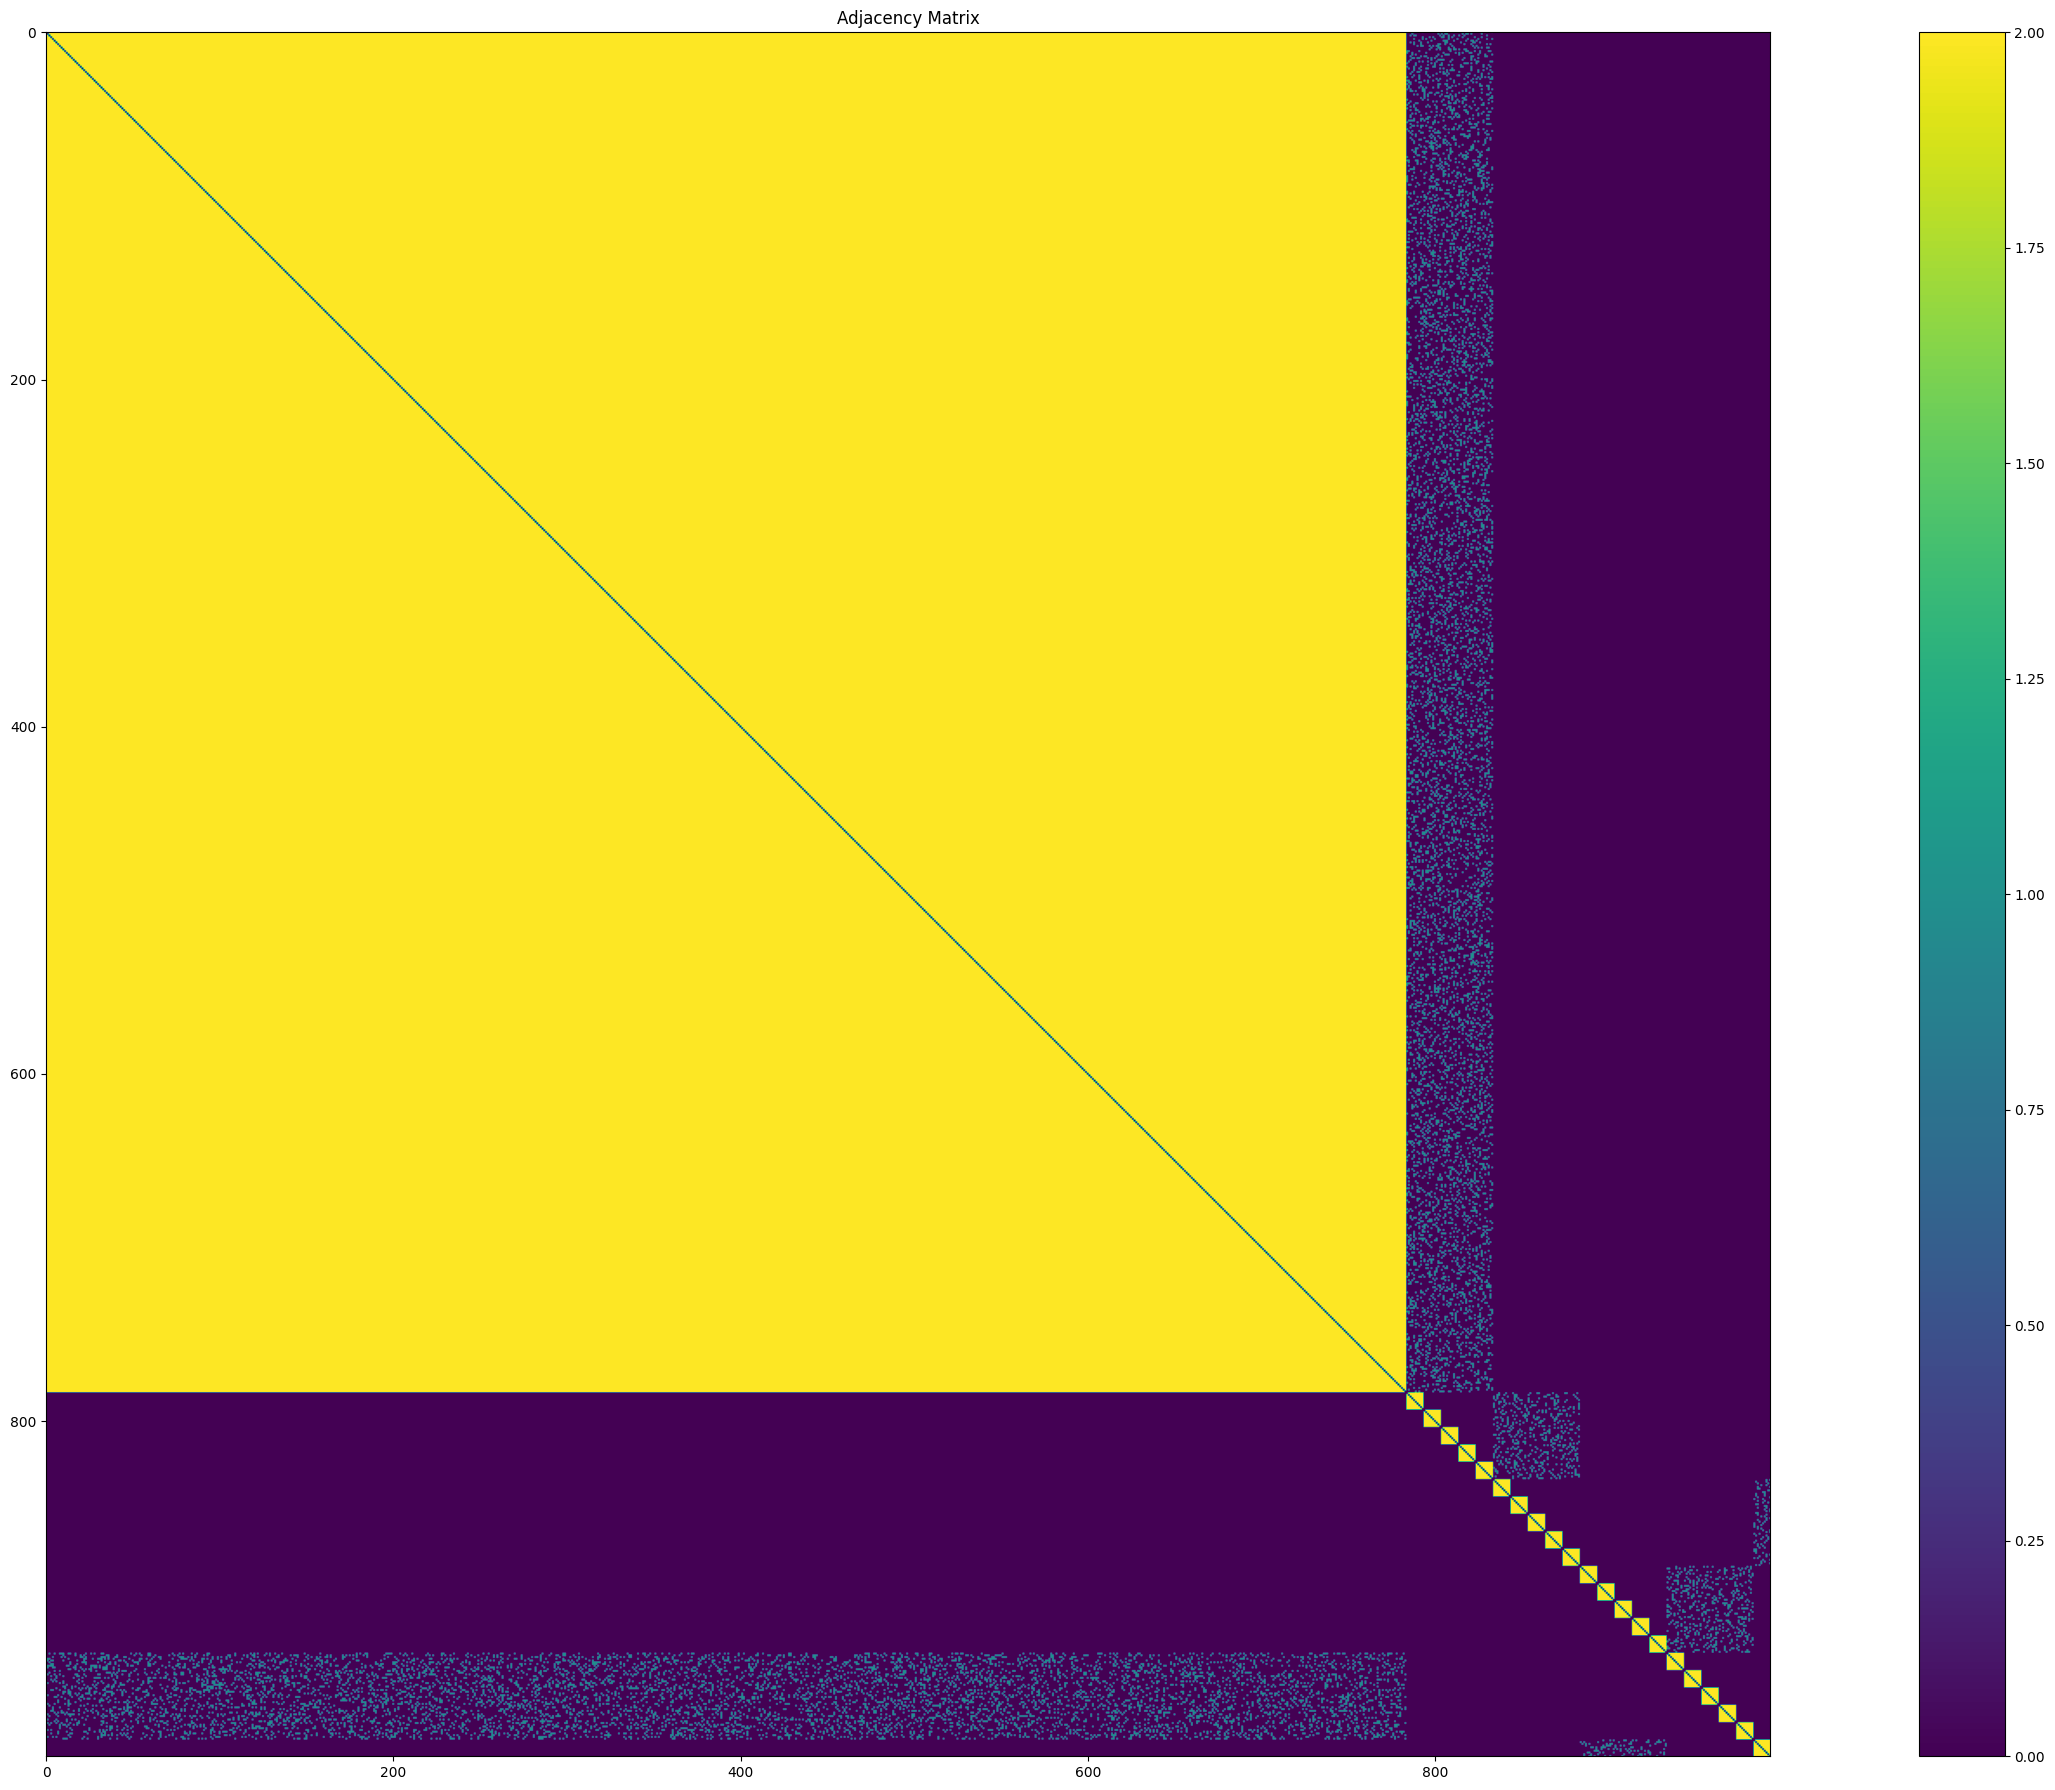

In [12]:
single_graph = custom_dataset_train.edge_index

plot_adj_matrix(single_graph, model_dir=None, node_types=None)


In [13]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]

if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using batch size of 	: 1
Device 			: cuda
Model type 		: ipc


In [14]:
batch

DataBatch(x=[1794, 3, 1], edge_index=[2, 1248364], edge_attr=[1248364], y=[1], batch=[1794], ptr=[2])

In [15]:
# model_params["normalize_msg"] = True 
# model_params["weight_init"] = 0.001
# model_params["weight_init"] = "fixed 0.001"
# model_params["weight_init"] = "normal 0.001"
# model_params["use_learning_optimizer"] = [0.1]
# model_params["use_learning_optimizer"] = False
# model_params["T"] = 50


In [16]:

args.model_type = "ipc"
# args.model_type = "pc"
# 

In [17]:
args.model_type

'ipc'

In [18]:
model_params["use_bias"]

True

In [19]:
model = None 
from helper.plot import plot_energy_during_training

if args.model_type.lower() == "pc":
        
    from models.PC import *

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        
    from models.IPC import  *

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
# wandb.watch(model, 
#             log="all",   # (str) One of "gradients", "parameters", "all", or None
#             log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
# plot_model_weights(model, save_path)



######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 
model.pc_conv1.set_mode("training")

------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: True
INIT BIAS WITH THE MEAN OF THE DATASET???
Using self.adjust_delta_w,  False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: True
INIT BIAS WITH THE MEAN OF THE DATASET???
Using self.adjust_delta_w,  False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading IPC model-----------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode training--------------
-------------task None--------------


In [20]:
# Extract the edge indices and weights
import scipy.sparse as sp


conn_types = custom_dataset_train.edge_type
if args.graph_type == "fully_connected":
    if conn_types is not None:
        
        edge_index = custom_dataset_train.edge_index
        print(edge_index.shape)
        # Create a sparse matrix using the edge indices and weights
        W_sparse = sp.coo_matrix((conn_types, (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

        # Convert to dense for detailed visualization (if the graph is not too large)
        W = W_sparse.toarray()

        fig, axs = plt.subplots(figsize=(19,8))
        plt.imshow(W)
        plt.colorbar()
        plt.show()

tensor(0.1307)


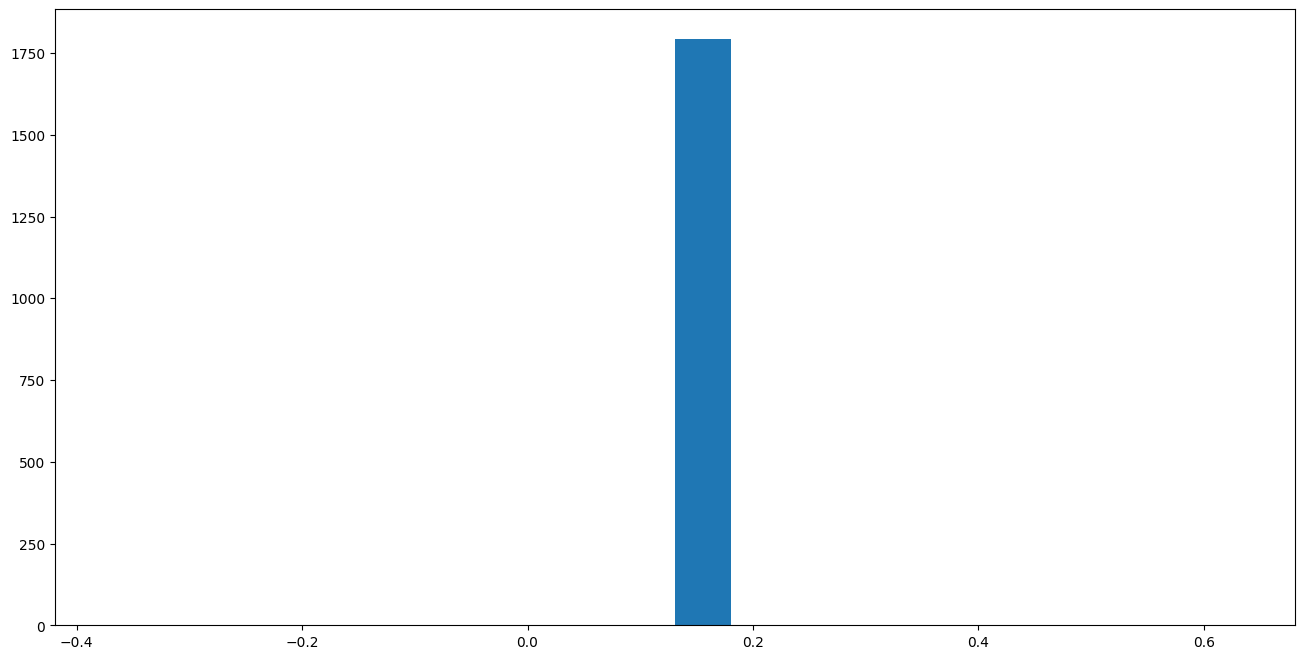

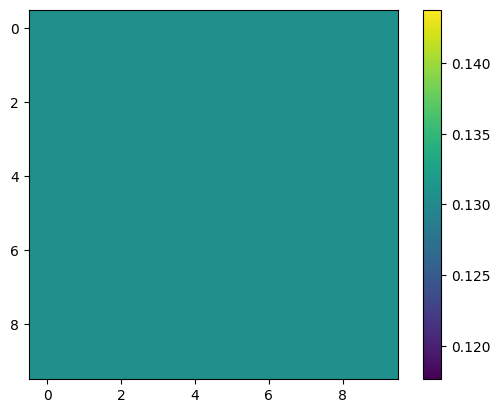

In [21]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:100].reshape(10,10))
    plt.colorbar()
    plt.show()

In [22]:
# assert 1 == 2 

In [23]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Learn in stages

In [24]:
# from helper.plot import plot_energy_during_training
# import time
# torch.cuda.empty_cache()

# model = model.to(device)
# print(len(train_loader))
# print("Starting training")

# # Initialize early stopping and history
# earlystop = False
# history = {
#     "internal_energy_per_epoch": [],
#     "sensory_energy_per_epoch": [],
#     "internal_energy_per_batch_last": [],
#     "sensory_energy_per_batch_last": [],
# }

# # Define early stopping threshold and OOM warning
# threshold_earlystop = 0.05
# max_energy_threshold = 1e6

# start_time = time.time()

# # Variables to control staged learning
# current_digit = custom_dataset_train.numbers_list[0]  # start with the first digit
# batch_count_for_digit = 0  # track batches per digit

# for epoch in range(args.epochs):
#     total_loss = 0
#     last_loss = 1e10

#     if earlystop:
#         break

#     train_loader_iter = iter(train_loader)  # Reset the iterator for each epoch
#     while True:
#         torch.cuda.empty_cache()

#         try:
#             # Fetch a batch and check if its label matches the current digit
#             batch, clean = next(train_loader_iter)
#             if batch.y.item() != current_digit:
#                 continue  # Skip this batch if it's not the current digit

#             # Process batch since it matches the current digit
#             batch = batch.to(device)
#             print("Label:", batch.y.item(), "Input Shape:", batch.x.shape)
#             model.train()

#             history_epoch = model.learning(batch)

#             # Append energy values to history
#             history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
#             history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])
#             history["internal_energy_per_batch_last"].append(history_epoch["internal_energy_last"])
#             history["sensory_energy_per_batch_last"].append(history_epoch["sensory_energy_last"])

#             model.pc_conv1.restart_activity()
#             batch_count_for_digit += 1
#             print(f"------------------ Epoch {epoch}: Batch for digit {current_digit}: {batch_count_for_digit} ------------------")

#             # Check for early stopping conditions
#             if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
#                 earlystop = True
#                 print(f"EARLY STOPPED at epoch {epoch}")
#                 print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
#                 break

#             if history_epoch["internal_energy_mean"] > max_energy_threshold:
#                 print("Energy too high, stopping training")
#                 earlystop = True
#                 break

#             # Once we've processed 10 batches for the current digit, move to the next one
#             if batch_count_for_digit >= 10:
#                 batch_count_for_digit = 0
#                 current_digit = (current_digit + 1) % 10  # cycle through 0-9
#                 print(f"Moving to next digit: {current_digit}")

#                 # Plot energies and save checkpoint if desired
#                 plot_energy_during_training(
#                     model.pc_conv1.energy_vals["internal_energy"][:],
#                     model.pc_conv1.energy_vals["sensory_energy"][:],
#                     history,
#                     model_dir=model_dir,
#                     epoch=epoch
#                 )
#                 break
        
#         except StopIteration:
#             # End the loop if we've exhausted the data loader
#             print("End of DataLoader reached, stopping epoch.")
#             break

#         except RuntimeError as e:
#             if 'out of memory' in str(e):
#                 print('WARNING: CUDA ran out of memory, skipping batch...')
#                 torch.cuda.empty_cache()
#                 continue
#             else:
#                 torch.cuda.empty_cache()
#                 raise e

#     print(f"Epoch {epoch} / {args.epochs} completed")

# end_time = time.time()
# print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# Original Learning

In [25]:
model.pc_conv1.T = 20


In [29]:
graph_params

{'internal_nodes': 1000,
 'supervised_learning': True,
 'graph_type': {'name': 'custom_two_branch',
  'params': {'branch1_config': (2, 5, 10),
   'branch2_config': (2, 5, 10),
   'remove_sens_2_sens': False,
   'remove_sens_2_sup': False}},
 'seed': 42}

IPCGNN(
  (pc_conv1): IPCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
36359
Starting training
Done for idx 33216
Done for idx 32333
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
Done for idx 34915
torch.Size([1794])
Initial internal energy (t=0): 57.38455581665039


Total energy at time 0 {'internal_energy': 57.38455581665039, 'supervised_energy': 48.803741455078125, 'sensory_energy': 49.15149688720703, 'energy_total': 106.6214599609375}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8693, device='cuda:0') tensor(-0.1319, device='cuda:0')
f_x / max, mean tensor(9.0116, device='cuda:0') 

Total energy at time 1 / 20 {'internal_energy': 46.477134704589844, 'supervised_energy': 39.5147819519043, 'sensory_energy': 48.72566223144531, 'energy_total': 95.2882080078125},:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s]

tensor(0.0534, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8809, device='cuda:0') tensor(-0.1256, device='cuda:0')
f_x / max, mean tensor(8.1220, device='cuda:0') tensor(0.0563, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.644798278808594, 'supervised_energy': 31.994569778442383, 'sensory_energy': 48.307960510253906, 'energy_total': 86.03817749023438},:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.49233627319336, 'supervised_energy': 25.906005859375, 'sensory_energy': 47.89820098876953, 'energy_total': 78.4759521484375},:  15%|█▌        | 3/20 [00:00<00:01, 12.29it/s]      

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9915, device='cuda:0') tensor(-0.1200, device='cuda:0')
f_x / max, mean tensor(7.3202, device='cuda:0') tensor(0.0589, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1913, device='cuda:0') tensor(-0.1150, device='cuda:0')
f_x / max, mean tensor(6.5968, device='cuda:0') tensor(0.0612, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 20.00885009765625, 'supervised_energy': 16.98492431640625, 'sensory_energy': 47.10196304321289, 'energy_total': 67.19622802734375},:  25%|██▌       | 5/20 [00:00<00:01, 14.83it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4712, device='cuda:0') tensor(-0.1105, device='cuda:0')
f_x / max, mean tensor(5.9431, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8233, device='cuda:0') tensor(-0.1065, device='cuda:0')
f_x / max, mean tensor(5.3513, device='cuda:0') tensor(0.0653, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 7 / 20 {'internal_energy': 13.132266998291016, 'supervised_energy': 11.136216163635254, 'sensory_energy': 46.33580780029297, 'energy_total': 59.553489685058594},:  35%|███▌      | 7/20 [00:00<00:00, 15.73it/s]

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2402, device='cuda:0') tensor(-0.1029, device='cuda:0')
f_x / max, mean tensor(4.8143, device='cuda:0') tensor(0.0671, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7156, device='cuda:0') tensor(-0.0997, device='cuda:0')
f_x / max, mean tensor(4.3261, device='cuda:0') tensor(0.0687, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.621051788330078, 'supervised_energy': 7.301567077636719, 'sensory_energy': 45.598670959472656, 'energy_total': 54.30513000488281},:  45%|████▌     | 9/20 [00:00<00:00, 16.16it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2435, device='cuda:0') tensor(-0.0969, device='cuda:0')
f_x / max, mean tensor(3.8815, device='cuda:0') tensor(0.0701, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8186, device='cuda:0') tensor(-0.0944, device='cuda:0')
f_x / max, mean tensor(3.4764, device='cuda:0') 

Total energy at time 11 / 20 {'internal_energy': 5.6612548828125, 'supervised_energy': 4.787356853485107, 'sensory_energy': 44.8895149230957, 'energy_total': 50.63618469238281},:  45%|████▌     | 9/20 [00:00<00:00, 16.16it/s]   

tensor(0.0714, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4363, device='cuda:0') tensor(-0.0921, device='cuda:0')
f_x / max, mean tensor(3.1074, device='cuda:0') tensor(0.0726, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.58829402923584, 'supervised_energy': 3.876465320587158, 'sensory_energy': 44.54513168334961, 'energy_total': 49.218841552734375},:  55%|█████▌    | 11/20 [00:00<00:00, 15.64it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0923, device='cuda:0') tensor(-0.0902, device='cuda:0')
f_x / max, mean tensor(2.7716, device='cuda:0') tensor(0.0737, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7827, device='cuda:0') tensor(-0.0884, device='cuda:0')
f_x / max, mean 

Total energy at time 14 / 20 {'internal_energy': 3.015007734298706, 'supervised_energy': 2.541656732559204, 'sensory_energy': 43.87614440917969, 'energy_total': 46.976566314697266},:  65%|██████▌   | 13/20 [00:00<00:00, 15.55it/s] 

tensor(2.4671, device='cuda:0') tensor(0.0746, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5041, device='cuda:0') tensor(-0.0869, device='cuda:0')
f_x / max, mean tensor(2.1918, device='cuda:0') tensor(0.0755, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2534, device='cuda:0') tensor(-0.0856, device='cuda:0')
f_x / max, mean tensor(1.9442, device='cuda:0') tensor(0.0763, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.4445877075195312, 'supervised_energy': 2.058061361312866, 'sensory_energy': 43.55130386352539, 'energy_total': 46.08130645751953},:  75%|███████▌  | 15/20 [00:00<00:00, 16.03it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0278, device='cuda:0') tensor(-0.0844, device='cuda:0')
f_x / max, mean tensor(1.7224, device='cuda:0') tensor(0.0770, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.3046691417694092, 'supervised_energy': 1.0926703214645386, 'sensory_energy': 42.614044189453125, 'energy_total': 44.004127502441406},:  85%|████████▌ | 17/20 [00:01<00:00, 16.38it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8248, device='cuda:0') tensor(-0.0834, device='cuda:0')
f_x / max, mean tensor(1.5248, device='cuda:0') tensor(0.0776, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6421, device='cuda:0') tensor(-0.0825, device='cuda:0')
f_x / max, mean tensor(1.3496, device='cuda:0') tensor(0.0782, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 19 / 20 {'internal_energy': 1.0588529109954834, 'supervised_energy': 0.8847807049751282, 'sensory_energy': 42.31367492675781, 'energy_total': 43.457942962646484},:  95%|█████████▌| 19/20 [00:01<00:00, 16.76it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3298, device='cuda:0') tensor(-0.0810, device='cuda:0')
f_x / max, mean tensor(1.0585, device='cuda:0') tensor(0.0792, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 577
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8596574068069458
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8596574068069458
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.39183044433594


Total energy at time 1 / 20 {'internal_energy': 46.483150482177734, 'supervised_energy': 39.51482391357422, 'sensory_energy': 55.35745620727539, 'energy_total': 101.92601776123047},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8694, device='cuda:0') tensor(-0.1350, device='cuda:0')
f_x / max, mean tensor(9.0116, device='cuda:0') tensor(0.0613, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.649845123291016, 'supervised_energy': 31.994497299194336, 'sensory_energy': 54.81268310546875, 'energy_total': 92.54793548583984},:  10%|█         | 2/20 [00:00<00:01, 16.38it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8809, device='cuda:0') tensor(-0.1289, device='cuda:0')
f_x / max, mean tensor(8.1219, device='cuda:0') tensor(0.0642, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.49663734436035, 'supervised_energy': 25.90587615966797, 'sensory_energy': 54.28071975708008, 'energy_total': 84.86276245117188},:  10%|█         | 2/20 [00:00<00:01, 16.38it/s]  

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9915, device='cuda:0') tensor(-0.1234, device='cuda:0')
f_x / max, mean tensor(7.3201, device='cuda:0') tensor(0.0668, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1913, device='cuda:0') tensor(-0.1185, device='cuda:0')
f_x / max, mean tensor(6.5967, device='cuda:0') tensor(0.0692, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.703678131103516, 'supervised_energy': 20.976207733154297, 'sensory_energy': 53.761253356933594, 'energy_total': 78.55033874511719},:  20%|██        | 4/20 [00:00<00:00, 17.04it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4712, device='cuda:0') tensor(-0.1141, device='cuda:0')
f_x / max, mean tensor(5.9430, device='cuda:0') tensor(0.0713, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 20.012096405029297, 'supervised_energy': 16.984771728515625, 'sensory_energy': 53.253997802734375, 'energy_total': 73.35150146484375},:  20%|██        | 4/20 [00:00<00:00, 17.04it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8232, device='cuda:0') tensor(-0.1103, device='cuda:0')
f_x / max, mean tensor(5.3511, device='cuda:0') tensor(0.0733, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.134828567504883, 'supervised_energy': 11.13608455657959, 'sensory_energy': 52.274940490722656, 'energy_total': 65.49518585205078},:  30%|███       | 6/20 [00:00<00:00, 16.71it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2402, device='cuda:0') tensor(-0.1068, device='cuda:0')
f_x / max, mean tensor(4.8141, device='cuda:0') tensor(0.0750, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7155, device='cuda:0') 

Total energy at time 8 / 20 {'internal_energy': 10.64216136932373, 'supervised_energy': 9.01718521118164, 'sensory_energy': 51.80260467529297, 'energy_total': 62.530174255371094},:  40%|████      | 8/20 [00:00<00:00, 16.89it/s]  

tensor(-0.1038, device='cuda:0')
f_x / max, mean tensor(4.3259, device='cuda:0') tensor(0.0766, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2434, device='cuda:0') 

Total energy at time 9 / 20 {'internal_energy': 8.62314510345459, 'supervised_energy': 7.301464557647705, 'sensory_energy': 51.34137725830078, 'energy_total': 60.04994201660156},:  40%|████      | 8/20 [00:00<00:00, 16.89it/s] 

tensor(-0.1011, device='cuda:0')
f_x / max, mean tensor(3.8814, device='cuda:0') tensor(0.0781, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8185, device='cuda:0') tensor(-0.0987, device='cuda:0')
f_x / max, mean tensor(3.4763, device='cuda:0') tensor(0.0794, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.987737655639648, 'supervised_energy': 5.912201881408691, 'sensory_energy': 50.89099884033203, 'energy_total': 57.96414566040039},:  50%|█████     | 10/20 [00:00<00:00, 16.95it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4362, device='cuda:0') tensor(-0.0966, device='cuda:0')
f_x / max, mean tensor(3.1072, device='cuda:0') tensor(0.0805, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.663013935089111, 'supervised_energy': 4.787277698516846, 'sensory_energy': 50.45122528076172, 'energy_total': 56.199649810791016},:  50%|█████     | 10/20 [00:00<00:00, 16.95it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0922, device='cuda:0') tensor(-0.0947, device='cuda:0')
f_x / max, mean tensor(2.7715, device='cuda:0') tensor(0.0816, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.7206308841705322, 'supervised_energy': 3.1388280391693115, 'sensory_energy': 49.60251998901367, 'energy_total': 53.40856170654297},:  60%|██████    | 12/20 [00:00<00:00, 16.82it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7826, device='cuda:0') tensor(-0.0931, device='cuda:0')
f_x / max, mean tensor(2.4669, device='cuda:0') tensor(0.0826, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 3.0164167881011963, 'supervised_energy': 2.5416009426116943, 'sensory_energy': 49.1931266784668, 'energy_total': 52.294952392578125},:  70%|███████   | 14/20 [00:00<00:00, 16.90it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5040, device='cuda:0') tensor(-0.0917, device='cuda:0')
f_x / max, mean tensor(2.1917, device='cuda:0') tensor(0.0834, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2533, device='cuda:0') 

Total energy at time 15 / 20 {'internal_energy': 2.4459075927734375, 'supervised_energy': 2.0580103397369385, 'sensory_energy': 48.79339599609375, 'energy_total': 51.3247184753418},:  70%|███████   | 14/20 [00:00<00:00, 16.90it/s] 

tensor(-0.0905, device='cuda:0')
f_x / max, mean tensor(1.9440, device='cuda:0') tensor(0.0842, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0277, device='cuda:0') tensor(-0.0894, device='cuda:0')
f_x / max, mean tensor(1.7223, device='cuda:0') tensor(0.0849, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9836986064910889, 'supervised_energy': 1.6664361953735352, 'sensory_energy': 48.40311813354492, 'energy_total': 50.47222900390625},:  80%|████████  | 16/20 [00:01<00:00, 12.72it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8247, device='cuda:0') tensor(-0.0885, device='cuda:0')
f_x / max, mean tensor(1.5247, device='cuda:0') tensor(0.0856, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.3057832717895508, 'supervised_energy': 1.0926328897476196, 'sensory_energy': 47.650028228759766, 'energy_total': 49.04122543334961},:  90%|█████████ | 18/20 [00:01<00:00, 12.87it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6420, device='cuda:0') tensor(-0.0877, device='cuda:0')
f_x / max, mean tensor(1.3494, device='cuda:0') tensor(0.0861, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4776, device='cuda:0') tensor(-0.0870, device='cuda:0')
f_x / max, mean tensor(1.1946, device='cuda:0') tensor(0.0867, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0599141120910645, 'supervised_energy': 0.8847469091415405, 'sensory_energy': 47.28680419921875, 'energy_total': 48.432132720947266},:  90%|█████████ | 18/20 [00:01<00:00, 12.87it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3297, device='cuda:0') tensor(-0.0865, device='cuda:0')
f_x / max, mean tensor(1.0584, device='cuda:0') tensor(0.0871, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 17762
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8606714606285095
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8606714606285095
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.34539794921875


Total energy at time 0 {'internal_energy': 57.34539794921875, 'supervised_energy': 48.80427169799805, 'sensory_energy': 44.3586311340332, 'energy_total': 101.78944396972656}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8695, device='cuda:0') tensor(-0.1344, device='cuda:0')
f_x / max, mean tensor(9.0115, device='cuda:0') tensor(0.0491, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 46.44486999511719, 'supervised_energy': 39.51504135131836, 'sensory_energy': 44.03215789794922, 'energy_total': 90.56243896484375},:   0%|          | 0/20 [00:00<?, ?it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8810, device='cuda:0') tensor(-0.1280, device='cuda:0')
f_x / max, mean tensor(8.1218, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.47038459777832, 'supervised_energy': 25.906030654907227, 'sensory_energy': 43.39545440673828, 'energy_total': 73.95125579833984},:  10%|█         | 2/20 [00:00<00:01, 14.30it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9916, device='cuda:0') tensor(-0.1223, device='cuda:0')
f_x / max, mean tensor(7.3200, device='cuda:0') tensor(0.0545, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1913, device='cuda:0') tensor(-0.1172, device='cuda:0')
f_x / max, mean tensor(6.5966, device='cuda:0') tensor(0.0568, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 4 / 20 {'internal_energy': 24.681827545166016, 'supervised_energy': 20.976343154907227, 'sensory_energy': 43.085052490234375, 'energy_total': 67.852294921875},:  20%|██        | 4/20 [00:00<00:01, 14.51it/s]

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4712, device='cuda:0') tensor(-0.1126, device='cuda:0')
f_x / max, mean tensor(5.9429, device='cuda:0') tensor(0.0590, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 6 / 20 {'internal_energy': 16.197044372558594, 'supervised_energy': 13.75303840637207, 'sensory_energy': 42.47976303100586, 'energy_total': 58.7622184753418},:  30%|███       | 6/20 [00:00<00:00, 15.28it/s] 

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8232, device='cuda:0') tensor(-0.1085, device='cuda:0')
f_x / max, mean tensor(5.3510, device='cuda:0') tensor(0.0609, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2401, device='cuda:0') tensor(-0.1049, device='cuda:0')
f_x / max, mean tensor(4.8140, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.121919631958008, 'supervised_energy': 11.136184692382812, 'sensory_energy': 42.184722900390625, 'energy_total': 55.392051696777344},:  30%|███       | 6/20 [00:00<00:00, 15.28it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7155, device='cuda:0') tensor(-0.1016, device='cuda:0')
f_x / max, mean 

Total energy at time 8 / 20 {'internal_energy': 10.631219863891602, 'supervised_energy': 9.017271995544434, 'sensory_energy': 41.8946533203125, 'energy_total': 52.61128616333008},:  40%|████      | 8/20 [00:00<00:00, 15.95it/s]    

tensor(4.3258, device='cuda:0') tensor(0.0643, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2433, device='cuda:0') tensor(-0.0987, device='cuda:0')
f_x / max, mean tensor(3.8813, device='cuda:0') 

Total energy at time 10 / 20 {'internal_energy': 6.979747295379639, 'supervised_energy': 5.912267684936523, 'sensory_energy': 41.32916259765625, 'energy_total': 48.39432144165039},:  50%|█████     | 10/20 [00:00<00:00, 16.26it/s]

tensor(0.0657, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8185, device='cuda:0') tensor(-0.0962, device='cuda:0')
f_x / max, mean tensor(3.4761, device='cuda:0') tensor(0.0670, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4362, device='cuda:0') tensor(-0.0939, device='cuda:0')
f_x / max, mean tensor(3.1071, device='cuda:0') tensor(0.0682, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.656121253967285, 'supervised_energy': 4.7873334884643555, 'sensory_energy': 41.053592681884766, 'energy_total': 46.795127868652344},:  50%|█████     | 10/20 [00:00<00:00, 16.26it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0921, device='cuda:0') tensor(-0.0918, device='cuda:0')
f_x / max, mean tensor(2.7714, device='cuda:0') tensor(0.0693, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.7153995037078857, 'supervised_energy': 3.1388657093048096, 'sensory_energy': 40.516483306884766, 'energy_total': 44.31729507446289},:  60%|██████    | 12/20 [00:00<00:00, 15.87it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7826, device='cuda:0') tensor(-0.0900, device='cuda:0')
f_x / max, mean tensor(2.4668, device='cuda:0') tensor(0.0702, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5040, device='cuda:0') tensor(-0.0884, device='cuda:0')
f_x / max, mean tensor(2.1916, device='cuda:0') tensor(0.0711, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 3.011810779571533, 'supervised_energy': 2.541630744934082, 'sensory_energy': 40.25480651855469, 'energy_total': 43.352027893066406},:  60%|██████    | 12/20 [00:00<00:00, 15.87it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.4418227672576904, 'supervised_energy': 2.0580339431762695, 'sensory_energy': 39.997623443603516, 'energy_total': 42.52485656738281},:  70%|███████   | 14/20 [00:00<00:00, 16.05it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2533, device='cuda:0') tensor(-0.0870, device='cuda:0')
f_x / max, mean tensor(1.9439, device='cuda:0') tensor(0.0719, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9800496101379395, 'supervised_energy': 1.6664533615112305, 'sensory_energy': 39.74486541748047, 'energy_total': 41.81032943725586},:  80%|████████  | 16/20 [00:01<00:00, 14.62it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0277, device='cuda:0') tensor(-0.0858, device='cuda:0')
f_x / max, mean tensor(1.7222, device='cuda:0') tensor(0.0726, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8247, device='cuda:0') tensor(-0.0847, device='cuda:0')
f_x / max, mean tensor(1.5246, device='cuda:0') tensor(0.0732, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.3028080463409424, 'supervised_energy': 1.0926411151885986, 'sensory_energy': 39.25237274169922, 'energy_total': 40.640594482421875},:  80%|████████  | 16/20 [00:01<00:00, 14.62it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6420, device='cuda:0') tensor(-0.0837, device='cuda:0')
f_x / max, mean tensor(1.3493, device='cuda:0') tensor(0.0738, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4776, device='cuda:0') tensor(-0.0829, device='cuda:0')
f_x / max, mean tensor(1.1945, device='cuda:0') tensor(0.0743, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3296, device='cuda:0') tensor(-0.0822, device='cuda:0')
f_x / max, mean tensor(1.0582, device='cuda:0') tensor(0.0748, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8581756353378296
-------------inference done--------------
torch.Size([1794])
Internal ener

Done for idx 6997
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.3354377746582


Total energy at time 0 {'internal_energy': 57.3354377746582, 'supervised_energy': 48.80453872680664, 'sensory_energy': 47.4962158203125, 'energy_total': 104.91706848144531}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8696, device='cuda:0') tensor(-0.1326, device='cuda:0')
f_x / max, mean tensor(9.0115, device='cuda:0') tensor(0.0515, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.46327781677246, 'supervised_energy': 25.905065536499023, 'sensory_energy': 46.349884033203125, 'energy_total': 76.89857482910156},:  10%|█         | 2/20 [00:00<00:01, 17.28it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8810, device='cuda:0') tensor(-0.1262, device='cuda:0')
f_x / max, mean tensor(8.1217, device='cuda:0') tensor(0.0543, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9915, device='cuda:0') tensor(-0.1206, device='cuda:0')
f_x / max, mean tensor(7.3198, device='cuda:0') tensor(0.0569, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 4 / 20 {'internal_energy': 24.675617218017578, 'supervised_energy': 20.975345611572266, 'sensory_energy': 45.981510162353516, 'energy_total': 70.74253845214844},:  20%|██        | 4/20 [00:00<00:00, 17.76it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4710, device='cuda:0') tensor(-0.1110, device='cuda:0')
f_x / max, mean tensor(5.9426, device='cuda:0') tensor(0.0614, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.117859840393066, 'supervised_energy': 11.135385513305664, 'sensory_energy': 44.91596603393555, 'energy_total': 58.11923599243164},:  30%|███       | 6/20 [00:00<00:00, 18.35it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8230, device='cuda:0') tensor(-0.1070, device='cuda:0')
f_x / max, mean tensor(5.3508, device='cuda:0') tensor(0.0633, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2399, device='cuda:0') tensor(-0.1034, device='cuda:0')
f_x / max, mean tensor(4.8138, device='cuda:0') tensor(0.0651, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 8 / 20 {'internal_energy': 10.627706527709961, 'supervised_energy': 9.01656436920166, 'sensory_energy': 44.5736083984375, 'energy_total': 55.28672790527344},:  40%|████      | 8/20 [00:00<00:00, 18.93it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2431, device='cuda:0') tensor(-0.0974, device='cuda:0')
f_x / max, mean tensor(3.8810, device='cuda:0') tensor(0.0681, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 11 / 20 {'internal_energy': 5.653811454772949, 'supervised_energy': 4.786866664886475, 'sensory_energy': 43.58354187011719, 'energy_total': 49.3227653503418},:  50%|█████     | 10/20 [00:00<00:00, 19.04it/s] 

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8183, device='cuda:0') tensor(-0.0948, device='cuda:0')
f_x / max, mean tensor(3.4759, device='cuda:0') tensor(0.0694, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4359, device='cuda:0') tensor(-0.0926, device='cuda:0')
f_x / max, mean tensor(3.1068, device='cuda:0') tensor(0.0706, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------

Total energy at time 12 / 20 {'internal_energy': 4.581915378570557, 'supervised_energy': 3.876037836074829, 'sensory_energy': 43.2655143737793, 'energy_total': 47.93284606933594},:  50%|█████     | 10/20 [00:00<00:00, 19.04it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7823, device='cuda:0') tensor(-0.0888, device='cuda:0')
f_x / max, mean tensor(2.4666, device='cuda:0') tensor(0.0726, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.4404406547546387, 'supervised_energy': 2.057776689529419, 'sensory_energy': 42.3460693359375, 'energy_total': 44.871925354003906},:  75%|███████▌  | 15/20 [00:00<00:00, 19.52it/s]  

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5038, device='cuda:0') tensor(-0.0873, device='cuda:0')
f_x / max, mean tensor(2.1914, device='cuda:0') tensor(0.0735, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2531, device='cuda:0') tensor(-0.0859, device='cuda:0')
f_x / max, mean tensor(1.9437, device='cuda:0') tensor(0.0743, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0275, device='c

Total energy at time 17 / 20 {'internal_energy': 1.6048322916030884, 'supervised_energy': 1.3491922616958618, 'sensory_energy': 41.761009216308594, 'energy_total': 43.451255798339844},:  85%|████████▌ | 17/20 [00:00<00:00, 19.38it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8245, device='cuda:0') tensor(-0.0837, device='cuda:0')
f_x / max, mean tensor(1.5244, device='cuda:0') tensor(0.0756, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0563116073608398, 'supervised_energy': 0.884613037109375, 'sensory_energy': 41.19740676879883, 'energy_total': 42.33913040161133},:  95%|█████████▌| 19/20 [00:00<00:00, 19.20it/s]   

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6418, device='cuda:0') tensor(-0.0827, device='cuda:0')
f_x / max, mean tensor(1.3492, device='cuda:0') tensor(0.0762, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4774, device='cuda:0') tensor(-0.0819, device='cuda:0')
f_x / max, mean tensor(1.1944, device='cuda:0') tensor(0.0767, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3295, device='c

Done for idx

 delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.857372522354126
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.857372522354126
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.329795837402344


Total energy at time 0 {'internal_energy': 57.329795837402344, 'supervised_energy': 48.804805755615234, 'sensory_energy': 49.02479553222656, 'energy_total': 106.44000244140625}:   0%|          | 0/20 [00:00<?, ?it/s]

6252


Total energy at time 1 / 20 {'internal_energy': 46.431148529052734, 'supervised_energy': 39.51481246948242, 'sensory_energy': 48.621036529541016, 'energy_total': 95.13758850097656},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8698, device='cuda:0') tensor(-0.1332, device='cuda:0')
f_x / max, mean tensor(9.0114, device='cuda:0') tensor(0.0549, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8811, device='cuda:0') tensor(-0.1269, device='cuda:0')
f_x / max, mean tensor(8.1216, device='cuda:0') tensor(0.0578, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 3 / 20 {'internal_energy': 30.4600830078125, 'supervised_energy': 25.905227661132812, 'sensory_energy': 47.836570739746094, 'energy_total': 78.38206481933594},:  10%|█         | 2/20 [00:00<00:01, 13.65it/s] 

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9915, device='cuda:0') tensor(-0.1213, device='cuda:0')
f_x / max, mean tensor(7.3197, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.986251831054688, 'supervised_energy': 16.984066009521484, 'sensory_energy': 47.081871032714844, 'energy_total': 67.15353393554688},:  20%|██        | 4/20 [00:00<00:01, 15.88it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1912, device='cuda:0') tensor(-0.1163, device='cuda:0')
f_x / max, mean tensor(6.5963, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4710, device='cuda:0') tensor(-0.1118, device='cuda:0')
f_x / max, mean tensor(5.9425, device='cuda:0') tensor(0.0649, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8230, device='c

Total energy at time 7 / 20 {'internal_energy': 13.11634349822998, 'supervised_energy': 11.135490417480469, 'sensory_energy': 46.35585021972656, 'energy_total': 59.55760955810547},:  30%|███       | 6/20 [00:00<00:00, 17.38it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2399, device='cuda:0') tensor(-0.1043, device='cuda:0')
f_x / max, mean tensor(4.8137, device='cuda:0') tensor(0.0686, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.609710693359375, 'supervised_energy': 7.301002502441406, 'sensory_energy': 45.65748596191406, 'energy_total': 54.35260772705078},:  45%|████▌     | 9/20 [00:00<00:00, 18.65it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7152, device='cuda:0') tensor(-0.1011, device='cuda:0')
f_x / max, mean tensor(4.3255, device='cuda:0') tensor(0.0702, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2431, device='cuda:0') tensor(-0.0983, device='cuda:0')
f_x / max, mean tensor(3.8809, device='cuda:0') tensor(0.0716, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8182, device='c

Total energy at time 11 / 20 {'internal_energy': 5.653048515319824, 'supervised_energy': 4.786925315856934, 'sensory_energy': 44.985801696777344, 'energy_total': 50.72426223754883},:  55%|█████▌    | 11/20 [00:00<00:00, 18.92it/s]

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4359, device='cuda:0') tensor(-0.0936, device='cuda:0')
f_x / max, mean tensor(3.1067, device='cuda:0') tensor(0.0741, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.7130637168884277, 'supervised_energy': 3.1385581493377686, 'sensory_energy': 44.33987045288086, 'energy_total': 48.138343811035156},:  65%|██████▌   | 13/20 [00:00<00:00, 18.55it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0919, device='cuda:0') tensor(-0.0916, device='cuda:0')
f_x / max, mean tensor(2.7710, device='cuda:0') tensor(0.0751, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7823, device='cuda:0') tensor(-0.0899, device='cuda:0')
f_x / max, mean tensor(2.4665, device='cuda:0') tensor(0.0761, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5037, device='c

Total energy at time 14 / 20 {'internal_energy': 3.0097603797912598, 'supervised_energy': 2.5413644313812256, 'sensory_energy': 44.026275634765625, 'energy_total': 47.12144470214844},:  65%|██████▌   | 13/20 [00:00<00:00, 18.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2530, device='cuda:0') tensor(-0.0870, device='cuda:0')
f_x / max, mean tensor(1.9436, device='cuda:0') tensor(0.0777, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.6044981479644775, 'supervised_energy': 1.3492066860198975, 'sensory_energy': 43.12164306640625, 'energy_total': 44.81155014038086},:  85%|████████▌ | 17/20 [00:00<00:00, 18.89it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0274, device='cuda:0') tensor(-0.0859, device='cuda:0')
f_x / max, mean tensor(1.7219, device='cuda:0') tensor(0.0784, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8244, device='cuda:0') tensor(-0.0848, device='cuda:0')
f_x / max, mean tensor(1.5243, device='cuda:0') tensor(0.0791, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6418, device='c

Total energy at time 18 / 20 {'internal_energy': 1.3015248775482178, 'supervised_energy': 1.0924888849258423, 'sensory_energy': 42.83179473876953, 'energy_total': 44.218727111816406},:  85%|████████▌ | 17/20 [00:00<00:00, 18.89it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4774, device='cuda:0') tensor(-0.0832, device='cuda:0')
f_x / max, mean tensor(1.1943, device='cuda:0') tensor(0.0802, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Done for idx 26081
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3294, device='cuda:0') tensor(-0.0825, device='cuda:0')
f_x / max, mean tensor(1.0580, device='cuda:0') tensor(0.0806, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8571267127990723
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8571267127990723
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal ene

Total energy at time 1 / 20 {'internal_energy': 46.38388442993164, 'supervised_energy': 39.45560836791992, 'sensory_energy': 54.36747360229492, 'energy_total': 100.8367691040039},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8611, device='cuda:0') tensor(-0.1358, device='cuda:0')
f_x / max, mean tensor(9.0126, device='cuda:0') tensor(0.0649, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8738, device='cuda:0') tensor(-0.1297, device='cuda:0')
f_x / max, mean tensor(8.1238, device='cuda:0') tensor(0.0677, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.432666778564453, 'supervised_energy': 25.87030029296875, 'sensory_energy': 53.31446075439453, 'energy_total': 83.8325424194336},:  10%|█         | 2/20 [00:00<00:01, 15.52it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9854, device='cuda:0') tensor(-0.1242, device='cuda:0')
f_x / max, mean tensor(7.3228, device='cuda:0') tensor(0.0703, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1860, device='cuda:0') tensor(-0.1194, device='cuda:0')
f_x / max, mean tensor(6.6001, device='cuda:0') tensor(0.0727, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.652231216430664, 'supervised_energy': 20.9487361907959, 'sensory_energy': 52.807701110839844, 'energy_total': 77.54534912109375},:  20%|██        | 4/20 [00:00<00:00, 16.64it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4667, device='cuda:0') tensor(-0.1151, device='cuda:0')
f_x / max, mean tensor(5.9470, device='cuda:0') tensor(0.0748, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.17890167236328, 'supervised_energy': 13.736673355102539, 'sensory_energy': 51.832035064697266, 'energy_total': 68.09635162353516},:  30%|███       | 6/20 [00:00<00:00, 14.30it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8194, device='cuda:0') tensor(-0.1112, device='cuda:0')
f_x / max, mean tensor(5.3557, device='cuda:0') tensor(0.0768, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2369, device='cuda:0') tensor(-0.1078, device='cuda:0')
f_x / max, mean tensor(4.8192, device='cuda:0') tensor(0.0785, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.6201810836792, 'supervised_energy': 9.00767707824707, 'sensory_energy': 50.90473937988281, 'energy_total': 61.61033630371094},:  40%|████      | 8/20 [00:00<00:00, 15.57it/s]     

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7128, device='cuda:0') tensor(-0.1048, device='cuda:0')
f_x / max, mean tensor(4.3315, device='cuda:0') tensor(0.0801, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2411, device='cuda:0') tensor(-0.1021, device='cuda:0')
f_x / max, mean tensor(3.8873, device='cuda:0') tensor(0.0816, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.9731035232543945, 'supervised_energy': 5.906725883483887, 'sensory_energy': 50.02347183227539, 'energy_total': 57.08198547363281},:  50%|█████     | 10/20 [00:00<00:00, 16.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8166, device='cuda:0') tensor(-0.0998, device='cuda:0')
f_x / max, mean tensor(3.4826, device='cuda:0') tensor(0.0829, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4346, device='cuda:0') tensor(-0.0977, device='cuda:0')
f_x / max, mean tensor(3.1138, device='cuda:0') tensor(0.0840, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.5799946784973145, 'supervised_energy': 3.873302459716797, 'sensory_energy': 49.185997009277344, 'energy_total': 53.851402282714844},:  60%|██████    | 12/20 [00:00<00:00, 16.95it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0908, device='cuda:0') tensor(-0.0959, device='cuda:0')
f_x / max, mean tensor(2.7784, device='cuda:0') tensor(0.0851, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7815, device='cuda:0') tensor(-0.0943, device='cuda:0')
f_x / max, mean tensor(2.4741, device='cuda:0') tensor(0.0861, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 3.0095229148864746, 'supervised_energy': 2.5398972034454346, 'sensory_energy': 48.39020538330078, 'energy_total': 51.485137939453125},:  70%|███████   | 14/20 [00:00<00:00, 17.45it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5031, device='cuda:0') tensor(-0.0929, device='cuda:0')
f_x / max, mean tensor(2.1990, device='cuda:0') tensor(0.0869, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2526, device='cuda:0') tensor(-0.0917, device='cuda:0')
f_x / max, mean tensor(1.9515, device='cuda:0') tensor(0.0877, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.978764533996582, 'supervised_energy': 1.665528416633606, 'sensory_energy': 47.63407897949219, 'energy_total': 49.69825744628906},:  80%|████████  | 16/20 [00:00<00:00, 17.65it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0271, device='cuda:0') tensor(-0.0907, device='cuda:0')
f_x / max, mean tensor(1.7298, device='cuda:0') tensor(0.0884, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8242, device='cuda:0') tensor(-0.0898, device='cuda:0')
f_x / max, mean tensor(1.5322, device='cuda:0') tensor(0.0890, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.302124261856079, 'supervised_energy': 1.0921703577041626, 'sensory_energy': 46.91569900512695, 'energy_total': 48.3032341003418},:  90%|█████████ | 18/20 [00:01<00:00, 17.89it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6417, device='cuda:0') tensor(-0.0890, device='cuda:0')
f_x / max, mean tensor(1.3569, device='cuda:0') tensor(0.0896, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4773, device='cuda:0') tensor(-0.0884, device='cuda:0')
f_x / max, mean tensor(1.2020, device='cuda:0') tensor(0.0901, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3295, device='cuda:0') tensor(-0.0878, device='cuda:0')
f_x / max, mean tensor(1.0656, device='cuda:0') tensor(0.0906, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8578487038612366
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8578487038612366
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Label: tensor([5]) Input

Done for idx 20981
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.16258239746094


Total energy at time 1 / 20 {'internal_energy': 46.296836853027344, 'supervised_energy': 39.455867767333984, 'sensory_energy': 27.2123966217041, 'energy_total': 73.59465026855469},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8612, device='cuda:0') tensor(-0.1253, device='cuda:0')
f_x / max, mean tensor(9.0126, device='cuda:0') tensor(0.0306, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8739, device='cuda:0') tensor(-0.1187, device='cuda:0')
f_x / max, mean tensor(8.1238, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.372806549072266, 'supervised_energy': 25.87064552307129, 'sensory_energy': 27.00904083251953, 'energy_total': 57.46725845336914},:  10%|█         | 2/20 [00:00<00:00, 18.41it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9855, device='cuda:0') tensor(-0.1128, device='cuda:0')
f_x / max, mean tensor(7.3228, device='cuda:0') tensor(0.0360, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1861, device='cuda:0') tensor(-0.1075, device='cuda:0')
f_x / max, mean tensor(6.6000, device='cuda:0') tensor(0.0384, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.602319717407227, 'supervised_energy': 20.94908905029297, 'sensory_energy': 26.908100128173828, 'energy_total': 51.59583282470703},:  20%|██        | 4/20 [00:00<00:00, 19.20it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.928874969482422, 'supervised_energy': 16.963958740234375, 'sensory_energy': 26.80767822265625, 'energy_total': 46.82196044921875},:  20%|██        | 4/20 [00:00<00:00, 19.20it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4667, device='cuda:0') tensor(-0.1028, device='cuda:0')
f_x / max, mean tensor(5.9469, device='cuda:0') tensor(0.0405, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8194, device='cuda:0') tensor(-0.0985, device='cuda:0')
f_x / max, mean tensor(5.3556, device='cuda:0') tensor(0.0424, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.143779754638672, 'supervised_energy': 13.737011909484863, 'sensory_energy': 26.707794189453125, 'energy_total': 42.936988830566406},:  30%|███       | 6/20 [00:00<00:00, 17.33it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2369, device='cuda:0') tensor(-0.0947, device='cuda:0')
f_x / max, mean tensor(4.8191, device='cuda:0') tensor(0.0442, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.078085899353027, 'supervised_energy': 11.123955726623535, 'sensory_energy': 26.608469009399414, 'energy_total': 39.77197265625},:  30%|███       | 6/20 [00:00<00:00, 17.33it/s]    

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.595003128051758, 'supervised_energy': 9.007980346679688, 'sensory_energy': 26.509719848632812, 'energy_total': 37.19013214111328},:  40%|████      | 8/20 [00:00<00:00, 16.22it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7128, device='cuda:0') tensor(-0.0912, device='cuda:0')
f_x / max, mean tensor(4.3314, device='cuda:0') tensor(0.0458, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2411, device='cuda:0') tensor(-0.0881, device='cuda:0')
f_x / max, mean tensor(3.8872, device='cuda:0') tensor(0.0472, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.954662799835205, 'supervised_energy': 5.906978607177734, 'sensory_energy': 26.31400489807129, 'energy_total': 33.35408020019531},:  50%|█████     | 10/20 [00:00<00:00, 16.68it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8166, device='cuda:0') tensor(-0.0853, device='cuda:0')
f_x / max, mean tensor(3.4825, device='cuda:0') tensor(0.0485, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4346, device='cuda:0') tensor(-0.0829, device='cuda:0')
f_x / max, mean tensor(3.1137, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.566165447235107, 'supervised_energy': 3.873502254486084, 'sensory_energy': 26.120779037475586, 'energy_total': 30.772356033325195},:  60%|██████    | 12/20 [00:00<00:00, 16.53it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0908, device='cuda:0') tensor(-0.0806, device='cuda:0')
f_x / max, mean tensor(2.7783, device='cuda:0') tensor(0.0507, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7815, device='cuda:0') tensor(-0.0786, device='cuda:0')
f_x / max, mean tensor(2.4740, device='cuda:0') tensor(0.0517, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.998887538909912, 'supervised_energy': 2.540050983428955, 'sensory_energy': 25.930137634277344, 'energy_total': 29.01443862915039},:  70%|███████   | 14/20 [00:00<00:00, 16.49it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5031, device='cuda:0') tensor(-0.0768, device='cuda:0')
f_x / max, mean tensor(2.1989, device='cuda:0') tensor(0.0525, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.970367670059204, 'supervised_energy': 1.6656430959701538, 'sensory_energy': 25.742158889770508, 'energy_total': 27.79793930053711},:  70%|███████   | 14/20 [00:00<00:00, 16.49it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2526, device='cuda:0') tensor(-0.0752, device='cuda:0')
f_x / max, mean tensor(1.9514, device='cuda:0') tensor(0.0533, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0271, device='cuda:0') tensor(-0.0738, device='cuda:0')
f_x / max, mean tensor(1.7297, device='cuda:0') tensor(0.0540, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8242, device='c

Total energy at time 18 / 20 {'internal_energy': 1.2953163385391235, 'supervised_energy': 1.09225332736969, 'sensory_energy': 25.556903839111328, 'energy_total': 26.937633514404297},:  85%|████████▌ | 17/20 [00:01<00:00, 17.64it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6416, device='cuda:0') tensor(-0.0714, device='cuda:0')
f_x / max, mean tensor(1.3568, device='cuda:0') tensor(0.0552, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4773, device='cuda:0') tensor(-0.0704, device='cuda:0')
f_x / max, mean tensor(1.2019, device='cuda:0') tensor(0.0557, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3295, device='cuda:0') tensor(-0.0695, device='cuda:0')
f_x / max, mean tensor(1.0655, device='cuda:0') tensor(0.0562, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8521838784217834
-------------inference done--------------
torch.Size([1794])
Internal ener

Done for idx 7473
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.14689254760742


Total energy at time 0 {'internal_energy': 57.14689254760742, 'supervised_energy': 48.651710510253906, 'sensory_energy': 51.13395690917969, 'energy_total': 108.36625671386719}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8526, device='cuda:0') tensor(-0.1311, device='cuda:0')
f_x / max, mean tensor(9.0137, device='cuda:0') tensor(0.0584, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.3695125579834, 'supervised_energy': 25.834524154663086, 'sensory_energy': 49.76142120361328, 'energy_total': 80.21634674072266},:  10%|█         | 2/20 [00:00<00:01, 16.80it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8665, device='cuda:0') tensor(-0.1249, device='cuda:0')
f_x / max, mean tensor(8.1259, device='cuda:0') tensor(0.0613, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9792, device='cuda:0') tensor(-0.1193, device='cuda:0')
f_x / max, mean tensor(7.3257, device='cuda:0') tensor(0.0639, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 4 / 20 {'internal_energy': 24.60126495361328, 'supervised_energy': 20.921079635620117, 'sensory_energy': 49.323055267333984, 'energy_total': 74.00973510742188},:  20%|██        | 4/20 [00:00<00:00, 18.03it/s]

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4622, device='cuda:0') tensor(-0.1100, device='cuda:0')
f_x / max, mean tensor(5.9513, device='cuda:0') tensor(0.0684, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.145477294921875, 'supervised_energy': 13.720277786254883, 'sensory_energy': 48.47382354736328, 'energy_total': 64.7047119140625},:  30%|███       | 6/20 [00:00<00:00, 17.92it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8156, device='cuda:0') tensor(-0.1060, device='cuda:0')
f_x / max, mean tensor(5.3605, device='cuda:0') tensor(0.0703, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2337, device='cuda:0') tensor(-0.1025, device='cuda:0')
f_x / max, mean tensor(4.8245, device='cuda:0') tensor(0.0721, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.080559730529785, 'supervised_energy': 11.111067771911621, 'sensory_energy': 48.062583923339844, 'energy_total': 61.22855758666992},:  30%|███       | 6/20 [00:00<00:00, 17.92it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean 

Total energy at time 8 / 20 {'internal_energy': 10.597980499267578, 'supervised_energy': 8.998085021972656, 'sensory_energy': 47.66001892089844, 'energy_total': 58.343414306640625},:  40%|████      | 8/20 [00:00<00:00, 12.23it/s] 

tensor(4.7101, device='cuda:0') tensor(-0.0994, device='cuda:0')
f_x / max, mean tensor(4.3372, device='cuda:0') tensor(0.0736, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2389, device='cuda:0') tensor(-0.0967, device='cuda:0')
f_x / max, mean tensor(3.8935, device='cuda:0') tensor(0.0751, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.587039947509766, 'supervised_energy': 7.286935806274414, 'sensory_energy': 47.26595687866211, 'energy_total': 55.93840789794922},:  40%|████      | 8/20 [00:00<00:00, 12.23it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8148, device='cuda:0') tensor(-0.0942, device='cuda:0')
f_x / max, mean tensor(3.4891, device='cuda:0') tensor(0.0764, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.638556480407715, 'supervised_energy': 4.778984069824219, 'sensory_energy': 46.502647399902344, 'energy_total': 52.22661590576172},:  50%|█████     | 10/20 [00:00<00:00, 12.83it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4331, device='cuda:0') tensor(-0.0921, device='cuda:0')
f_x / max, mean tensor(3.1207, device='cuda:0') tensor(0.0776, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0896, device='cuda:0') tensor(-0.0902, device='cuda:0')
f_x / max, mean tensor(2.7856, device='cuda:0') tensor(0.0786, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.5696234703063965, 'supervised_energy': 3.8701794147491455, 'sensory_energy': 46.1330680847168, 'energy_total': 50.788108825683594},:  60%|██████    | 12/20 [00:00<00:00, 13.12it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7805, device='cuda:0') tensor(-0.0885, device='cuda:0')
f_x / max, mean tensor(2.4815, device='cuda:0') tensor(0.0796, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 3.002153158187866, 'supervised_energy': 2.5381789207458496, 'sensory_energy': 45.41726303100586, 'energy_total': 48.504825592041016},:  70%|███████   | 14/20 [00:01<00:00, 13.70it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5023, device='cuda:0') tensor(-0.0870, device='cuda:0')
f_x / max, mean tensor(2.2066, device='cuda:0') tensor(0.0804, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2519, device='cuda:0') tensor(-0.0857, device='cuda:0')
f_x / max, mean tensor(1.9591, device='cuda:0') tensor(0.0812, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 16 / 20 {'internal_energy': 1.9733529090881348, 'supervised_energy': 1.6646164655685425, 'sensory_energy': 44.73155975341797, 'energy_total': 46.790321350097656},:  80%|████████  | 16/20 [00:01<00:00, 14.52it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0266, device='cuda:0') tensor(-0.0846, device='cuda:0')
f_x / max, mean tensor(1.7375, device='cuda:0') tensor(0.0819, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2980003356933594, 'supervised_energy': 1.0917097330093384, 'sensory_energy': 44.074745178222656, 'energy_total': 45.458160400390625},:  90%|█████████ | 18/20 [00:01<00:00, 15.05it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8239, device='cuda:0') tensor(-0.0837, device='cuda:0')
f_x / max, mean tensor(1.5399, device='cuda:0') tensor(0.0825, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6414, device='cuda:0') tensor(-0.0828, device='cuda:0')
f_x / max, mean tensor(1.3645, device='cuda:0') tensor(0.0831, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4771, device='c

Total energy at time 19 / 20 {'internal_energy': 1.0530638694763184, 'supervised_energy': 0.8841060400009155, 'sensory_energy': 43.75680923461914, 'energy_total': 44.89528274536133},:  90%|█████████ | 18/20 [00:01<00:00, 15.05it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Done for idx 33661
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3293, device='cuda:0') tensor(-0.0815, device='cuda:0')
f_x / max, mean tensor(1.0730, device='cuda:0') tensor(0.0841, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.854581892490387
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.854581892490387
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 7 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energ

Total energy at time 0 {'internal_energy': 57.01437759399414, 'supervised_energy': 48.57626724243164, 'sensory_energy': 34.796165466308594, 'energy_total': 91.89595031738281}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8439, device='cuda:0') tensor(-0.1302, device='cuda:0')
f_x / max, mean tensor(9.0149, device='cuda:0') tensor(0.0393, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 46.18023681640625, 'supervised_energy': 39.337459564208984, 'sensory_energy': 34.61730194091797, 'energy_total': 80.88294982910156},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8591, device='cuda:0') tensor(-0.1237, device='cuda:0')
f_x / max, mean tensor(8.1280, device='cuda:0') tensor(0.0422, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.301172256469727, 'supervised_energy': 25.799131393432617, 'sensory_energy': 34.26495361328125, 'energy_total': 64.65153503417969},:  10%|█         | 2/20 [00:00<00:01, 14.12it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9729, device='cuda:0') tensor(-0.1179, device='cuda:0')
f_x / max, mean tensor(7.3287, device='cuda:0') tensor(0.0448, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.546361923217773, 'supervised_energy': 20.893705368041992, 'sensory_energy': 34.09146499633789, 'energy_total': 58.72323989868164},:  20%|██        | 4/20 [00:00<00:01, 14.92it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1755, device='cuda:0') tensor(-0.1126, device='cuda:0')
f_x / max, mean tensor(6.6074, device='cuda:0') tensor(0.0471, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4578, device='cuda:0') tensor(-0.1080, device='cuda:0')
f_x / max, mean tensor(5.9556, device='cuda:0') tensor(0.0492, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.109859466552734, 'supervised_energy': 13.704015731811523, 'sensory_energy': 33.74987030029297, 'energy_total': 49.94514465332031},:  30%|███       | 6/20 [00:00<00:00, 14.93it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8119, device='cuda:0') tensor(-0.1037, device='cuda:0')
f_x / max, mean tensor(5.3654, device='cuda:0') tensor(0.0512, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2306, device='cuda:0') 

Total energy at time 7 / 20 {'internal_energy': 13.051776885986328, 'supervised_energy': 11.098580360412598, 'sensory_energy': 33.581764221191406, 'energy_total': 46.718955993652344},:  30%|███       | 6/20 [00:00<00:00, 14.93it/s]

tensor(-0.1000, device='cuda:0')
f_x / max, mean tensor(4.8299, device='cuda:0') tensor(0.0529, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.574651718139648, 'supervised_energy': 8.98851490020752, 'sensory_energy': 33.41545104980469, 'energy_total': 44.075523376464844},:  40%|████      | 8/20 [00:00<00:00, 14.61it/s]   

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7075, device='cuda:0') tensor(-0.0966, device='cuda:0')
f_x / max, mean tensor(4.3431, device='cuda:0') tensor(0.0545, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2367, device='cuda:0') tensor(-0.0936, device='cuda:0')
f_x / max, mean tensor(3.8998, device='cuda:0') tensor(0.0559, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.568075180053711, 'supervised_energy': 7.279626369476318, 'sensory_energy': 33.250938415527344, 'energy_total': 41.90442657470703},:  40%|████      | 8/20 [00:00<00:00, 14.61it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8130, device='cuda:0') tensor(-0.0909, device='cuda:0')
f_x / max, mean tensor(3.4958, device='cuda:0') tensor(0.0572, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.625876426696777, 'supervised_energy': 4.774761199951172, 'sensory_energy': 32.927284240722656, 'energy_total': 38.638572692871094},:  50%|█████     | 10/20 [00:00<00:00, 14.27it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4316, device='cuda:0') tensor(-0.0885, device='cuda:0')
f_x / max, mean tensor(3.1277, device='cuda:0') tensor(0.0584, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.559183120727539, 'supervised_energy': 3.86698842048645, 'sensory_energy': 32.76813888549805, 'energy_total': 37.41273498535156},:  60%|██████    | 12/20 [00:00<00:00, 14.50it/s]   

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0884, device='cuda:0') tensor(-0.0863, device='cuda:0')
f_x / max, mean tensor(2.7928, device='cuda:0') tensor(0.0595, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.695034980773926, 'supervised_energy': 3.1317992210388184, 'sensory_energy': 32.61077880859375, 'energy_total': 36.39122772216797},:  60%|██████    | 12/20 [00:00<00:00, 14.50it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7795, device='cuda:0') tensor(-0.0844, device='cuda:0')
f_x / max, mean tensor(2.4889, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5015, device='cuda:0') tensor(-0.0827, device='cuda:0')
f_x / max, mean tensor(2.2142, device='cuda:0') tensor(0.0613, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.9949557781219482, 'supervised_energy': 2.5363829135894775, 'sensory_energy': 32.455196380615234, 'energy_total': 35.535560607910156},:  70%|███████   | 14/20 [00:01<00:00, 12.74it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2513, device='cuda:0') tensor(-0.0812, device='cuda:0')
f_x / max, mean tensor(1.9668, device='cuda:0') tensor(0.0620, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.427776336669922, 'supervised_energy': 2.054166316986084, 'sensory_energy': 32.30138397216797, 'energy_total': 34.814571380615234},:  70%|███████   | 14/20 [00:01<00:00, 12.74it/s]   

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0262, device='cuda:0') tensor(-0.0798, device='cuda:0')
f_x / max, mean tensor(1.7452, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.968254566192627, 'supervised_energy': 1.6636282205581665, 'sensory_energy': 32.14933395385742, 'energy_total': 34.2030029296875},:  70%|███████   | 14/20 [00:01<00:00, 12.74it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.5959410667419434, 'supervised_energy': 1.347339153289795, 'sensory_energy': 31.999042510986328, 'energy_total': 33.680389404296875},:  80%|████████  | 16/20 [00:01<00:00, 11.06it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8235, device='cuda:0') tensor(-0.0786, device='cuda:0')
f_x / max, mean tensor(1.5476, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2942719459533691, 'supervised_energy': 1.0911825895309448, 'sensory_energy': 31.85049057006836, 'energy_total': 33.23017501831055},:  90%|█████████ | 18/20 [00:01<00:00, 11.42it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6411, device='cuda:0') tensor(-0.0775, device='cuda:0')
f_x / max, mean tensor(1.3722, device='cuda:0') tensor(0.0639, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4769, device='cuda:0') tensor(-0.0766, device='cuda:0')
f_x / max, mean tensor(1.2170, device='cuda:0') tensor(0.0645, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3292, device='cuda:0') tensor(-0.0757, device='cuda:0')
f_x / max, mean tensor(1.0804, device='cuda:0') tensor(0.0649, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8517552614212036
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8517552614212036
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 8 ------------------
Label: tensor([7]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 16899
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
I

Total energy at time 0 {'internal_energy': 57.16389846801758, 'supervised_energy': 48.72867965698242, 'sensory_energy': 42.82128143310547, 'energy_total': 100.07059478759766}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8616, device='cuda:0') tensor(-0.1343, device='cuda:0')
f_x / max, mean tensor(9.0125, device='cuda:0') tensor(0.0471, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.37514877319336, 'supervised_energy': 25.871599197387695, 'sensory_energy': 41.94038391113281, 'energy_total': 72.40093994140625},:  10%|█         | 2/20 [00:00<00:01, 16.47it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8741, device='cuda:0') tensor(-0.1279, device='cuda:0')
f_x / max, mean tensor(8.1236, device='cuda:0') tensor(0.0499, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9857, device='cuda:0') tensor(-0.1222, device='cuda:0')
f_x / max, mean tensor(7.3226, device='cuda:0') tensor(0.0525, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1862, device='c

Total energy at time 4 / 20 {'internal_energy': 24.6048641204834, 'supervised_energy': 20.950115203857422, 'sensory_energy': 41.65586471557617, 'energy_total': 66.34614562988281},:  20%|██        | 4/20 [00:00<00:01, 15.40it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4668, device='cuda:0') tensor(-0.1126, device='cuda:0')
f_x / max, mean tensor(5.9467, device='cuda:0') tensor(0.0569, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.931549072265625, 'supervised_energy': 16.965024948120117, 'sensory_energy': 41.37580490112305, 'energy_total': 61.392765045166016},:  20%|██        | 4/20 [00:00<00:01, 15.40it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8195, device='cuda:0') tensor(-0.1085, device='cuda:0')
f_x / max, mean tensor(5.3553, device='cuda:0') tensor(0.0589, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.146516799926758, 'supervised_energy': 13.738082885742188, 'sensory_energy': 41.10014724731445, 'energy_total': 57.33207702636719},:  30%|███       | 6/20 [00:00<00:01, 13.38it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2370, device='cuda:0') 

Total energy at time 7 / 20 {'internal_energy': 13.080833435058594, 'supervised_energy': 11.125003814697266, 'sensory_energy': 40.82883834838867, 'energy_total': 53.99509048461914},:  30%|███       | 6/20 [00:00<00:01, 13.38it/s]

tensor(-0.1048, device='cuda:0')
f_x / max, mean tensor(4.8188, device='cuda:0') tensor(0.0606, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7128, device='cuda:0') tensor(-0.1016, device='cuda:0')
f_x / max, mean tensor(4.3311, device='cuda:0') tensor(0.0622, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.59771728515625, 'supervised_energy': 9.008986473083496, 'sensory_energy': 40.561832427978516, 'energy_total': 51.244964599609375},:  40%|████      | 8/20 [00:00<00:00, 13.98it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2411, device='cuda:0') tensor(-0.0987, device='cuda:0')
f_x / max, mean tensor(3.8869, device='cuda:0') tensor(0.0636, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.586406707763672, 'supervised_energy': 7.295461177825928, 'sensory_energy': 40.29906463623047, 'energy_total': 48.97088623046875},:  40%|████      | 8/20 [00:00<00:00, 13.98it/s]  

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8166, device='cuda:0') tensor(-0.0961, device='cuda:0')
f_x / max, mean tensor(3.4821, device='cuda:0') tensor(0.0649, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.63751745223999, 'supervised_energy': 4.784183979034424, 'sensory_energy': 39.78607177734375, 'energy_total': 45.509002685546875},:  50%|█████     | 10/20 [00:00<00:00, 14.85it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4346, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(3.1134, device='cuda:0') tensor(0.0661, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.568491458892822, 'supervised_energy': 3.8742330074310303, 'sensory_energy': 39.535736083984375, 'energy_total': 44.189640045166016},:  60%|██████    | 12/20 [00:00<00:00, 15.09it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0908, device='cuda:0') tensor(-0.0917, device='cuda:0')
f_x / max, mean tensor(2.7779, device='cuda:0') tensor(0.0671, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7815, device='cuda:0') tensor(-0.0899, device='cuda:0')
f_x / max, mean tensor(2.4736, device='cuda:0') tensor(0.0681, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 3.0009632110595703, 'supervised_energy': 2.540632724761963, 'sensory_energy': 39.04712677001953, 'energy_total': 42.133506774902344},:  70%|███████   | 14/20 [00:00<00:00, 14.99it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5031, device='cuda:0') tensor(-0.0883, device='cuda:0')
f_x / max, mean tensor(2.1985, device='cuda:0') tensor(0.0689, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.432631731033325, 'supervised_energy': 2.0574069023132324, 'sensory_energy': 38.808753967285156, 'energy_total': 41.32679748535156},:  70%|███████   | 14/20 [00:01<00:00, 14.99it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2525, device='cuda:0') tensor(-0.0868, device='cuda:0')
f_x / max, mean tensor(1.9510, device='cuda:0') tensor(0.0697, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0271, device='cuda:0') tensor(-0.0856, device='cuda:0')
f_x / max, mean tensor(1.7293, device='cuda:0') tensor(0.0704, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.972198486328125, 'supervised_energy': 1.666090965270996, 'sensory_energy': 38.57426071166992, 'energy_total': 40.631874084472656},:  80%|████████  | 16/20 [00:01<00:00, 15.51it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8242, device='cuda:0') tensor(-0.0845, device='cuda:0')
f_x / max, mean tensor(1.5317, device='cuda:0') tensor(0.0711, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.5991641283035278, 'supervised_energy': 1.3492039442062378, 'sensory_energy': 38.34360122680664, 'energy_total': 40.028175354003906},:  80%|████████  | 16/20 [00:01<00:00, 15.51it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6416, device='cuda:0') tensor(-0.0835, device='cuda:0')
f_x / max, mean tensor(1.3564, device='cuda:0') tensor(0.0716, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0520350933074951, 'supervised_energy': 0.8847829103469849, 'sensory_energy': 37.89356231689453, 'energy_total': 39.031009674072266},:  90%|█████████ | 18/20 [00:01<00:00, 15.49it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4773, device='cuda:0') tensor(-0.0826, device='cuda:0')
f_x / max, mean tensor(1.2015, device='cuda:0') tensor(0.0721, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3294, device='cuda:0') tensor(-0.0819, device='cuda:0')
f_x / max, mean tensor(1.0651, device='cuda:0') tensor(0.0726, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 20 / 20 {'internal_energy': 0.8536006212234497, 'supervised_energy': 0.7165015339851379, 'sensory_energy': 37.67407989501953, 'energy_total': 38.61309051513672},:  90%|█████████ | 18/20 [00:01<00:00, 15.49it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Final internal energy (t=T): 0.8536006212234497
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8536006212234497
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 9 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 32172-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 56.92536163330078


Total energy at time 0 {'internal_energy': 56.92536163330078, 'supervised_energy': 48.50190734863281, 'sensory_energy': 36.4850959777832, 'energy_total': 93.49588012695312}:   0%|          | 0/20 [00:00<?, ?it/s]


-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8354, device='cuda:0') tensor(-0.1334, device='cuda:0')
f_x / max, mean tensor(9.0160, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 46.11001205444336, 'supervised_energy': 39.27987289428711, 'sensory_energy': 36.28092575073242, 'energy_total': 82.47634887695312},:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8519, device='cuda:0') tensor(-0.1270, device='cuda:0')
f_x / max, mean tensor(8.1301, device='cuda:0') tensor(0.0453, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.351314544677734, 'supervised_energy': 31.812265396118164, 'sensory_energy': 36.07923889160156, 'energy_total': 73.51596069335938},:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.257644653320312, 'supervised_energy': 25.764896392822266, 'sensory_energy': 35.880027770996094, 'energy_total': 66.22308349609375},:  15%|█▌        | 3/20 [00:00<00:01, 10.49it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9669, device='cuda:0') tensor(-0.1211, device='cuda:0')
f_x / max, mean tensor(7.3316, device='cuda:0') tensor(0.0479, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1703, device='cuda:0') tensor(-0.1159, device='cuda:0')
f_x / max, mean tensor(6.6111, device='cuda:0') tensor(0.0502, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.51214599609375, 'supervised_energy': 20.867412567138672, 'sensory_energy': 35.683265686035156, 'energy_total': 60.28082275390625},:  15%|█▌        | 3/20 [00:00<00:01, 10.49it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4535, device='cuda:0') tensor(-0.1113, device='cuda:0')
f_x / max, mean tensor(5.9599, device='cuda:0') tensor(0.0524, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.08875274658203, 'supervised_energy': 13.688626289367676, 'sensory_energy': 35.29707336425781, 'energy_total': 51.47123718261719},:  25%|██▌       | 5/20 [00:00<00:01, 10.35it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8083, device='cuda:0') tensor(-0.1071, device='cuda:0')
f_x / max, mean tensor(5.3703, device='cuda:0') tensor(0.0543, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2276, device='cuda:0') tensor(-0.1034, device='cuda:0')
f_x / max, mean tensor(4.8353, device='cuda:0') tensor(0.0560, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 7 / 20 {'internal_energy': 13.035209655761719, 'supervised_energy': 11.08685302734375, 'sensory_energy': 35.10762023925781, 'energy_total': 48.228240966796875},:  35%|███▌      | 7/20 [00:00<00:01, 11.92it/s]

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7050, device='cuda:0') tensor(-0.1000, device='cuda:0')
f_x / max, mean tensor(4.3489, device='cuda:0') tensor(0.0576, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.934624671936035, 'supervised_energy': 5.890544414520264, 'sensory_energy': 34.553672790527344, 'energy_total': 41.57371520996094},:  45%|████▌     | 9/20 [00:00<00:00, 13.15it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2347, device='cuda:0') tensor(-0.0970, device='cuda:0')
f_x / max, mean tensor(3.9060, device='cuda:0') tensor(0.0591, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8113, device='cuda:0') tensor(-0.0944, device='cuda:0')
f_x / max, mean tensor(3.5023, device='cuda:0') tensor(0.0603, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 11 / 20 {'internal_energy': 5.619605541229248, 'supervised_energy': 4.770941734313965, 'sensory_energy': 34.37379455566406, 'energy_total': 40.07881164550781},:  55%|█████▌    | 11/20 [00:00<00:00, 14.18it/s]

tensor(-0.0920, device='cuda:0')
f_x / max, mean tensor(3.1345, device='cuda:0') tensor(0.0615, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.6911799907684326, 'supervised_energy': 3.1296796798706055, 'sensory_energy': 34.021095275878906, 'energy_total': 37.79768753051758},:  65%|██████▌   | 13/20 [00:01<00:00, 14.64it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0873, device='cuda:0') tensor(-0.0898, device='cuda:0')
f_x / max, mean tensor(2.7999, device='cuda:0') tensor(0.0626, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7786, device='cuda:0') tensor(-0.0880, device='cuda:0')
f_x / max, mean tensor(2.4962, device='cuda:0') tensor(0.0635, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5008, device='c

Total energy at time 14 / 20 {'internal_energy': 2.9919302463531494, 'supervised_energy': 2.534817934036255, 'sensory_energy': 33.848243713378906, 'energy_total': 36.92559051513672},:  65%|██████▌   | 13/20 [00:01<00:00, 14.64it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2508, device='cuda:0') tensor(-0.0848, device='cuda:0')
f_x / max, mean tensor(1.9744, device='cuda:0') 

Total energy at time 17 / 20 {'internal_energy': 1.5944669246673584, 'supervised_energy': 1.3467379808425903, 'sensory_energy': 33.34349822998047, 'energy_total': 35.02337646484375},:  75%|███████▌  | 15/20 [00:01<00:00, 14.70it/s]

tensor(0.0651, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0257, device='cuda:0') tensor(-0.0834, device='cuda:0')
f_x / max, mean tensor(1.7528, device='cuda:0') tensor(0.0658, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8231, device='cuda:0') tensor(-0.0823, device='cuda:0')
f_x / max, mean tensor(1.5551, device='cuda:0') tensor(0.0665, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
---

Total energy at time 17 / 20 {'internal_energy': 1.5944669246673584, 'supervised_energy': 1.3467379808425903, 'sensory_energy': 33.34349822998047, 'energy_total': 35.02337646484375},:  85%|████████▌ | 17/20 [00:01<00:00, 15.34it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6408, device='cuda:0') tensor(-0.0812, device='cuda:0')
f_x / max, mean tensor(1.3796, device='cuda:0') tensor(0.0670, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4767, device='cuda:0') tensor(-0.0803, device='cuda:0')
f_x / max, mean tensor(1.2244, device='cuda:0') tensor(0.0676, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3290, device='cuda:0') tensor(-0.0795, device='cuda:0')
f_x / max, mean tensor(1.0876, device='cuda:0') tensor(0.0680, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Epoch 0 / 10 completed
Done for idx 25003
Done for idx 34740
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.10658264160156


Total energy at time 0 {'internal_energy': 57.10658264160156, 'supervised_energy': 48.729270935058594, 'sensory_energy': 31.126752853393555, 'energy_total': 88.3187255859375}:   0%|          | 0/20 [00:00<?, ?it/s]

Done for idx-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8619, device='cuda:0') tensor(-0.1290, device='cuda:0')
f_x / max, mean tensor(9.0125, device='cuda:0') tensor(0.0368, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
 13148


Total energy at time 2 / 20 {'internal_energy': 37.46209716796875, 'supervised_energy': 31.95114517211914, 'sensory_energy': 30.84274673461914, 'energy_total': 68.39025115966797},:  10%|█         | 2/20 [00:00<00:01, 15.81it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8744, device='cuda:0') tensor(-0.1225, device='cuda:0')
f_x / max, mean tensor(8.1236, device='cuda:0') tensor(0.0396, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9859, device='cuda:0') tensor(-0.1167, device='cuda:0')
f_x / max, mean tensor(7.3225, device='cuda:0') tensor(0.0422, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.343753814697266, 'supervised_energy': 25.873003005981445, 'sensory_energy': 30.70254135131836, 'energy_total': 61.131710052490234},:  10%|█         | 2/20 [00:00<00:01, 15.81it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1864, device='cuda:0') tensor(-0.1115, device='cuda:0')
f_x / max, mean tensor(6.5997, device='cuda:0') tensor(0.0445, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 5 / 20 {'internal_energy': 19.909860610961914, 'supervised_energy': 16.96611785888672, 'sensory_energy': 30.425769805908203, 'energy_total': 50.42103958129883},:  20%|██        | 4/20 [00:00<00:01, 15.06it/s]  

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4670, device='cuda:0') tensor(-0.1068, device='cuda:0')
f_x / max, mean tensor(5.9466, device='cuda:0') tensor(0.0467, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8196, device='cuda:0') tensor(-0.1026, device='cuda:0')
f_x / max, mean tensor(5.3552, device='cuda:0') tensor(0.0486, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.128337860107422, 'supervised_energy': 13.738994598388672, 'sensory_energy': 30.289226531982422, 'energy_total': 46.50297546386719},:  30%|███       | 6/20 [00:00<00:01, 13.46it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2371, device='cuda:0') tensor(-0.0988, device='cuda:0')
f_x / max, mean tensor(4.8187, device='cuda:0') 

Total energy at time 8 / 20 {'internal_energy': 10.58475112915039, 'supervised_energy': 9.009589195251465, 'sensory_energy': 30.019872665405273, 'energy_total': 40.69003677368164},:  30%|███       | 6/20 [00:00<00:01, 13.46it/s]  

tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7128, device='cuda:0') tensor(-0.0954, device='cuda:0')
f_x / max, mean tensor(4.3309, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.58475112915039, 'supervised_energy': 9.009589195251465, 'sensory_energy': 30.019872665405273, 'energy_total': 40.69003677368164},:  40%|████      | 8/20 [00:00<00:00, 12.18it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2411, device='cuda:0') tensor(-0.0924, device='cuda:0')
f_x / max, mean tensor(3.8867, device='cuda:0') tensor(0.0533, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.629404067993164, 'supervised_energy': 4.784482955932617, 'sensory_energy': 29.625301361083984, 'energy_total': 35.340118408203125},:  50%|█████     | 10/20 [00:00<00:00, 12.92it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8166, device='cuda:0') tensor(-0.0897, device='cuda:0')
f_x / max, mean tensor(3.4819, device='cuda:0') tensor(0.0546, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4345, device='cuda:0') tensor(-0.0872, device='cuda:0')
f_x / max, mean tensor(3.1131, device='cuda:0') tensor(0.0558, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 12 / 20 {'internal_energy': 4.561477184295654, 'supervised_energy': 3.874466896057129, 'sensory_energy': 29.496326446533203, 'energy_total': 34.14321517944336},:  60%|██████    | 12/20 [00:00<00:00, 14.04it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.995631694793701, 'supervised_energy': 2.540774345397949, 'sensory_energy': 29.242218017578125, 'energy_total': 32.32326126098633},:  70%|███████   | 14/20 [00:01<00:00, 14.42it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7814, device='cuda:0') tensor(-0.0831, device='cuda:0')
f_x / max, mean tensor(2.4734, device='cuda:0') tensor(0.0578, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5029, device='cuda:0') tensor(-0.0814, device='cuda:0')
f_x / max, mean tensor(2.1983, device='cuda:0') tensor(0.0586, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2524, device='c

Total energy at time 15 / 20 {'internal_energy': 2.427942991256714, 'supervised_energy': 2.057515859603882, 'sensory_energy': 29.117088317871094, 'energy_total': 31.630441665649414},:  70%|███████   | 14/20 [00:01<00:00, 14.42it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0269, device='cuda:0') tensor(-0.0784, device='cuda:0')
f_x / max, mean tensor(1.7290, device='cuda:0') 

Total energy at time 18 / 20 {'internal_energy': 1.2936162948608398, 'supervised_energy': 1.092638373374939, 'sensory_energy': 28.749391555786133, 'energy_total': 30.128419876098633},:  90%|█████████ | 18/20 [00:01<00:00, 15.51it/s] 

tensor(0.0601, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8240, device='cuda:0') tensor(-0.0772, device='cuda:0')
f_x / max, mean tensor(1.5315, device='cuda:0') tensor(0.0607, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6415, device='cuda:0') tensor(-0.0761, device='cuda:0')
f_x / max, mean tensor(1.3562, device='cuda:0') tensor(0.0613, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
---

Done for idx----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3293, device='cuda:0') tensor(-0.0743, device='cuda:0')
f_x / max, mean tensor(1.0649, device='cuda:0') tensor(0.0623, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8508952856063843
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8508952856063843
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
----

Total energy at time 0 {'internal_energy': 57.05738067626953, 'supervised_energy': 48.65281295776367, 'sensory_energy': 43.73197555541992, 'energy_total': 100.87477111816406}:   0%|          | 0/20 [00:00<?, ?it/s]

 16433
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8532, device='cuda:0') tensor(-0.1397, device='cuda:0')
f_x / max, mean tensor(9.0136, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.433536529541016, 'supervised_energy': 31.904314041137695, 'sensory_energy': 43.184173583984375, 'energy_total': 80.70310974121094},:   5%|▌         | 1/20 [00:00<00:02,  8.07it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8670, device='cuda:0') tensor(-0.1333, device='cuda:0')
f_x / max, mean tensor(8.1257, device='cuda:0') tensor(0.0525, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.32237434387207, 'supervised_energy': 25.83652114868164, 'sensory_energy': 42.9168815612793, 'energy_total': 73.32466888427734},:  15%|█▌        | 3/20 [00:00<00:01,  9.96it/s]    

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9796, device='cuda:0') tensor(-0.1277, device='cuda:0')
f_x / max, mean tensor(7.3254, device='cuda:0') tensor(0.0551, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.563074111938477, 'supervised_energy': 20.92304229736328, 'sensory_energy': 42.6539192199707, 'energy_total': 67.30241394042969},:  15%|█▌        | 3/20 [00:00<00:01,  9.96it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1810, device='cuda:0') tensor(-0.1226, device='cuda:0')
f_x / max, mean tensor(6.6034, device='cuda:0') tensor(0.0575, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4624, device='cuda:0') tensor(-0.1180, device='cuda:0')
f_x / max, mean tensor(5.9508, device='cuda:0') tensor(0.0596, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.120296478271484, 'supervised_energy': 13.722027778625488, 'sensory_energy': 42.140777587890625, 'energy_total': 58.34648895263672},:  25%|██▌       | 5/20 [00:00<00:01, 12.12it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8158, device='cuda:0') tensor(-0.1139, device='cuda:0')
f_x / max, mean tensor(5.3600, device='cuda:0') tensor(0.0615, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2338, device='cuda:0') tensor(-0.1103, device='cuda:0')
f_x / max, mean tensor(4.8240, device='cuda:0') tensor(0.0632, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.581257820129395, 'supervised_energy': 8.999547958374023, 'sensory_energy': 41.64433288574219, 'energy_total': 52.311004638671875},:  35%|███▌      | 7/20 [00:00<00:00, 13.33it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7101, device='cuda:0') tensor(-0.1071, device='cuda:0')
f_x / max, mean tensor(4.3367, device='cuda:0') tensor(0.0648, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2388, device='cuda:0') tensor(-0.1042, device='cuda:0')
f_x / max, mean tensor(3.8929, device='cuda:0') tensor(0.0663, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.57336711883545, 'supervised_energy': 7.288255214691162, 'sensory_energy': 41.402244567871094, 'energy_total': 50.06101989746094},:  45%|████▌     | 9/20 [00:00<00:00, 14.65it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8147, device='cuda:0') tensor(-0.1016, device='cuda:0')
f_x / max, mean tensor(3.4885, device='cuda:0') tensor(0.0675, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.629335880279541, 'supervised_energy': 4.780033111572266, 'sensory_energy': 40.930091857910156, 'energy_total': 46.64483642578125},:  55%|█████▌    | 11/20 [00:00<00:00, 14.39it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4330, device='cuda:0') tensor(-0.0993, device='cuda:0')
f_x / max, mean tensor(3.1201, device='cuda:0') tensor(0.0687, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0895, device='cuda:0') tensor(-0.0972, device='cuda:0')
f_x / max, mean tensor(2.7849, device='cuda:0') tensor(0.0698, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.562010288238525, 'supervised_energy': 3.871105670928955, 'sensory_energy': 40.699920654296875, 'energy_total': 45.347347259521484},:  55%|█████▌    | 11/20 [00:00<00:00, 14.39it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7804, device='cuda:0') tensor(-0.0954, device='cuda:0')
f_x / max, mean tensor(2.4808, device='cuda:0') tensor(0.0707, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.996894121170044, 'supervised_energy': 2.5388901233673096, 'sensory_energy': 40.25115966796875, 'energy_total': 43.333465576171875},:  65%|██████▌   | 13/20 [00:01<00:00, 13.24it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5022, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(2.2059, device='cuda:0') tensor(0.0716, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2518, device='cuda:0') tensor(-0.0924, device='cuda:0')
f_x / max, mean tensor(1.9585, device='cuda:0') tensor(0.0723, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.429403781890869, 'supervised_energy': 2.0561203956604004, 'sensory_energy': 40.03246307373047, 'energy_total': 42.547279357910156},:  75%|███████▌  | 15/20 [00:01<00:00, 13.17it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0265, device='cuda:0') tensor(-0.0912, device='cuda:0')
f_x / max, mean tensor(1.7369, device='cuda:0') tensor(0.0730, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.5971239805221558, 'supervised_energy': 1.3485233783721924, 'sensory_energy': 39.60618209838867, 'energy_total': 41.288719177246094},:  85%|████████▌ | 17/20 [00:01<00:00, 13.16it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8237, device='cuda:0') tensor(-0.0901, device='cuda:0')
f_x / max, mean tensor(1.5393, device='cuda:0') tensor(0.0737, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6412, device='cuda:0') tensor(-0.0891, device='cuda:0')
f_x / max, mean tensor(1.3639, device='cuda:0') tensor(0.0742, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2952980995178223, 'supervised_energy': 1.0921032428741455, 'sensory_energy': 39.398494720458984, 'energy_total': 40.77920150756836},:  85%|████████▌ | 17/20 [00:01<00:00, 13.16it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4770, device='cuda:0') tensor(-0.0883, device='cuda:0')
f_x / max, mean tensor(1.2089, device='cuda:0') tensor(0.0748, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3292, device='cuda:0') tensor(-0.0875, device='cuda:0')
f_x / max, mean tensor(1.0724, device='cuda:0') tensor(0.0752, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8525530695915222
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8525530695915222
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([2]) Input

Done for idx 24084
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.144264221191406


Total energy at time 0 {'internal_energy': 57.144264221191406, 'supervised_energy': 48.729576110839844, 'sensory_energy': 54.618350982666016, 'energy_total': 111.84803009033203}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8621, device='cuda:0') tensor(-0.1354, device='cuda:0')
f_x / max, mean 

Total energy at time 1 / 20 {'internal_energy': 46.28251647949219, 'supervised_energy': 39.45795440673828, 'sensory_energy': 54.092010498046875, 'energy_total': 100.45994567871094},:   5%|▌         | 1/20 [00:00<00:02,  6.40it/s]

tensor(9.0124, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8745, device='cuda:0') tensor(-0.1293, device='cuda:0')
f_x / max, mean tensor(8.1235, device='cuda:0') tensor(0.0655, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.595897674560547, 'supervised_energy': 20.951805114746094, 'sensory_energy': 52.5869255065918, 'energy_total': 77.26823425292969},:  20%|██        | 4/20 [00:00<00:01, 10.58it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9860, device='cuda:0') tensor(-0.1238, device='cuda:0')
f_x / max, mean tensor(7.3224, device='cuda:0') tensor(0.0681, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1865, device='cuda:0') tensor(-0.1190, device='cuda:0')
f_x / max, mean tensor(6.5996, device='cuda:0') tensor(0.0704, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 7 / 20 {'internal_energy': 13.075624465942383, 'supervised_energy': 11.126455307006836, 'sensory_energy': 51.186683654785156, 'energy_total': 64.34771728515625},:  30%|███       | 6/20 [00:00<00:01, 12.22it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8196, device='cuda:0') tensor(-0.1108, device='cuda:0')
f_x / max, mean tensor(5.3550, device='cuda:0') tensor(0.0745, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2371, device='cuda:0') tensor(-0.1074, device='cuda:0')
f_x / max, mean tensor(4.8185, device='cuda:0') tensor(0.0762, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 10 / 20 {'internal_energy': 6.95404052734375, 'supervised_energy': 5.908949375152588, 'sensory_energy': 49.88414764404297, 'energy_total': 56.92359924316406},:  50%|█████     | 10/20 [00:00<00:00, 13.61it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2411, device='cuda:0') tensor(-0.1017, device='cuda:0')
f_x / max, mean tensor(3.8865, device='cuda:0') tensor(0.0792, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8166, device='cuda:0') tensor(-0.0994, device='cuda:0')
f_x / max, mean tensor(3.4817, device='cuda:0') tensor(0.0805, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 13 / 20 {'internal_energy': 3.700439453125, 'supervised_energy': 3.138113260269165, 'sensory_energy': 48.672752380371094, 'energy_total': 52.45860290527344},:  60%|██████    | 12/20 [00:01<00:00, 13.72it/s]     

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0908, device='cuda:0') tensor(-0.0955, device='cuda:0')
f_x / max, mean tensor(2.7775, device='cuda:0') tensor(0.0827, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7814, device='cuda:0') tensor(-0.0939, device='cuda:0')
f_x / max, mean tensor(2.4731, device='cuda:0') tensor(0.0837, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5030, device='c

Total energy at time 16 / 20 {'internal_energy': 1.9707642793655396, 'supervised_energy': 1.6665880680084229, 'sensory_energy': 47.54637145996094, 'energy_total': 49.60254669189453},:  80%|████████  | 16/20 [00:01<00:00, 13.79it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2525, device='cuda:0') tensor(-0.0912, device='cuda:0')
f_x / max, mean tensor(1.9505, device='cuda:0') tensor(0.0853, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0270, device='cuda:0') tensor(-0.0902, device='cuda:0')
f_x / max, mean tensor(1.7288, device='cuda:0') tensor(0.0860, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 19 / 20 {'internal_energy': 1.0509657859802246, 'supervised_energy': 0.8850945234298706, 'sensory_energy': 46.49927520751953, 'energy_total': 47.63565444946289},:  90%|█████████ | 18/20 [00:01<00:00, 13.95it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6415, device='cuda:0') tensor(-0.0885, device='cuda:0')
f_x / max, mean tensor(1.3559, device='cuda:0') tensor(0.0872, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4772, device='cuda:0') tensor(-0.0878, device='cuda:0')
f_x / max, mean tensor(1.2010, device='cuda:0') tensor(0.0877, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Done for idx -------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3293, device='cuda:0') tensor(-0.0873, device='cuda:0')
f_x / max, mean tensor(1.0647, device='cuda:0') tensor(0.0882, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8526174426078796
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8526174426078796
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Label: tensor([7]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t

Total energy at time 0 {'internal_energy': 57.030338287353516, 'supervised_energy': 48.6529426574707, 'sensory_energy': 40.03301239013672, 'energy_total': 97.14875793457031}:   0%|          | 0/20 [00:00<?, ?it/s]

30524


Total energy at time 2 / 20 {'internal_energy': 37.41692352294922, 'supervised_energy': 31.905542373657227, 'sensory_energy': 39.61475372314453, 'energy_total': 77.1170883178711},:  10%|█         | 2/20 [00:00<00:01, 11.32it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8535, device='cuda:0') tensor(-0.1450, device='cuda:0')
f_x / max, mean tensor(9.0136, device='cuda:0') tensor(0.0490, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8672, device='cuda:0') tensor(-0.1386, device='cuda:0')
f_x / max, mean tensor(8.1257, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9798, device='c

Total energy at time 4 / 20 {'internal_energy': 24.55315589904785, 'supervised_energy': 20.924842834472656, 'sensory_energy': 39.209407806396484, 'energy_total': 63.84798049926758},:  20%|██        | 4/20 [00:00<00:01,  8.84it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1813, device='cuda:0') tensor(-0.1277, device='cuda:0')
f_x / max, mean tensor(6.6033, device='cuda:0') tensor(0.0568, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4627, device='cuda:0') tensor(-0.1232, device='cuda:0')
f_x / max, mean tensor(5.9508, device='cuda:0') tensor(0.0589, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.11453628540039, 'supervised_energy': 13.723976135253906, 'sensory_energy': 38.816749572753906, 'energy_total': 55.016693115234375},:  30%|███       | 6/20 [00:00<00:01,  8.52it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8160, device='cuda:0') tensor(-0.1191, device='cuda:0')
f_x / max, mean tensor(5.3600, device='cuda:0') tensor(0.0608, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2341, device='cuda:0') tensor(-0.1154, device='cuda:0')
f_x / max, mean tensor(4.8240, device='cuda:0') tensor(0.0625, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 9 / 20 {'internal_energy': 8.570966720581055, 'supervised_energy': 7.28997802734375, 'sensory_energy': 38.25103759765625, 'energy_total': 46.90741729736328},:  40%|████      | 8/20 [00:00<00:01, 10.29it/s]    

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7104, device='cuda:0') tensor(-0.1121, device='cuda:0')
f_x / max, mean tensor(4.3366, device='cuda:0') tensor(0.0641, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2391, device='cuda:0') tensor(-0.1092, device='cuda:0')
f_x / max, mean tensor(3.8929, device='cuda:0') tensor(0.0656, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tenso

Total energy at time 12 / 20 {'internal_energy': 4.561107158660889, 'supervised_energy': 3.872419595718384, 'sensory_energy': 37.71257019042969, 'energy_total': 42.35908889770508},:  60%|██████    | 12/20 [00:01<00:00, 12.59it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4333, device='cuda:0') tensor(-0.1042, device='cuda:0')
f_x / max, mean tensor(3.1200, device='cuda:0') tensor(0.0680, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0898, device='cuda:0') tensor(-0.1022, device='cuda:0')
f_x / max, mean tensor(2.7848, device='cuda:0') tensor(0.0690, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 15 / 20 {'internal_energy': 2.4291188716888428, 'supervised_energy': 2.0570380687713623, 'sensory_energy': 37.20051574707031, 'energy_total': 39.71504592895508},:  70%|███████   | 14/20 [00:01<00:00, 13.48it/s]

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5025, device='cuda:0') tensor(-0.0987, device='cuda:0')
f_x / max, mean tensor(2.2058, device='cuda:0') tensor(0.0709, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2521, device='cuda:0') tensor(-0.0972, device='cuda:0')
f_x / max, mean tensor(1.9584, device='cuda:0') tensor(0.0716, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------

Total energy at time 18 / 20 {'internal_energy': 1.2952395677566528, 'supervised_energy': 1.092706322669983, 'sensory_energy': 36.713966369628906, 'energy_total': 38.09461975097656},:  90%|█████████ | 18/20 [00:01<00:00, 13.22it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8240, device='cuda:0') tensor(-0.0948, device='cuda:0')
f_x / max, mean tensor(1.5391, device='cuda:0') tensor(0.0730, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6415, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(1.3637, device='cuda:0') tensor(0.0735, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4773, device='c

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3294, device='cuda:0') tensor(-0.0922, device='cuda:0')
f_x / max, mean tensor(1.0722, device='cuda:0') tensor(0.0745, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8525468111038208
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8525468111038208
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([7]) Input

Total energy at time 0 {'internal_energy': 56.93599319458008, 'supervised_energy': 48.57686996459961, 'sensory_energy': 36.637855529785156, 'energy_total': 93.65925598144531}:   0%|          | 0/20 [00:00<?, ?it/s]

Done for idx 13269


Total energy at time 1 / 20 {'internal_energy': 46.11861038208008, 'supervised_energy': 39.339866638183594, 'sensory_energy': 36.470619201660156, 'energy_total': 82.67465209960938},:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8448, device='cuda:0') tensor(-0.1447, device='cuda:0')
f_x / max, mean tensor(9.0148, device='cuda:0') tensor(0.0459, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8599, device='cuda:0') tensor(-0.1382, device='cuda:0')
f_x / max, mean tensor(8.1278, device='cuda:0') tensor(0.0487, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.51688003540039, 'supervised_energy': 20.898319244384766, 'sensory_energy': 35.98218536376953, 'energy_total': 60.58448028564453},:  15%|█▌        | 3/20 [00:00<00:01, 10.66it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9736, device='cuda:0') tensor(-0.1324, device='cuda:0')
f_x / max, mean tensor(7.3285, device='cuda:0') tensor(0.0513, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1761, device='cuda:0') tensor(-0.1273, device='cuda:0')
f_x / max, mean tensor(6.6071, device='cuda:0') tensor(0.0536, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4584, device='c

Total energy at time 7 / 20 {'internal_energy': 13.038105964660645, 'supervised_energy': 11.103032112121582, 'sensory_energy': 35.51350402832031, 'energy_total': 48.63701629638672},:  35%|███▌      | 7/20 [00:00<00:01, 11.18it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8125, device='cuda:0') tensor(-0.1185, device='cuda:0')
f_x / max, mean tensor(5.3651, device='cuda:0') tensor(0.0576, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2312, device='cuda:0') tensor(-0.1148, device='cuda:0')
f_x / max, mean tensor(4.8295, device='cuda:0') tensor(0.0594, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 9 / 20 {'internal_energy': 8.560074806213379, 'supervised_energy': 7.283504009246826, 'sensory_energy': 35.21192932128906, 'energy_total': 43.857421875},:  45%|████▌     | 9/20 [00:00<00:00, 11.46it/s]       

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7080, device='cuda:0') tensor(-0.1115, device='cuda:0')
f_x / max, mean tensor(4.3427, device='cuda:0') tensor(0.0609, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2372, device='cuda:0') tensor(-0.1085, device='cuda:0')
f_x / max, mean tensor(3.8993, device='cuda:0') tensor(0.0624, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8135, device='c

Total energy at time 12 / 20 {'internal_energy': 4.555770397186279, 'supervised_energy': 3.8698642253875732, 'sensory_energy': 34.775718688964844, 'energy_total': 39.41690444946289},:  55%|█████▌    | 11/20 [00:01<00:00, 12.30it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4321, device='cuda:0') tensor(-0.1035, device='cuda:0')
f_x / max, mean tensor(3.1271, device='cuda:0') tensor(0.0648, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0889, device='cuda:0') tensor(-0.1013, device='cuda:0')
f_x / max, mean tensor(2.7922, device='cuda:0') tensor(0.0659, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 15 / 20 {'internal_energy': 2.4264421463012695, 'supervised_energy': 2.0561492443084717, 'sensory_energy': 34.35859680175781, 'energy_total': 36.870445251464844},:  75%|███████▌  | 15/20 [00:01<00:00, 12.45it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5020, device='cuda:0') tensor(-0.0978, device='cuda:0')
f_x / max, mean tensor(2.2135, device='cuda:0') tensor(0.0677, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2518, device='cuda:0') tensor(-0.0963, device='cuda:0')
f_x / max, mean tensor(1.9662, device='cuda:0') tensor(0.0684, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 17 / 20 {'internal_energy': 1.5952801704406738, 'supervised_energy': 1.348839521408081, 'sensory_energy': 34.090904235839844, 'energy_total': 35.77159881591797},:  85%|████████▌ | 17/20 [00:01<00:00, 12.46it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8239, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(1.5469, device='cuda:0') tensor(0.0698, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6415, device='cuda:0') tensor(-0.0928, device='cuda:0')
f_x / max, mean tensor(1.3715, device='cuda:0') tensor(0.0703, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.049540400505066, 'supervised_energy': 0.8848392963409424, 'sensory_energy': 33.83135986328125, 'energy_total': 34.96631622314453},:  95%|█████████▌| 19/20 [00:01<00:00,  9.42it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4773, device='cuda:0') tensor(-0.0918, device='cuda:0')
f_x / max, mean tensor(1.2163, device='cuda:0') tensor(0.0708, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3295, device='cuda:0') tensor(-0.0910, device='cuda:0')
f_x / max, mean tensor(1.0797, device='cuda:0') tensor(0.0713, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8515754342079163
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8515754342079163
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 56.75445556640625


Total energy at time 0 {'internal_energy': 56.75445556640625, 'supervised_energy': 48.4288444519043, 'sensory_energy': 34.202178955078125, 'energy_total': 91.04203796386719}:   0%|          | 0/20 [00:00<?, ?it/s]

Done for idx 4099
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8275, device='cuda:0') tensor(-0.1281, device='cuda:0')
f_x / max, mean tensor(9.0171, device='cuda:0') tensor(0.0385, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.24104309082031, 'supervised_energy': 31.769927978515625, 'sensory_energy': 33.830726623535156, 'energy_total': 71.15718841552734},:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8452, device='cuda:0') tensor(-0.1216, device='cuda:0')
f_x / max, mean tensor(8.1321, device='cuda:0') tensor(0.0413, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.168882369995117, 'supervised_energy': 25.732873916625977, 'sensory_energy': 33.64787292480469, 'energy_total': 63.90216827392578},:  10%|█         | 2/20 [00:00<00:01,  9.23it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9612, device='cuda:0') tensor(-0.1158, device='cuda:0')
f_x / max, mean tensor(7.3344, device='cuda:0') tensor(0.0439, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.440553665161133, 'supervised_energy': 20.843307495117188, 'sensory_energy': 33.4669303894043, 'energy_total': 57.99289321899414},:  10%|█         | 2/20 [00:00<00:01,  9.23it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1655, device='cuda:0') tensor(-0.1106, device='cuda:0')
f_x / max, mean tensor(6.6145, device='cuda:0') tensor(0.0462, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.440553665161133, 'supervised_energy': 20.843307495117188, 'sensory_energy': 33.4669303894043, 'energy_total': 57.99289321899414},:  20%|██        | 4/20 [00:00<00:01,  8.88it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4494, device='cuda:0') tensor(-0.1059, device='cuda:0')
f_x / max, mean tensor(5.9639, device='cuda:0') tensor(0.0483, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.041845321655273, 'supervised_energy': 13.675196647644043, 'sensory_energy': 33.11077117919922, 'energy_total': 49.23802947998047},:  25%|██▌       | 5/20 [00:00<00:01,  9.11it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8049, device='cuda:0') tensor(-0.1017, device='cuda:0')
f_x / max, mean tensor(5.3748, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2248, device='cuda:0') tensor(-0.0980, device='cuda:0')
f_x / max, mean tensor(4.8402, device='cuda:0') tensor(0.0520, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 12.997075080871582, 'supervised_energy': 11.076932907104492, 'sensory_energy': 32.93555450439453, 'energy_total': 46.018043518066406},:  35%|███▌      | 7/20 [00:00<00:01, 10.34it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7027, device='cuda:0') tensor(-0.0946, device='cuda:0')
f_x / max, mean tensor(4.3543, device='cuda:0') tensor(0.0536, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.532402038574219, 'supervised_energy': 7.267622947692871, 'sensory_energy': 32.59084701538086, 'energy_total': 41.20866012573242},:  45%|████▌     | 9/20 [00:00<00:01, 10.58it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2327, device='cuda:0') tensor(-0.0916, device='cuda:0')
f_x / max, mean tensor(3.9117, device='cuda:0') tensor(0.0550, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.913666725158691, 'supervised_energy': 5.886786937713623, 'sensory_energy': 32.421348571777344, 'energy_total': 39.42042922973633},:  45%|████▌     | 9/20 [00:00<00:01, 10.58it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8097, device='cuda:0') tensor(-0.0889, device='cuda:0')
f_x / max, mean tensor(3.5084, device='cuda:0') tensor(0.0563, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.602278232574463, 'supervised_energy': 4.768300533294678, 'sensory_energy': 32.253753662109375, 'energy_total': 37.94144058227539},:  55%|█████▌    | 11/20 [00:01<00:00, 11.12it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4290, device='cuda:0') tensor(-0.0865, device='cuda:0')
f_x / max, mean tensor(3.1409, device='cuda:0') tensor(0.0574, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0863, device='cuda:0') tensor(-0.0844, device='cuda:0')
f_x / max, mean tensor(2.8065, device='cuda:0') tensor(0.0585, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.539859771728516, 'supervised_energy': 3.862318992614746, 'sensory_energy': 32.088050842285156, 'energy_total': 36.71332550048828},:  55%|█████▌    | 11/20 [00:01<00:00, 11.12it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7778, device='cuda:0') tensor(-0.0825, device='cuda:0')
f_x / max, mean tensor(2.5030, device='cuda:0') tensor(0.0594, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.9817793369293213, 'supervised_energy': 2.5340423583984375, 'sensory_energy': 31.76230812072754, 'energy_total': 34.82950210571289},:  65%|██████▌   | 13/20 [00:01<00:00, 11.31it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5002, device='cuda:0') tensor(-0.0808, device='cuda:0')
f_x / max, mean tensor(2.2286, device='cuda:0') tensor(0.0603, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2502, device='cuda:0') tensor(-0.0792, device='cuda:0')
f_x / max, mean 

Total energy at time 15 / 20 {'internal_energy': 2.41678786277771, 'supervised_energy': 2.0525543689727783, 'sensory_energy': 31.602252960205078, 'energy_total': 34.10445022583008},:  75%|███████▌  | 15/20 [00:01<00:00, 11.37it/s] 

tensor(1.9814, device='cuda:0') tensor(0.0610, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9590208530426025, 'supervised_energy': 1.6625473499298096, 'sensory_energy': 31.444061279296875, 'energy_total': 33.488494873046875},:  75%|███████▌  | 15/20 [00:01<00:00, 11.37it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0253, device='cuda:0') tensor(-0.0779, device='cuda:0')
f_x / max, mean tensor(1.7599, device='cuda:0') tensor(0.0617, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8228, device='cuda:0') tensor(-0.0767, device='cuda:0')
f_x / max, mean tensor(1.5622, device='cuda:0') tensor(0.0624, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.5881178379058838, 'supervised_energy': 1.3466404676437378, 'sensory_energy': 31.287723541259766, 'energy_total': 32.96125030517578},:  85%|████████▌ | 17/20 [00:01<00:00, 11.57it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6406, device='cuda:0') tensor(-0.0756, device='cuda:0')
f_x / max, mean tensor(1.3866, device='cuda:0') tensor(0.0629, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2875860929489136, 'supervised_energy': 1.090755581855774, 'sensory_energy': 31.133230209350586, 'energy_total': 32.5062255859375},:  85%|████████▌ | 17/20 [00:01<00:00, 11.57it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4766, device='cuda:0') tensor(-0.0747, device='cuda:0')
f_x / max, mean tensor(1.2313, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3289, device='cuda:0') tensor(-0.0739, device='cuda:0')
f_x / max, mean tensor(1.0944, device='cuda:0') tensor(0.0639, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8467327952384949
-------------inference done--------------
torch.Size([1794])


Internal energy after weight update (t=T+1): 0.8467327952384949
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 57.10459518432617


Total energy at time 0 {'internal_energy': 57.10459518432617, 'supervised_energy': 48.808170318603516, 'sensory_energy': 37.080467224121094, 'energy_total': 94.27046203613281}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8713, device='cuda:0') tensor(-0.1374, device='cuda:0')
f_x / max, mean tensor(9.0113, device='cuda:0') tensor(0.0392, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
Done for idx 30832


Total energy at time 1 / 20 {'internal_energy': 46.24905776977539, 'supervised_energy': 39.520320892333984, 'sensory_energy': 36.87898254394531, 'energy_total': 83.21344757080078},:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8824, device='cuda:0') tensor(-0.1310, device='cuda:0')
f_x / max, mean tensor(8.1213, device='cuda:0') tensor(0.0420, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.45856857299805, 'supervised_energy': 32.00057601928711, 'sensory_energy': 36.67986297607422, 'energy_total': 74.22384643554688},:  10%|█         | 2/20 [00:00<00:02,  8.33it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9927, device='cuda:0') tensor(-0.1252, device='cuda:0')
f_x / max, mean tensor(7.3192, device='cuda:0') tensor(0.0445, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.33993148803711, 'supervised_energy': 25.912092208862305, 'sensory_energy': 36.483097076416016, 'energy_total': 66.90843963623047},:  10%|█         | 2/20 [00:00<00:02,  8.33it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1921, device='cuda:0') tensor(-0.1201, device='cuda:0')
f_x / max, mean tensor(6.5956, device='cuda:0') tensor(0.0469, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.574941635131836, 'supervised_energy': 20.982282638549805, 'sensory_energy': 36.288673400878906, 'energy_total': 60.94902420043945},:  20%|██        | 4/20 [00:00<00:01,  8.46it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4718, device='cuda:0') tensor(-0.1154, device='cuda:0')
f_x / max, mean tensor(5.9417, device='cuda:0') tensor(0.0490, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.124679565429688, 'supervised_energy': 13.758289337158203, 'sensory_energy': 35.906829833984375, 'energy_total': 52.116920471191406},:  20%|██        | 4/20 [00:00<00:01,  8.46it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8236, device='cuda:0') tensor(-0.1113, device='cuda:0')
f_x / max, mean tensor(5.3497, device='cuda:0') tensor(0.0509, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 13.06208610534668, 'supervised_energy': 11.140989303588867, 'sensory_energy': 35.719398498535156, 'energy_total': 48.86689376831055},:  30%|███       | 6/20 [00:00<00:01,  9.71it/s]  

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2404, device='cuda:0') tensor(-0.1076, device='cuda:0')
f_x / max, mean tensor(4.8126, device='cuda:0') tensor(0.0526, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7156, device='cuda:0') tensor(-0.1043, device='cuda:0')
f_x / max, mean tensor(4.3243, device='cuda:0') tensor(0.0542, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 8 / 20 {'internal_energy': 10.581565856933594, 'supervised_energy': 9.021617889404297, 'sensory_energy': 35.53428268432617, 'energy_total': 46.20125961303711},:  40%|████      | 8/20 [00:00<00:01, 10.85it/s] 

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2433, device='cuda:0') tensor(-0.1013, device='cuda:0')
f_x / max, mean tensor(3.8797, device='cuda:0') tensor(0.0556, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.945112228393555, 'supervised_energy': 5.915722846984863, 'sensory_energy': 35.17097091674805, 'energy_total': 42.201499938964844},:  50%|█████     | 10/20 [00:00<00:00, 11.29it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8183, device='cuda:0') tensor(-0.0986, device='cuda:0')
f_x / max, mean tensor(3.4744, device='cuda:0') tensor(0.0569, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4359, device='cuda:0') tensor(-0.0963, device='cuda:0')
f_x / max, mean tensor(3.1053, device='cuda:0') tensor(0.0580, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.626982688903809, 'supervised_energy': 4.790377616882324, 'sensory_energy': 34.992759704589844, 'energy_total': 40.70515441894531},:  50%|█████     | 10/20 [00:01<00:00, 11.29it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0918, device='cuda:0') tensor(-0.0942, device='cuda:0')
f_x / max, mean tensor(2.7695, device='cuda:0') tensor(0.0591, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.559283256530762, 'supervised_energy': 3.8791041374206543, 'sensory_energy': 34.81682586669922, 'energy_total': 39.461517333984375},:  60%|██████    | 12/20 [00:01<00:00, 11.17it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7822, device='cuda:0') tensor(-0.0923, device='cuda:0')
f_x / max, mean tensor(2.4649, device='cuda:0') tensor(0.0600, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.694418430328369, 'supervised_energy': 3.141179323196411, 'sensory_energy': 34.64316177368164, 'energy_total': 38.42298889160156},:  60%|██████    | 12/20 [00:01<00:00, 11.17it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5035, device='cuda:0') tensor(-0.0906, device='cuda:0')
f_x / max, mean tensor(2.1897, device='cuda:0') tensor(0.0609, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.4263229370117188, 'supervised_energy': 2.0597496032714844, 'sensory_energy': 34.302574157714844, 'energy_total': 36.814308166503906},:  70%|███████   | 14/20 [00:01<00:00, 10.27it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2528, device='cuda:0') tensor(-0.0891, device='cuda:0')
f_x / max, mean tensor(1.9420, device='cuda:0') tensor(0.0617, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0271, device='cuda:0') tensor(-0.0877, device='cuda:0')
f_x / max, mean tensor(1.7203, device='cuda:0') tensor(0.0623, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9665844440460205, 'supervised_energy': 1.66791832447052, 'sensory_energy': 34.13562774658203, 'energy_total': 36.1876220703125},:  80%|████████  | 16/20 [00:01<00:00, 11.33it/s]     

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8241, device='cuda:0') tensor(-0.0865, device='cuda:0')
f_x / max, mean tensor(1.5227, device='cuda:0') tensor(0.0630, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2924158573150635, 'supervised_energy': 1.0936921834945679, 'sensory_energy': 33.80833435058594, 'energy_total': 35.18616485595703},:  90%|█████████ | 18/20 [00:01<00:00, 12.52it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6414, device='cuda:0') tensor(-0.0855, device='cuda:0')
f_x / max, mean tensor(1.3475, device='cuda:0') tensor(0.0635, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4770, device='cuda:0') tensor(-0.0846, device='cuda:0')
f_x / max, mean tensor(1.1927, device='cuda:0') tensor(0.0641, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 19 / 20 {'internal_energy': 1.0479635000228882, 'supervised_energy': 0.8856362700462341, 'sensory_energy': 33.6479606628418, 'energy_total': 34.781333923339844},:  90%|█████████ | 18/20 [00:01<00:00, 12.52it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3291, device='cuda:0') tensor(-0.0837, device='cuda:0')
f_x / max, mean tensor(1.0565, device='cuda:0') tensor(0.0645, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8499062061309814
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8499062061309814
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 6 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 56.682281494140625


Total energy at time 0 {'internal_energy': 56.682281494140625, 'supervised_energy': 48.35587692260742, 'sensory_energy': 41.87579345703125, 'energy_total': 98.64349365234375}:   0%|          | 0/20 [00:00<?, ?it/s]

Done for idx 13778
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8191, device='cuda:0') tensor(-0.1341, device='cuda:0')
f_x / max, mean tensor(9.0182, device='cuda:0') tensor(0.0478, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 45.916587829589844, 'supervised_energy': 39.16801071166992, 'sensory_energy': 41.59893798828125, 'energy_total': 87.60094451904297},:   0%|          | 0/20 [00:00<?, ?it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8381, device='cuda:0') tensor(-0.1277, device='cuda:0')
f_x / max, mean tensor(8.1343, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.19736862182617, 'supervised_energy': 31.726884841918945, 'sensory_energy': 41.32627487182617, 'energy_total': 78.60905456542969},:  10%|█         | 2/20 [00:00<00:01, 12.78it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9552, device='cuda:0') tensor(-0.1220, device='cuda:0')
f_x / max, mean tensor(7.3374, device='cuda:0') tensor(0.0532, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.13501739501953, 'supervised_energy': 25.6999568939209, 'sensory_energy': 41.05774688720703, 'energy_total': 71.2781753540039},:  10%|█         | 2/20 [00:00<00:01, 12.78it/s]   

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1606, device='cuda:0') tensor(-0.1169, device='cuda:0')
f_x / max, mean tensor(6.6182, device='cuda:0') tensor(0.0555, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------


Total energy at time 4 / 20 {'internal_energy': 24.414363861083984, 'supervised_energy': 20.818208694458008, 'sensory_energy': 40.793312072753906, 'energy_total': 65.2930908203125},:  20%|██        | 4/20 [00:00<00:01, 13.91it/s]

-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4453, device='cuda:0') tensor(-0.1123, device='cuda:0')
f_x / max, mean tensor(5.9683, device='cuda:0') tensor(0.0576, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.780292510986328, 'supervised_energy': 16.8638858795166, 'sensory_energy': 40.53292465209961, 'energy_total': 60.39862823486328},:  20%|██        | 4/20 [00:00<00:01, 13.91it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8015, device='cuda:0') tensor(-0.1082, device='cuda:0')
f_x / max, mean tensor(5.3797, device='cuda:0') tensor(0.0596, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.02627944946289, 'supervised_energy': 13.660723686218262, 'sensory_energy': 40.27654266357422, 'energy_total': 56.38823699951172},:  30%|███       | 6/20 [00:00<00:01, 13.65it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2220, device='cuda:0') tensor(-0.1046, device='cuda:0')
f_x / max, mean tensor(4.8456, device='cuda:0') tensor(0.0613, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 12.985114097595215, 'supervised_energy': 11.065988540649414, 'sensory_energy': 40.02412414550781, 'energy_total': 53.09465408325195},:  30%|███       | 6/20 [00:00<00:01, 13.65it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7004, device='cuda:0') tensor(-0.1013, device='cuda:0')
f_x / max, mean tensor(4.3601, device='cuda:0') tensor(0.0629, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.521379470825195, 'supervised_energy': 8.964094161987305, 'sensory_energy': 39.7756233215332, 'energy_total': 50.382415771484375},:  40%|████      | 8/20 [00:00<00:01, 11.90it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2308, device='cuda:0') tensor(-0.0984, device='cuda:0')
f_x / max, mean tensor(3.9179, device='cuda:0') tensor(0.0643, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.9083356857299805, 'supervised_energy': 5.882143497467041, 'sensory_energy': 39.29021453857422, 'energy_total': 46.283966064453125},:  50%|█████     | 10/20 [00:00<00:00, 12.20it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8082, device='cuda:0') tensor(-0.0958, device='cuda:0')
f_x / max, mean tensor(3.5149, device='cuda:0') tensor(0.0656, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4278, device='cuda:0') tensor(-0.0935, device='cuda:0')
f_x / max, mean tensor(3.1477, device='cuda:0') tensor(0.0668, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.536809921264648, 'supervised_energy': 3.859745502471924, 'sensory_energy': 38.81999206542969, 'energy_total': 43.44221115112305},:  60%|██████    | 12/20 [00:00<00:00, 12.91it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0853, device='cuda:0') tensor(-0.0915, device='cuda:0')
f_x / max, mean tensor(2.8136, device='cuda:0') tensor(0.0678, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.6768410205841064, 'supervised_energy': 3.1265642642974854, 'sensory_energy': 38.5904541015625, 'energy_total': 42.35271072387695},:  60%|██████    | 12/20 [00:01<00:00, 12.91it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7770, device='cuda:0') tensor(-0.0896, device='cuda:0')
f_x / max, mean tensor(2.5103, device='cuda:0') tensor(0.0687, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.4995, device='cuda:0') tensor(-0.0880, device='cuda:0')
f_x / max, mean tensor(2.2360, device='cuda:0') tensor(0.0696, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.9800779819488525, 'supervised_energy': 2.532641649246216, 'sensory_energy': 38.36458206176758, 'energy_total': 41.43006896972656},:  70%|███████   | 14/20 [00:01<00:00, 13.18it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2498, device='cuda:0') tensor(-0.0866, device='cuda:0')
f_x / max, mean tensor(1.9889, device='cuda:0') tensor(0.0704, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.415534019470215, 'supervised_energy': 2.0515294075012207, 'sensory_energy': 38.142333984375, 'energy_total': 40.643280029296875},:  70%|███████   | 14/20 [00:01<00:00, 13.18it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0249, device='cuda:0') tensor(-0.0853, device='cuda:0')
f_x / max, mean tensor(1.7674, device='cuda:0') tensor(0.0710, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.95810866355896, 'supervised_energy': 1.6618014574050903, 'sensory_energy': 37.92365264892578, 'energy_total': 39.9671745300293},:  80%|████████  | 16/20 [00:01<00:00, 12.84it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8226, device='cuda:0') tensor(-0.0842, device='cuda:0')
f_x / max, mean tensor(1.5697, device='cuda:0') tensor(0.0717, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.587464451789856, 'supervised_energy': 1.3461008071899414, 'sensory_energy': 37.708499908447266, 'energy_total': 39.381378173828125},:  80%|████████  | 16/20 [00:01<00:00, 12.84it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6404, device='cuda:0') tensor(-0.0833, device='cuda:0')
f_x / max, mean tensor(1.3940, device='cuda:0') tensor(0.0722, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2871284484863281, 'supervised_energy': 1.090367317199707, 'sensory_energy': 37.496826171875, 'energy_total': 38.86936950683594},:  90%|█████████ | 18/20 [00:01<00:00, 12.47it/s]    

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4764, device='cuda:0') tensor(-0.0824, device='cuda:0')
f_x / max, mean tensor(1.2386, device='cuda:0') tensor(0.0727, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0437556505203247, 'supervised_energy': 0.8832117915153503, 'sensory_energy': 37.28859329223633, 'energy_total': 38.41775894165039},:  90%|█████████ | 18/20 [00:01<00:00, 12.47it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3288, device='cuda:0') tensor(-0.0817, device='cuda:0')
f_x / max, mean tensor(1.1015, device='cuda:0') tensor(0.0732, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8465340733528137
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8465340733528137
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 7 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])


Initial internal energy (t=0): 56.86854553222656


  0%|          | 0/20 [00:00<?, ?it/s]

Done for idx 

Total energy at time 0 {'internal_energy': 56.86854553222656, 'supervised_energy': 48.57804489135742, 'sensory_energy': 39.24217224121094, 'energy_total': 96.19612884521484}:   0%|          | 0/20 [00:00<?, ?it/s]

21144
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8454, device='cuda:0') tensor(-0.1349, device='cuda:0')
f_x / max, mean tensor(9.0146, device='cuda:0') tensor(0.0446, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 46.06194305419922, 'supervised_energy': 39.340492248535156, 'sensory_energy': 39.01202392578125, 'energy_total': 85.15937805175781},:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8603, device='cuda:0') tensor(-0.1285, device='cuda:0')
f_x / max, mean tensor(8.1275, device='cuda:0') tensor(0.0474, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.310428619384766, 'supervised_energy': 31.86040687561035, 'sensory_energy': 38.78493118286133, 'energy_total': 76.18077087402344},:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9738, device='cuda:0') tensor(-0.1228, device='cuda:0')
f_x / max, mean tensor(7.3280, device='cuda:0') tensor(0.0499, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.22274398803711, 'supervised_energy': 25.803085327148438, 'sensory_energy': 38.560874938964844, 'energy_total': 68.86903381347656},:  15%|█▌        | 3/20 [00:00<00:01, 12.41it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1761, device='cuda:0') tensor(-0.1176, device='cuda:0')
f_x / max, mean tensor(6.6066, device='cuda:0') tensor(0.0522, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.482290267944336, 'supervised_energy': 20.897701263427734, 'sensory_energy': 38.33983612060547, 'energy_total': 62.907535552978516},:  15%|█▌        | 3/20 [00:00<00:01, 12.41it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4582, device='cuda:0') tensor(-0.1131, device='cuda:0')
f_x / max, mean tensor(5.9547, device='cuda:0') tensor(0.0544, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.06679916381836, 'supervised_energy': 13.707737922668457, 'sensory_energy': 37.906707763671875, 'energy_total': 54.05891418457031},:  25%|██▌       | 5/20 [00:00<00:01, 11.30it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8122, device='cuda:0') tensor(-0.1090, device='cuda:0')
f_x / max, mean tensor(5.3644, device='cuda:0') tensor(0.0563, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2308, device='cuda:0') tensor(-0.1053, device='cuda:0')
f_x / max, mean tensor(4.8288, device='cuda:0') tensor(0.0580, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 7 / 20 {'internal_energy': 13.016334533691406, 'supervised_energy': 11.102069854736328, 'sensory_energy': 37.69458770751953, 'energy_total': 50.79633331298828},:  35%|███▌      | 7/20 [00:00<00:01, 12.13it/s]

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7075, device='cuda:0') tensor(-0.1020, device='cuda:0')
f_x / max, mean tensor(4.3419, device='cuda:0') tensor(0.0596, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.543839454650879, 'supervised_energy': 7.282588481903076, 'sensory_energy': 37.27911376953125, 'energy_total': 45.908363342285156},:  45%|████▌     | 9/20 [00:00<00:00, 12.95it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2367, device='cuda:0') tensor(-0.0991, device='cuda:0')
f_x / max, mean tensor(3.8985, device='cuda:0') tensor(0.0610, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8129, device='cuda:0') tensor(-0.0964, device='cuda:0')
f_x / max, mean tensor(3.4945, device='cuda:0') tensor(0.0623, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.922470569610596, 'supervised_energy': 5.8983259201049805, 'sensory_energy': 37.07572555541992, 'energy_total': 44.08360290527344},:  45%|████▌     | 9/20 [00:00<00:00, 12.95it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4315, device='cuda:0') tensor(-0.0941, device='cuda:0')
f_x / max, mean tensor(3.1264, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 12 / 20 {'internal_energy': 4.545051097869873, 'supervised_energy': 3.869166374206543, 'sensory_energy': 36.67753219604492, 'energy_total': 41.3079948425293},:  55%|█████▌    | 11/20 [00:00<00:00, 12.70it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0882, device='cuda:0') tensor(-0.0920, device='cuda:0')
f_x / max, mean tensor(2.7915, device='cuda:0') tensor(0.0645, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7793, device='cuda:0') tensor(-0.0902, device='cuda:0')
f_x / max, mean tensor(2.4876, device='cuda:0') tensor(0.0654, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.683104991912842, 'supervised_energy': 3.1337385177612305, 'sensory_energy': 36.48268127441406, 'energy_total': 40.251197814941406},:  65%|██████▌   | 13/20 [00:01<00:00, 13.17it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.5013, device='cuda:0') tensor(-0.0885, device='cuda:0')
f_x / max, mean tensor(2.2128, device='cuda:0') tensor(0.0663, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.419110059738159, 'supervised_energy': 2.0556774139404297, 'sensory_energy': 36.10133361816406, 'energy_total': 38.605857849121094},:  75%|███████▌  | 15/20 [00:01<00:00, 13.72it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2511, device='cuda:0') tensor(-0.0871, device='cuda:0')
f_x / max, mean tensor(1.9655, device='cuda:0') tensor(0.0670, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0259, device='cuda:0') tensor(-0.0858, device='cuda:0')
f_x / max, mean tensor(1.7439, device='cuda:0') tensor(0.0677, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9607888460159302, 'supervised_energy': 1.6649510860443115, 'sensory_energy': 35.91478729248047, 'energy_total': 37.96099090576172},:  75%|███████▌  | 15/20 [00:01<00:00, 13.72it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8232, device='cuda:0') tensor(-0.0846, device='cuda:0')
f_x / max, mean tensor(1.5463, device='cuda:0') tensor(0.0684, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2886013984680176, 'supervised_energy': 1.0921812057495117, 'sensory_energy': 35.54982376098633, 'energy_total': 36.92383575439453},:  85%|████████▌ | 17/20 [00:01<00:00, 12.63it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6408, device='cuda:0') tensor(-0.0836, device='cuda:0')
f_x / max, mean tensor(1.3709, device='cuda:0') tensor(0.0689, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4767, device='cuda:0') tensor(-0.0827, device='cuda:0')
f_x / max, mean tensor(1.2158, device='cuda:0') tensor(0.0694, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0448302030563354, 'supervised_energy': 0.8845880627632141, 'sensory_energy': 35.371337890625, 'energy_total': 36.5015869140625},:  95%|█████████▌| 19/20 [00:01<00:00, 13.18it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3289, device='cuda:0') tensor(-0.0820, device='cuda:0')
f_x / max, mean tensor(1.0792, device='cuda:0') tensor(0.0699, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 11227


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8473060131072998
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8473060131072998
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 8 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 56.765403747558594


Total energy at time 0 {'internal_energy': 56.765403747558594, 'supervised_energy': 48.50249099731445, 'sensory_energy': 33.3890495300293, 'energy_total': 90.23986053466797}:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8368, device='cuda:0') tensor(-0.1295, device='cuda:0')
f_x / max, mean tensor(9.0158, device='cuda:0') tensor(0.0389, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 20 {'internal_energy': 45.979637145996094, 'supervised_energy': 39.28164291381836, 'sensory_energy': 33.22514343261719, 'energy_total': 79.29019165039062},:   0%|          | 0/20 [00:00<?, ?it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8529, device='cuda:0') tensor(-0.1231, device='cuda:0')
f_x / max, mean tensor(8.1297, device='cuda:0') tensor(0.0417, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 2 / 20 {'internal_energy': 37.24477005004883, 'supervised_energy': 31.814695358276367, 'sensory_energy': 33.06279754638672, 'energy_total': 70.39297485351562},:  10%|█         | 2/20 [00:00<00:01, 15.14it/s]

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9676, device='cuda:0') tensor(-0.1173, device='cuda:0')
f_x / max, mean tensor(7.3310, device='cuda:0') tensor(0.0443, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 3 / 20 {'internal_energy': 30.17035675048828, 'supervised_energy': 25.767662048339844, 'sensory_energy': 32.902015686035156, 'energy_total': 63.15778732299805},:  10%|█         | 2/20 [00:00<00:01, 15.14it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1708, device='cuda:0') tensor(-0.1121, device='cuda:0')
f_x / max, mean tensor(6.6103, device='cuda:0') tensor(0.0466, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.799365997314453, 'supervised_energy': 16.9039306640625, 'sensory_energy': 32.585182189941406, 'energy_total': 52.46995544433594},:  20%|██        | 4/20 [00:00<00:01, 10.68it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4538, device='cuda:0') tensor(-0.1074, device='cuda:0')
f_x / max, mean tensor(5.9590, device='cuda:0') tensor(0.0487, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8085, device='cuda:0') tensor(-0.1033, device='cuda:0')
f_x / max, mean tensor(5.3693, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 7 / 20 {'internal_energy': 12.994880676269531, 'supervised_energy': 11.089567184448242, 'sensory_energy': 32.274681091308594, 'energy_total': 45.3549690246582},:  30%|███       | 6/20 [00:00<00:01, 10.69it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2277, device='cuda:0') tensor(-0.0995, device='cuda:0')
f_x / max, mean tensor(4.8343, device='cuda:0') tensor(0.0524, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7050, device='cuda:0') tensor(-0.0962, device='cuda:0')
f_x / max, mean tensor(4.3478, device='cuda:0') tensor(0.0539, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.528160095214844, 'supervised_energy': 8.98216724395752, 'sensory_energy': 32.1218147277832, 'energy_total': 42.735389709472656},:  40%|████      | 8/20 [00:00<00:01, 10.13it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.911255836486816, 'supervised_energy': 5.892749309539795, 'sensory_energy': 31.820886611938477, 'energy_total': 38.81755447387695},:  50%|█████     | 10/20 [00:00<00:00, 10.44it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2345, device='cuda:0') tensor(-0.0932, device='cuda:0')
f_x / max, mean tensor(3.9048, device='cuda:0') tensor(0.0553, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8111, device='cuda:0') tensor(-0.0905, device='cuda:0')
f_x / max, mean tensor(3.5011, device='cuda:0') tensor(0.0566, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4300, device='c

Total energy at time 13 / 20 {'internal_energy': 3.67706561088562, 'supervised_energy': 3.1313276290893555, 'sensory_energy': 31.38150405883789, 'energy_total': 35.14398193359375},:  60%|██████    | 12/20 [00:01<00:00, 11.48it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0871, device='cuda:0') tensor(-0.0860, device='cuda:0')
f_x / max, mean tensor(2.7987, device='cuda:0') tensor(0.0588, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7784, device='cuda:0') tensor(-0.0840, device='cuda:0')
f_x / max, mean tensor(2.4950, device='cuda:0') tensor(0.0598, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update do

Total energy at time 15 / 20 {'internal_energy': 2.415013313293457, 'supervised_energy': 2.054330587387085, 'sensory_energy': 31.096574783325195, 'energy_total': 33.59700012207031},:  70%|███████   | 14/20 [00:01<00:00, 12.10it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2505, device='cuda:0') tensor(-0.0808, device='cuda:0')
f_x / max, mean tensor(1.9732, device='cuda:0') tensor(0.0614, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0255, device='cuda:0') tensor(-0.0795, device='cuda:0')
f_x / max, mean tensor(1.7517, device='cuda:0') tensor(0.0621, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 16 / 20 {'internal_energy': 1.9573826789855957, 'supervised_energy': 1.6639525890350342, 'sensory_energy': 30.956497192382812, 'energy_total': 32.99929428100586},:  80%|████████  | 16/20 [00:01<00:00, 11.85it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0427815914154053, 'supervised_energy': 0.8841994404792786, 'sensory_energy': 30.54574203491211, 'energy_total': 31.67393684387207},:  90%|█████████ | 18/20 [00:01<00:00, 12.87it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8229, device='cuda:0') tensor(-0.0783, device='cuda:0')
f_x / max, mean tensor(1.5541, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6406, device='cuda:0') tensor(-0.0772, device='cuda:0')
f_x / max, mean tensor(1.3786, device='cuda:0') tensor(0.0633, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4765, device='c

Done for idx 14844
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8455464243888855
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8455464243888855
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 9 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 56.69225311279297


Total energy at time 1 / 20 {'internal_energy': 45.92233657836914, 'supervised_energy': 39.223716735839844, 'sensory_energy': 36.2003173828125, 'energy_total': 82.20806884765625},:   0%|          | 0/20 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8281, device='cuda:0') tensor(-0.1345, device='cuda:0')
f_x / max, mean tensor(9.0169, device='cuda:0') tensor(0.0421, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8456, device='cuda:0') tensor(-0.1281, device='cuda:0')
f_x / max, mean tensor(8.1318, device='cuda:0') tensor(0.0449, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 20 {'internal_energy': 37.20001983642578, 'supervised_energy': 31.76984405517578, 'sensory_energy': 36.01064682006836, 'energy_total': 73.29608154296875},:  10%|█         | 2/20 [00:00<00:01, 15.09it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.9614, device='cuda:0') tensor(-0.1223, device='cuda:0')
f_x / max, mean tensor(7.3340, device='cuda:0') tensor(0.0475, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 20 {'internal_energy': 24.413373947143555, 'supervised_energy': 20.84361457824707, 'sensory_energy': 35.63800048828125, 'energy_total': 60.13678741455078},:  20%|██        | 4/20 [00:00<00:01, 13.06it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(7.1656, device='cuda:0') tensor(-0.1172, device='cuda:0')
f_x / max, mean tensor(6.6141, device='cuda:0') tensor(0.0498, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(6.4494, device='cuda:0') tensor(-0.1126, device='cuda:0')
f_x / max, mean tensor(5.9634, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 5 / 20 {'internal_energy': 19.77836036682129, 'supervised_energy': 16.883398056030273, 'sensory_energy': 35.45501708984375, 'energy_total': 55.31878662109375},:  20%|██        | 4/20 [00:00<00:01, 13.06it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.8048, device='cuda:0') tensor(-0.1084, device='cuda:0')
f_x / max, mean tensor(5.3743, device='cuda:0') tensor(0.0538, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 6 / 20 {'internal_energy': 16.023807525634766, 'supervised_energy': 13.67570686340332, 'sensory_energy': 35.27423858642578, 'energy_total': 51.383453369140625},:  30%|███       | 6/20 [00:00<00:01, 12.66it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(5.2247, device='cuda:0') tensor(-0.1047, device='cuda:0')
f_x / max, mean tensor(4.8397, device='cuda:0') tensor(0.0555, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 7 / 20 {'internal_energy': 12.982365608215332, 'supervised_energy': 11.077500343322754, 'sensory_energy': 35.09567642211914, 'energy_total': 48.1634521484375},:  30%|███       | 6/20 [00:00<00:01, 12.66it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.7025, device='cuda:0') tensor(-0.1014, device='cuda:0')
f_x / max, mean tensor(4.3537, device='cuda:0') tensor(0.0571, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 8 / 20 {'internal_energy': 10.518547058105469, 'supervised_energy': 8.972947120666504, 'sensory_energy': 34.919315338134766, 'energy_total': 45.523277282714844},:  40%|████      | 8/20 [00:00<00:00, 13.56it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(4.2325, device='cuda:0') tensor(-0.0984, device='cuda:0')
f_x / max, mean tensor(3.9111, device='cuda:0') tensor(0.0585, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 9 / 20 {'internal_energy': 8.522601127624512, 'supervised_energy': 7.268239498138428, 'sensory_energy': 34.74515914916992, 'energy_total': 43.353172302246094},:  40%|████      | 8/20 [00:00<00:00, 13.56it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.8094, device='cuda:0') tensor(-0.0958, device='cuda:0')
f_x / max, mean tensor(3.5078, device='cuda:0') tensor(0.0598, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 10 / 20 {'internal_energy': 6.905656814575195, 'supervised_energy': 5.887405872344971, 'sensory_energy': 34.57319259643555, 'energy_total': 41.56426239013672},:  50%|█████     | 10/20 [00:00<00:00, 13.73it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.4287, device='cuda:0') tensor(-0.0934, device='cuda:0')
f_x / max, mean tensor(3.1403, device='cuda:0') tensor(0.0610, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 11 / 20 {'internal_energy': 5.5957183837890625, 'supervised_energy': 4.7689080238342285, 'sensory_energy': 34.403404235839844, 'energy_total': 40.084537506103516},:  50%|█████     | 10/20 [00:00<00:00, 13.73it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(3.0860, device='cuda:0') tensor(-0.0913, device='cuda:0')
f_x / max, mean tensor(2.8059, device='cuda:0') tensor(0.0620, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.


Total energy at time 12 / 20 {'internal_energy': 4.534475803375244, 'supervised_energy': 3.8629050254821777, 'sensory_energy': 34.23579406738281, 'energy_total': 38.855682373046875},:  60%|██████    | 12/20 [00:00<00:00, 13.75it/s]  

----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.7775, device='cuda:0') tensor(-0.0894, device='cuda:0')
f_x / max, mean tensor(2.5025, device='cuda:0') tensor(0.0629, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 13 / 20 {'internal_energy': 3.6746973991394043, 'supervised_energy': 3.1290252208709717, 'sensory_energy': 34.070343017578125, 'energy_total': 37.83045959472656},:  60%|██████    | 12/20 [00:00<00:00, 13.75it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.4999, device='cuda:0') tensor(-0.0877, device='cuda:0')
f_x / max, mean tensor(2.2280, device='cuda:0') tensor(0.0638, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 14 / 20 {'internal_energy': 2.9781205654144287, 'supervised_energy': 2.5345664024353027, 'sensory_energy': 33.907047271728516, 'energy_total': 36.9705810546875},:  70%|███████   | 14/20 [00:01<00:00, 13.61it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.2500, device='cuda:0') tensor(-0.0862, device='cuda:0')
f_x / max, mean tensor(1.9809, device='cuda:0') tensor(0.0646, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 15 / 20 {'internal_energy': 2.413754940032959, 'supervised_energy': 2.053041934967041, 'sensory_energy': 33.74588394165039, 'energy_total': 36.245052337646484},:  70%|███████   | 14/20 [00:01<00:00, 13.61it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(2.0250, device='cuda:0') tensor(-0.0849, device='cuda:0')
f_x / max, mean tensor(1.7594, device='cuda:0') tensor(0.0652, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 16 / 20 {'internal_energy': 1.956493616104126, 'supervised_energy': 1.662995457649231, 'sensory_energy': 33.58684158325195, 'energy_total': 35.628746032714844},:  80%|████████  | 16/20 [00:01<00:00, 14.07it/s]

torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.8226, device='cuda:0') tensor(-0.0837, device='cuda:0')
f_x / max, mean tensor(1.5618, device='cuda:0') tensor(0.0659, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 17 / 20 {'internal_energy': 1.585998773574829, 'supervised_energy': 1.347048282623291, 'sensory_energy': 33.429901123046875, 'energy_total': 35.101314544677734},:  80%|████████  | 16/20 [00:01<00:00, 14.07it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.6404, device='cuda:0') tensor(-0.0827, device='cuda:0')
f_x / max, mean tensor(1.3862, device='cuda:0') tensor(0.0664, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 18 / 20 {'internal_energy': 1.2857980728149414, 'supervised_energy': 1.0911238193511963, 'sensory_energy': 33.275054931640625, 'energy_total': 34.64626693725586},:  90%|█████████ | 18/20 [00:01<00:00, 13.73it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.4763, device='cuda:0') tensor(-0.0818, device='cuda:0')
f_x / max, mean tensor(1.2309, device='cuda:0') tensor(0.0669, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 19 / 20 {'internal_energy': 1.0425450801849365, 'supervised_energy': 0.8838189840316772, 'sensory_energy': 33.122283935546875, 'energy_total': 34.25023651123047},:  90%|█████████ | 18/20 [00:01<00:00, 13.73it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(1.3287, device='cuda:0') tensor(-0.0810, device='cuda:0')
f_x / max, mean tensor(1.0940, device='cuda:0') tensor(0.0674, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
Final internal energy (t=T): 0.8454296588897705
-------------inference done--------------
torch.Size([1794])
Internal energy after weight update (t=T+1): 0.8454296588897705
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 10 ------------------
Epoch checkpoint reached, saving model...


KeyboardInterrupt: 

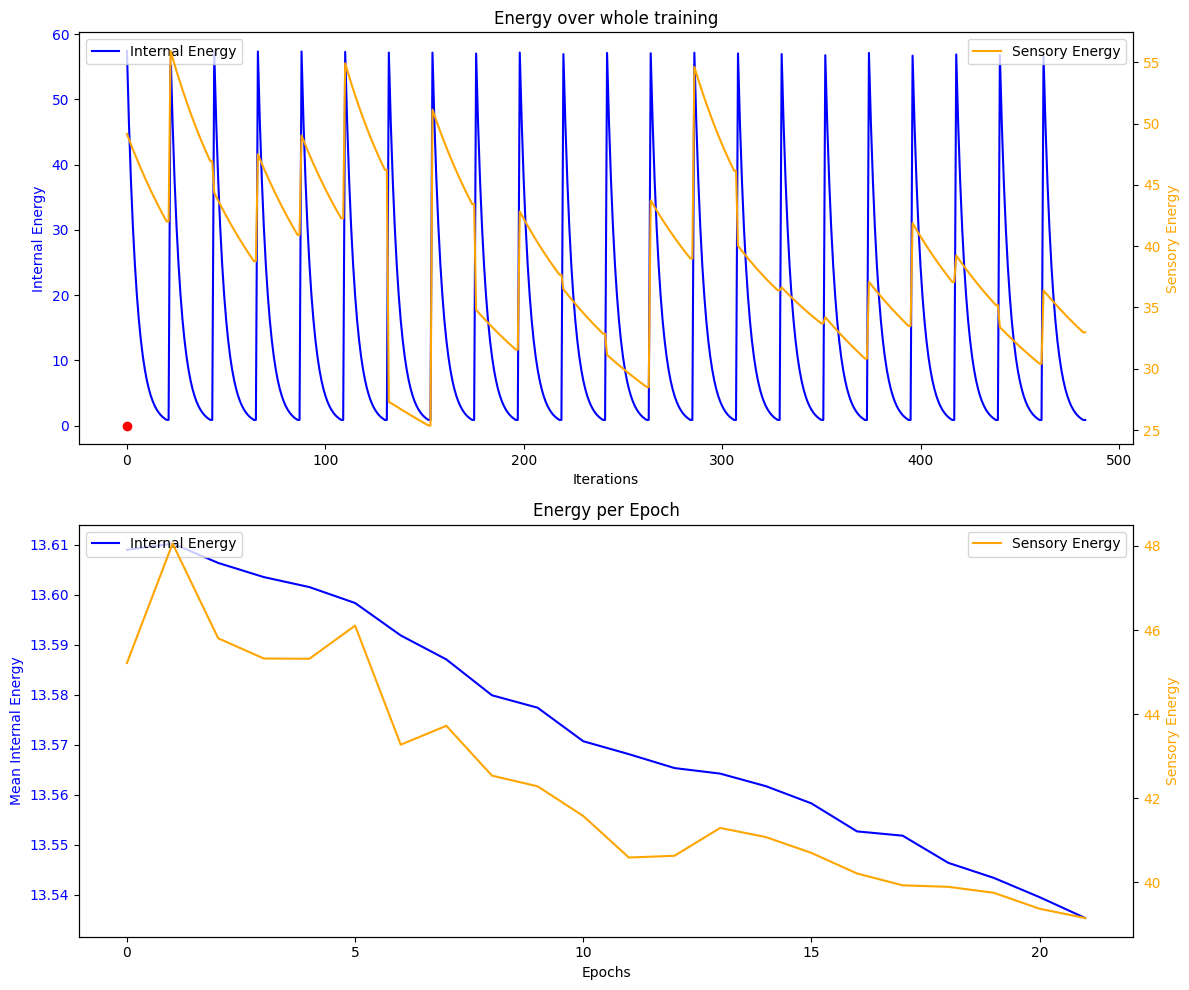

In [26]:
from helper.plot import plot_energy_during_training

import time 
torch.cuda.empty_cache()

training_labels = [] 
from collections import Counter


print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
    "internal_energy_per_batch_last": [],
    "sensory_energy_per_batch_last": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
# for epoch in range(1):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        training_labels.append(int(batch.y))
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            # model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])
            history["internal_energy_per_batch_last"].append(history_epoch["internal_energy_last"])
            history["sensory_energy_per_batch_last"].append(history_epoch["sensory_energy_last"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                print()
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 10:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
# plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


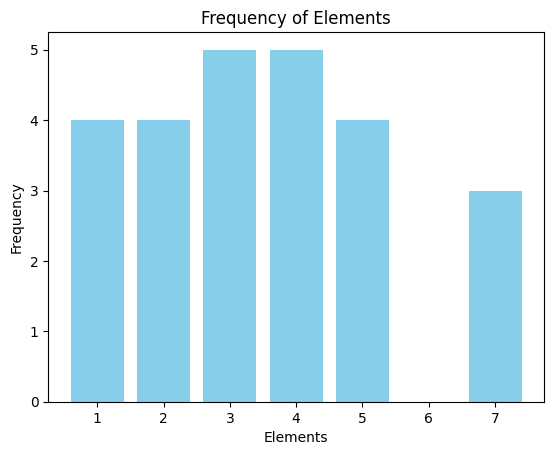

In [38]:

# Sample list
# Create a Counter object
element_counts = Counter(training_labels)

# Prepare data for plotting
labels = list(element_counts.keys())
counts = list(element_counts.values())

# Plot
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Frequency of Elements')
plt.show()

In [19]:
# assert 1 == 2 

In [20]:
# last_loss,  history_epoch["internal_energy_mean"]

tensor(0.1307)


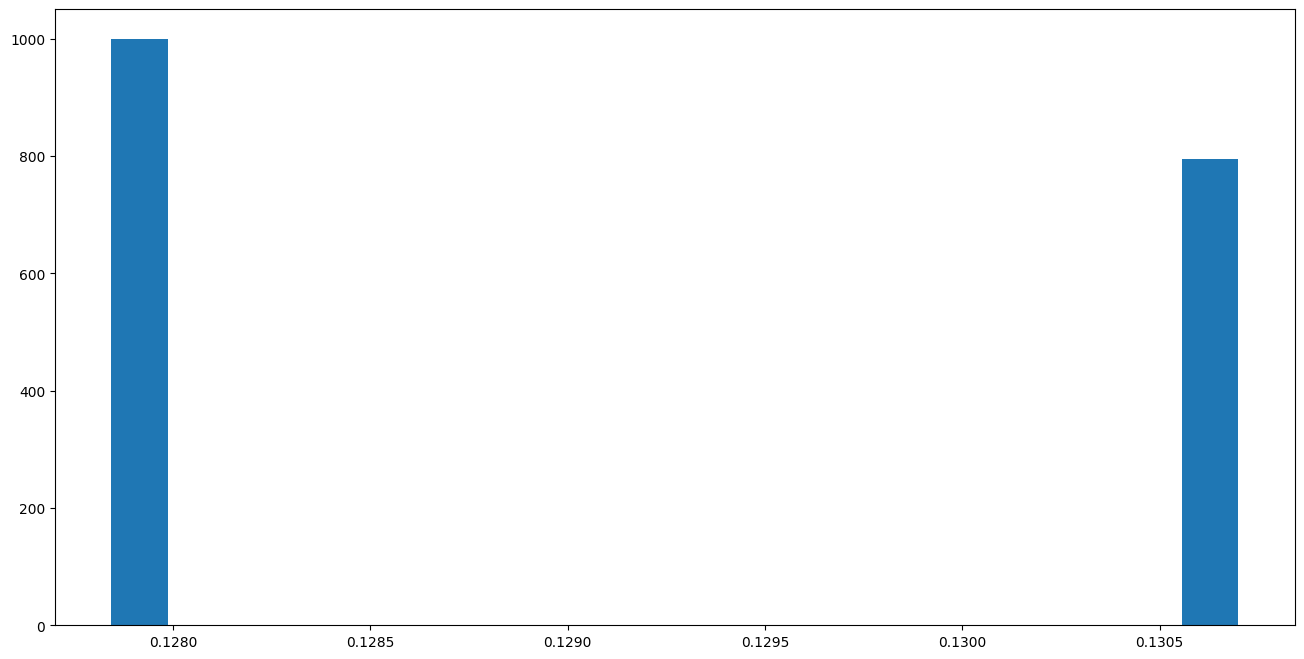

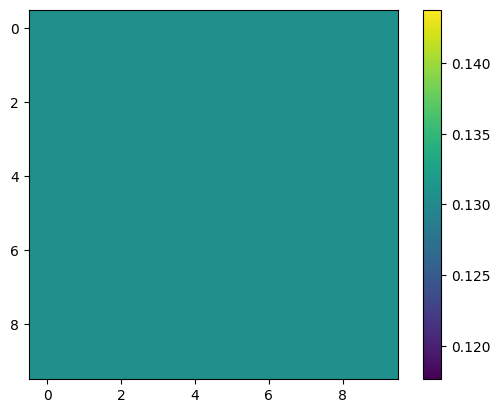

In [21]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:100].reshape(10,10))
    plt.colorbar()
    plt.show()

In [18]:
model.pc_conv1.use_bias

False

In [17]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:2000].reshape(40,50))
    plt.show()

In [23]:
# model_weights_path = "../scr/trained_models/best_models_weights/1/"
# model.save_weights(path=model_weights_path, overide=False)

In [24]:

#     for idx, (batch, clean) in enumerate():
#         torch.cuda.empty_cache()
        
#         try:
#             print("Label:", batch.y, "Input Shape:", batch.x.shape)
#             model.train()
#             # model.pc_conv1.restart_activity()

#             batch = batch.to(device)
#             history_epoch = model.learning(batch)

In [25]:
tmp = iter(train_loader)

batch = next(tmp)

Done for idx 26356
Done for idx 2248


In [26]:
batch[0]

DataBatch(x=[2294, 3, 1], edge_index=[2, 5260142], edge_attr=[5260142], y=[1], batch=[2294], ptr=[2])

In [53]:

# save_path = os.path.join(model_dir, 'parameter_info')
# model.save_weights(path=save_path) 

model.load_weights("../scr/trained_models/best_models_weights/1/", data_eg=batch[0])

Settng weights of self.pc_conv1
loaded weights matrix W
loaded edge index for the graphs
-------------Restarting activity (pred/errors/values)--------------
Done


In [30]:
if model.pc_conv1.use_convergence_monitor:
    model.pc_conv1.convergence_tracker.energy_tracker.energies

    print(model.pc_conv1.convergence_tracker.gradient_tracker.gradients)

[112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672]

In [ ]:
for idx, (batch, clean) in enumerate(train_loader):
    torch.cuda.empty_cache()
    
    img = batch.x[:,0][0:784].cpu()
    plt.imshow(img.view(28,28))

    break 

In [ ]:
import scipy.sparse as sp

# Extract the edge indices and weights
edge_index = model.pc_conv1.edge_index_single_graph.cpu().numpy()

S2S_    = []
rest_   = []
for weights in model.pc_conv1.w_log:

    # Create a sparse matrix using the edge indices and weights
    W_sparse = sp.coo_matrix((weights.cpu(), (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

    # Convert to dense for detailed visualization (if the graph is not too large)
    W = W_sparse.toarray()

    S2S = W[0:784, 0:784]
    S2S_.append(S2S.max()) #, S2S.min())

    rest = W[784:, 784:]
    rest_.append(rest.max()) # rest.min())


print(np.array(S2S_).mean())
print(np.array(rest_).mean())

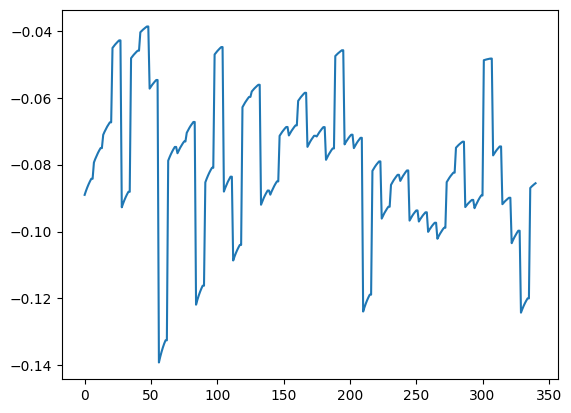

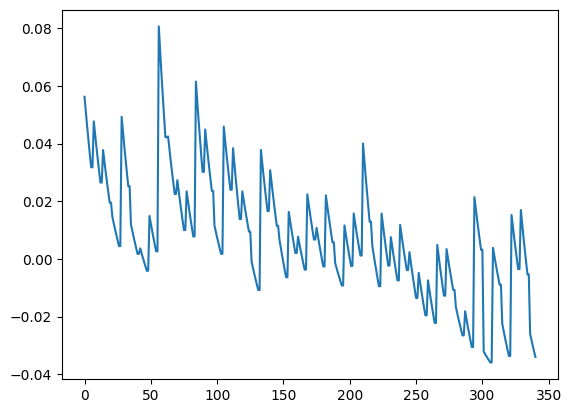

In [28]:
plt.plot(model.pc_conv1.energy_vals["mean_internal_energy_sign"][:])
plt.show()
plt.plot(model.pc_conv1.energy_vals["mean_sensory_energy_sign"][:])
plt.show()

In [ ]:
model.pc_conv1.energy_vals["internal_energy"][:]

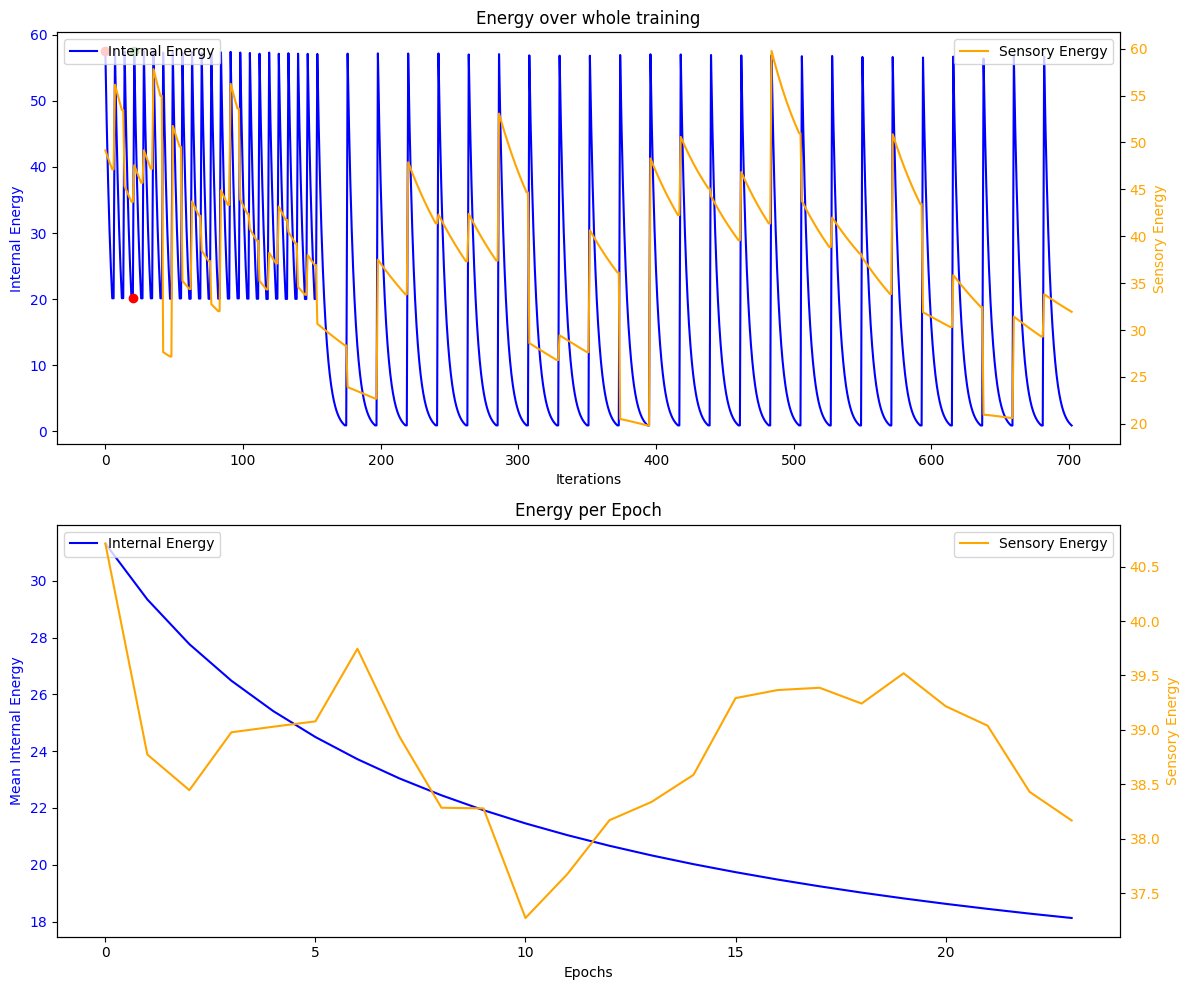

In [28]:
   
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                            model.pc_conv1.energy_vals["sensory_energy"][:],
                            history, 
                            point1=(0, model.pc_conv1.energy_vals["internal_energy"][0]),
                            point2=(model.pc_conv1.T, model.pc_conv1.energy_vals["internal_energy"][model.pc_conv1.T]),
                            point3=((model.pc_conv1.T)+1, model.pc_conv1.energy_vals["internal_energy"][(model.pc_conv1.T)+1]),
                            model_dir=None,
                            epoch=epoch)

In [ ]:
plt.hist(model.pc_conv1.weights.cpu().detach().flatten(), bins=10)
plt.show()

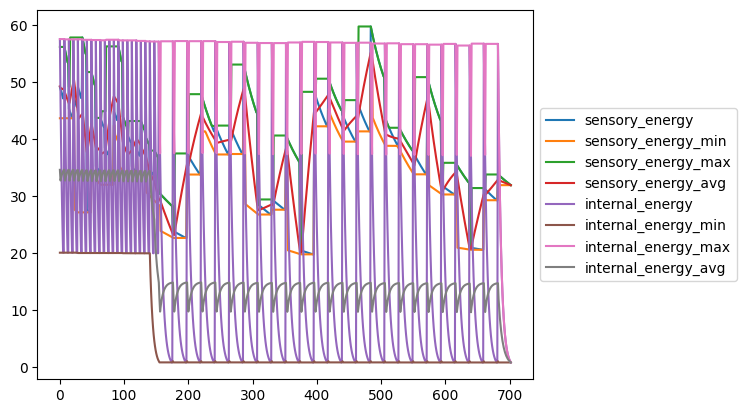

In [29]:
for tmp in ["sensory_energy","internal_energy"]:

    t = model.pc_conv1.energy_vals[tmp]
    plt.plot(t, label=f"{tmp}")

    v_min = []
    v_max = []
    v_avg = []

    for w in range(0, len(t)):

        window = t[w:w+model.pc_conv1.T]
        w_min = min(window)
        w_max = max(window)
        w_avg = sum(window)/len(window)

        # w_mean = 

        v_min.append(w_min)
        v_max.append(w_max)
        v_avg.append(w_avg)

    plt.plot(v_min, label=f"{tmp}_min")
    plt.plot(v_max, label=f"{tmp}_max")
    plt.plot(v_avg, label=f"{tmp}_avg")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

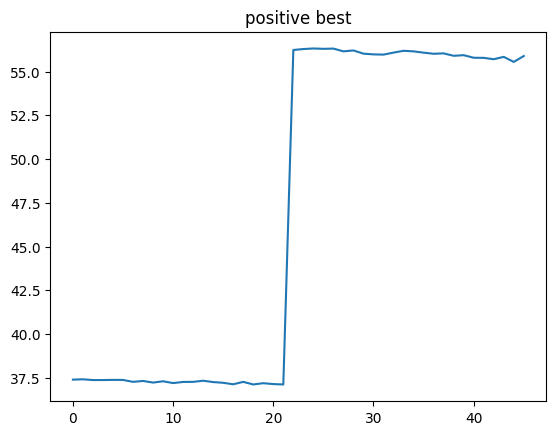

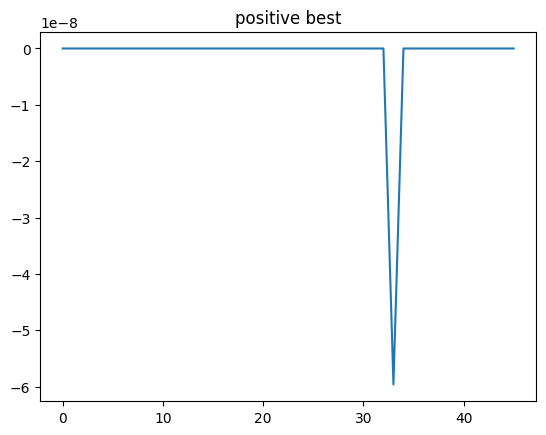

In [30]:
# weight_update_gain energy_drop

plt.plot(model.pc_conv1.energy_vals['energy_drop'])
plt.title("positive best")
plt.show()
plt.plot(model.pc_conv1.energy_vals['weight_update_gain'])
plt.title("positive best")
plt.show()


In [25]:
model.pc_conv1.energy_vals["energy_t0"]

[]

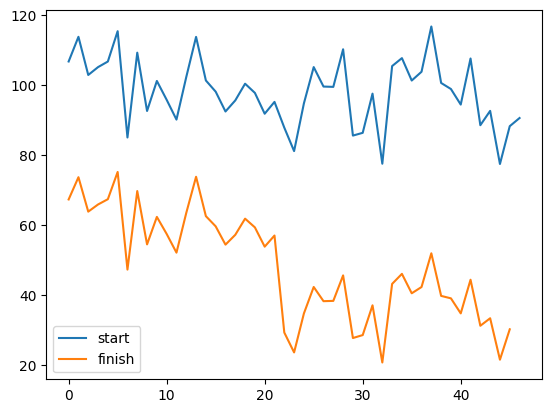

In [31]:
plt.plot(model.pc_conv1.energy_vals['energy_t0'], label="start")
plt.plot(model.pc_conv1.energy_vals['energy_tT'], label="finish")
plt.legend()
plt.show()


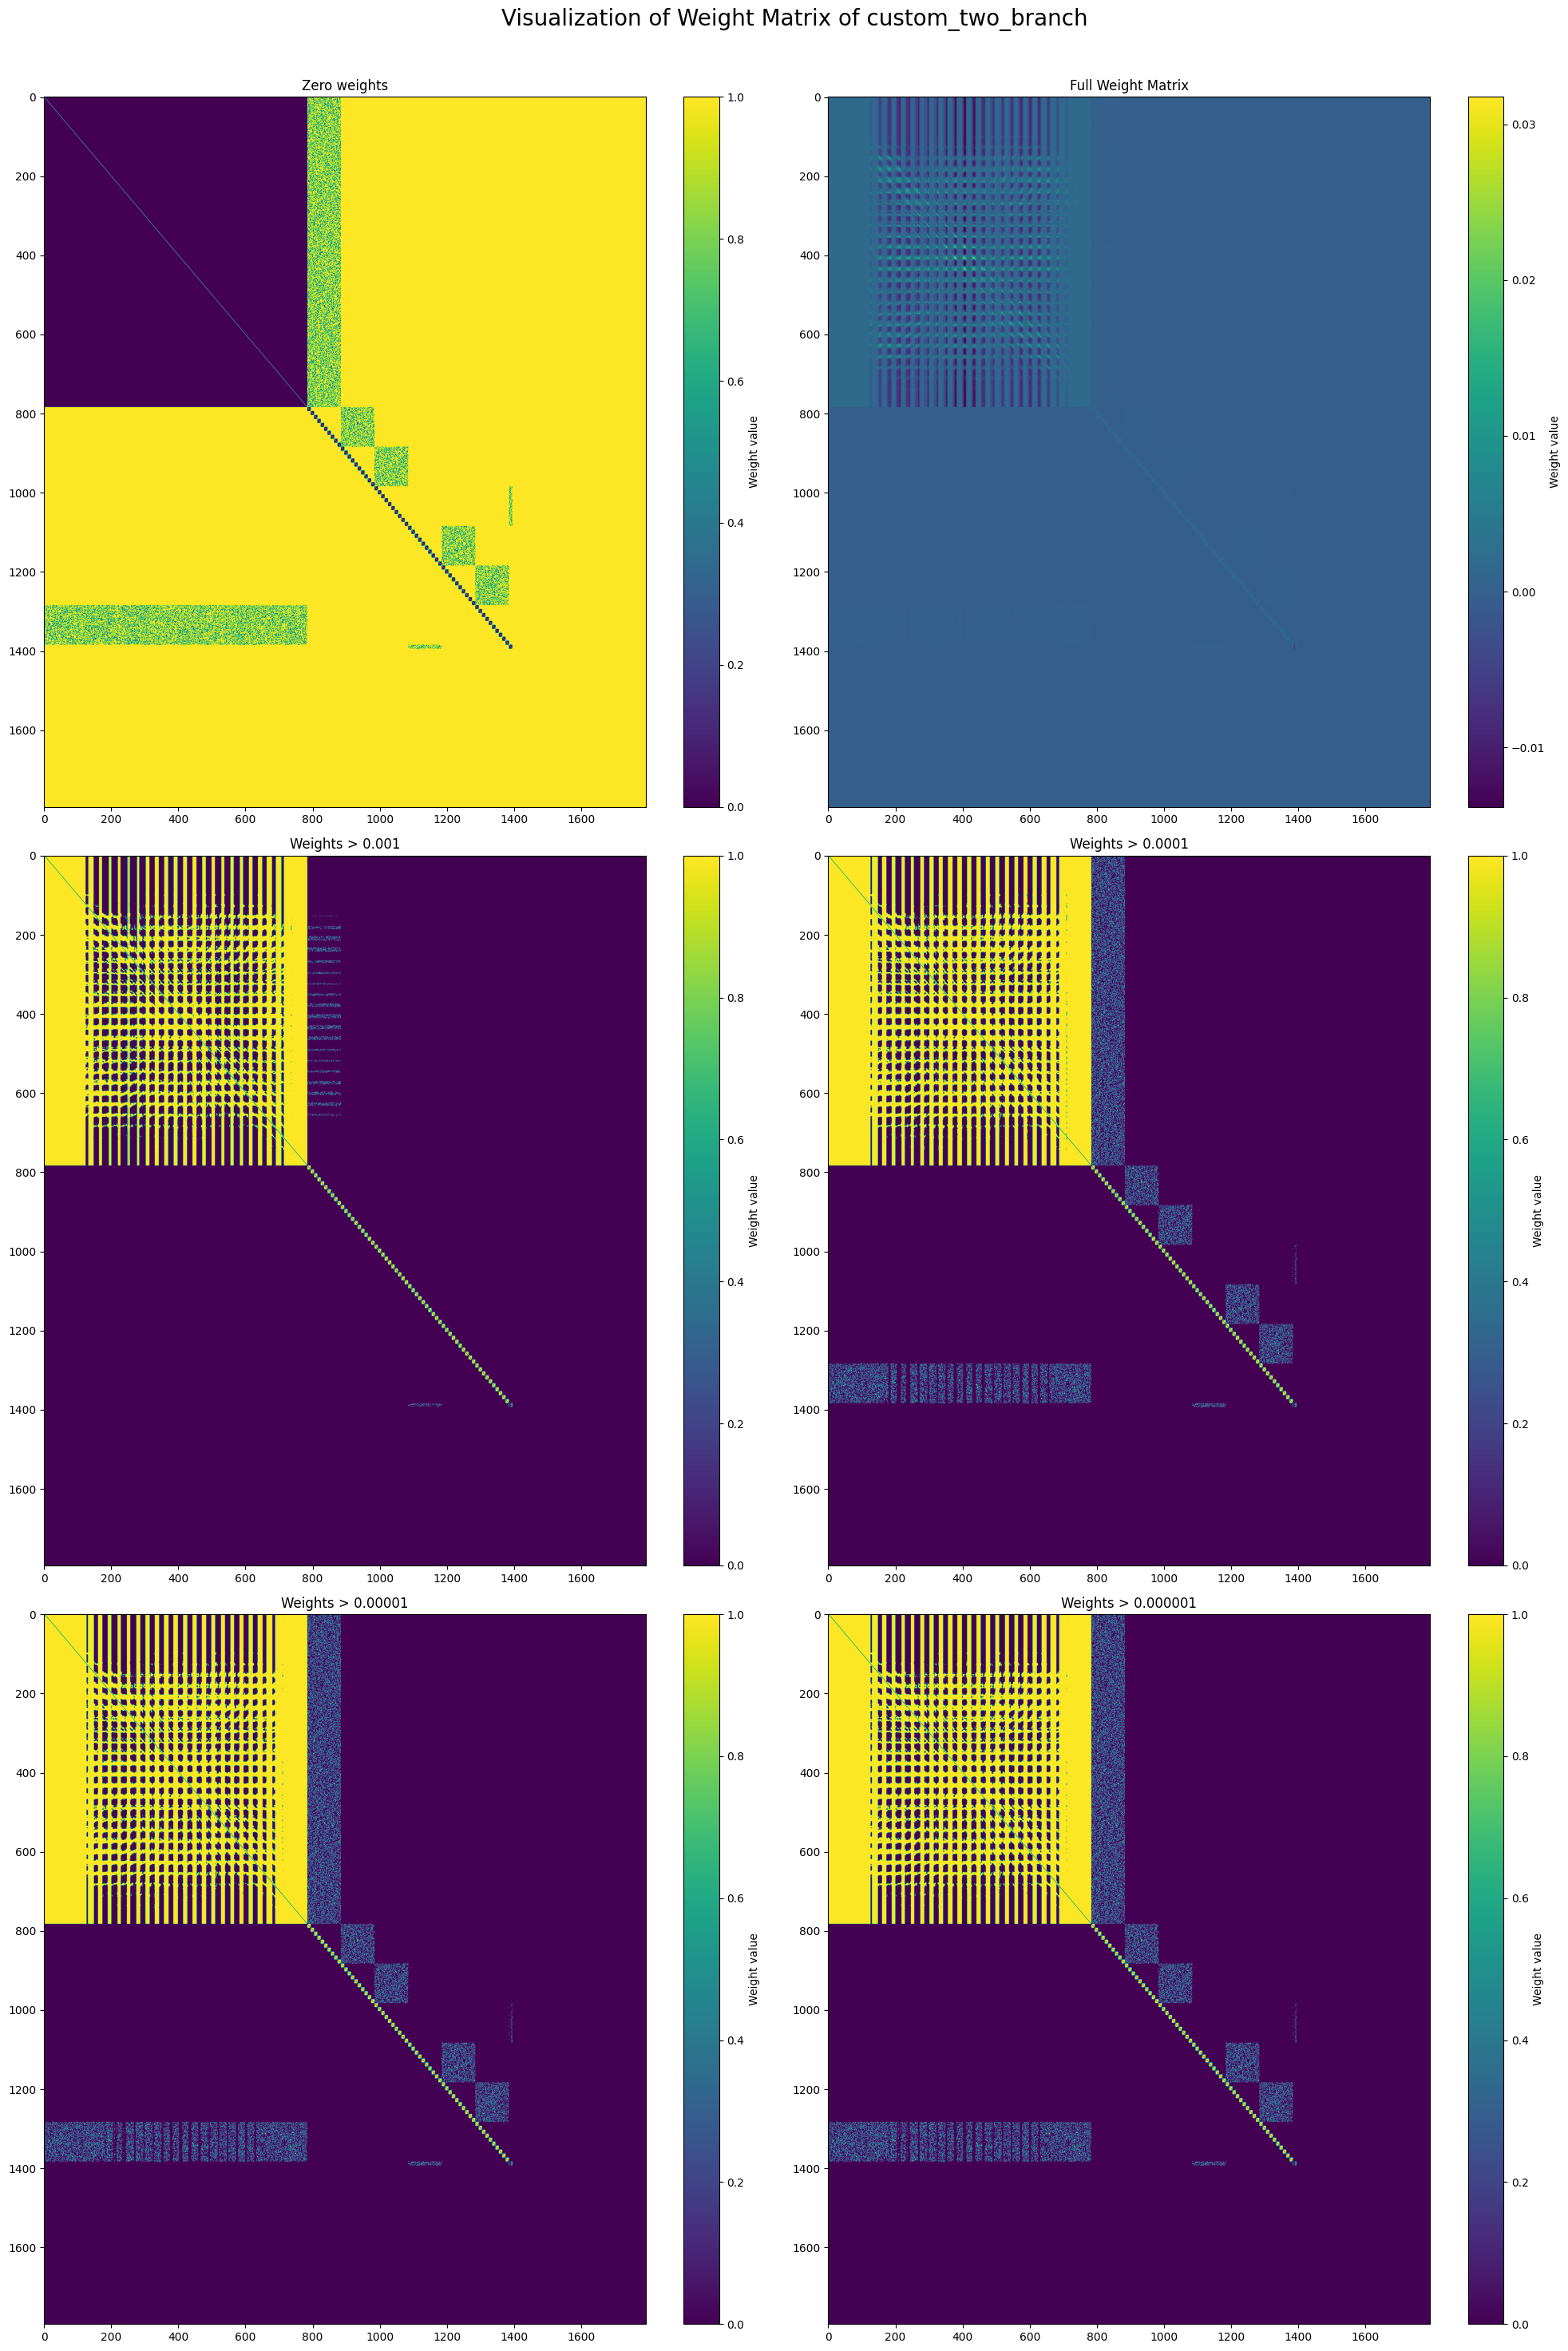

In [32]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

In [33]:
# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
#############################################################################################s############ 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)

mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [1, 2, 3, 4, 5, 7]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[   0,    1,    0,  ..., 1393, 1392, 1393],
        [   1,    0,    2,  ..., 1391, 1393, 1392]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 

In [35]:
# 
# plot_model_weights(model, model_dir=None)

In [36]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

In [34]:
def get_clean_images_by_label(mnist_train, num_images=10):
    """
    Extract num_images clean images for each label (0-9) from mnist_train.
    Returns a dictionary with labels as keys and a list of clean images as values.
    """
    clean_images = {label: [] for label in range(10)}

    for label in range(10):
        # Filter the indices for the current label
        class_indices = [i for i, lbl in enumerate(mnist_train.targets) if lbl == label]
        
        # Get the first num_images clean images for the current label
        clean_images[label] = [mnist_train[i][0].squeeze().numpy() for i in class_indices[:num_images]]

    return clean_images

# Example usage:
clean_images = get_clean_images_by_label(mnist_trainset, num_images=10)

model.trace(values=True, errors=True)


In [ ]:
model.pc_conv1.energy_vals["internal_energy_testing"]

        # self.pc_conv1.energy_vals["internal_energy_testing"] = []
        # self.pc_conv1.energy_vals["sensory_energy_testing"] = []

In [33]:
# model.enable_all_connections()

In [34]:
# # source_nodes = model.pc_conv1.edge_index[0]   # all i's 
# # target_nodes = model.pc_conv1.edge_index[1]   # all j's 

# # # Gather the corresponding errors and f_x values for each edge
# # # print("source_nodes shape", source_nodes.shape)
# # # print("errors shape", errors.shape)
# # # print("f_x shape", f_x.shape)
# # source_errors = model.pc_conv1.values[source_nodes].detach()    # get all e_i's 
# # target_fx = model.pc_conv1.values[target_nodes].detach()   

# # V = source_errors * target_fx

# V_p = V.reshape(model.pc_conv1.batchsize, model.pc_conv1.edge_index_single_graph.size(1)) 
# V_p.shape

In [ ]:
# Example matrices
# matrix_list = [np.random.rand(5, 5) for _ in range(10)]  # Create 10 random 5x5 matrices

# matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["values"] ] 
matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["preds"] ] 

matrix_list = [torch.ger(i, i) for i in matrix_list]

# Create diagonal matrices from each tensor
# matrix_list = [torch.diag(i) for i in matrix_list]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, ax = plt.subplots()

matrix_list_show = matrix_list[:20]

# Display the first matrix
im = ax.imshow(matrix_list_show[0], cmap='viridis')
cbar = plt.colorbar(im)  # Add the color bar

# Function to update the matrix in each frame
def update(frame):
    im.set_array(matrix_list_show[frame])  # Update the data for the new frame
    return [im]

# Prevent static display of imshow() after the animation
plt.close()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrix_list_show), blit=True, interval=500)

# Display the animation in the notebook
HTML(ani.to_jshtml())

In [55]:
import torch

# Create a copy of the current weights
w_copy = model.pc_conv1.weights.clone()

# plt.hist(w_copy.cpu().detach().flatten(), bins=10)
# plt.show()

In [56]:
# Define the threshold
threshold = 0.0001

# Apply the threshold: set weights with absolute values below the threshold to zero
new_w = torch.where(torch.abs(w_copy) < threshold, torch.tensor(0.0, device=w_copy.device), w_copy)

# Assign the thresholded weights back to the model
model.pc_conv1.weights.data = new_w

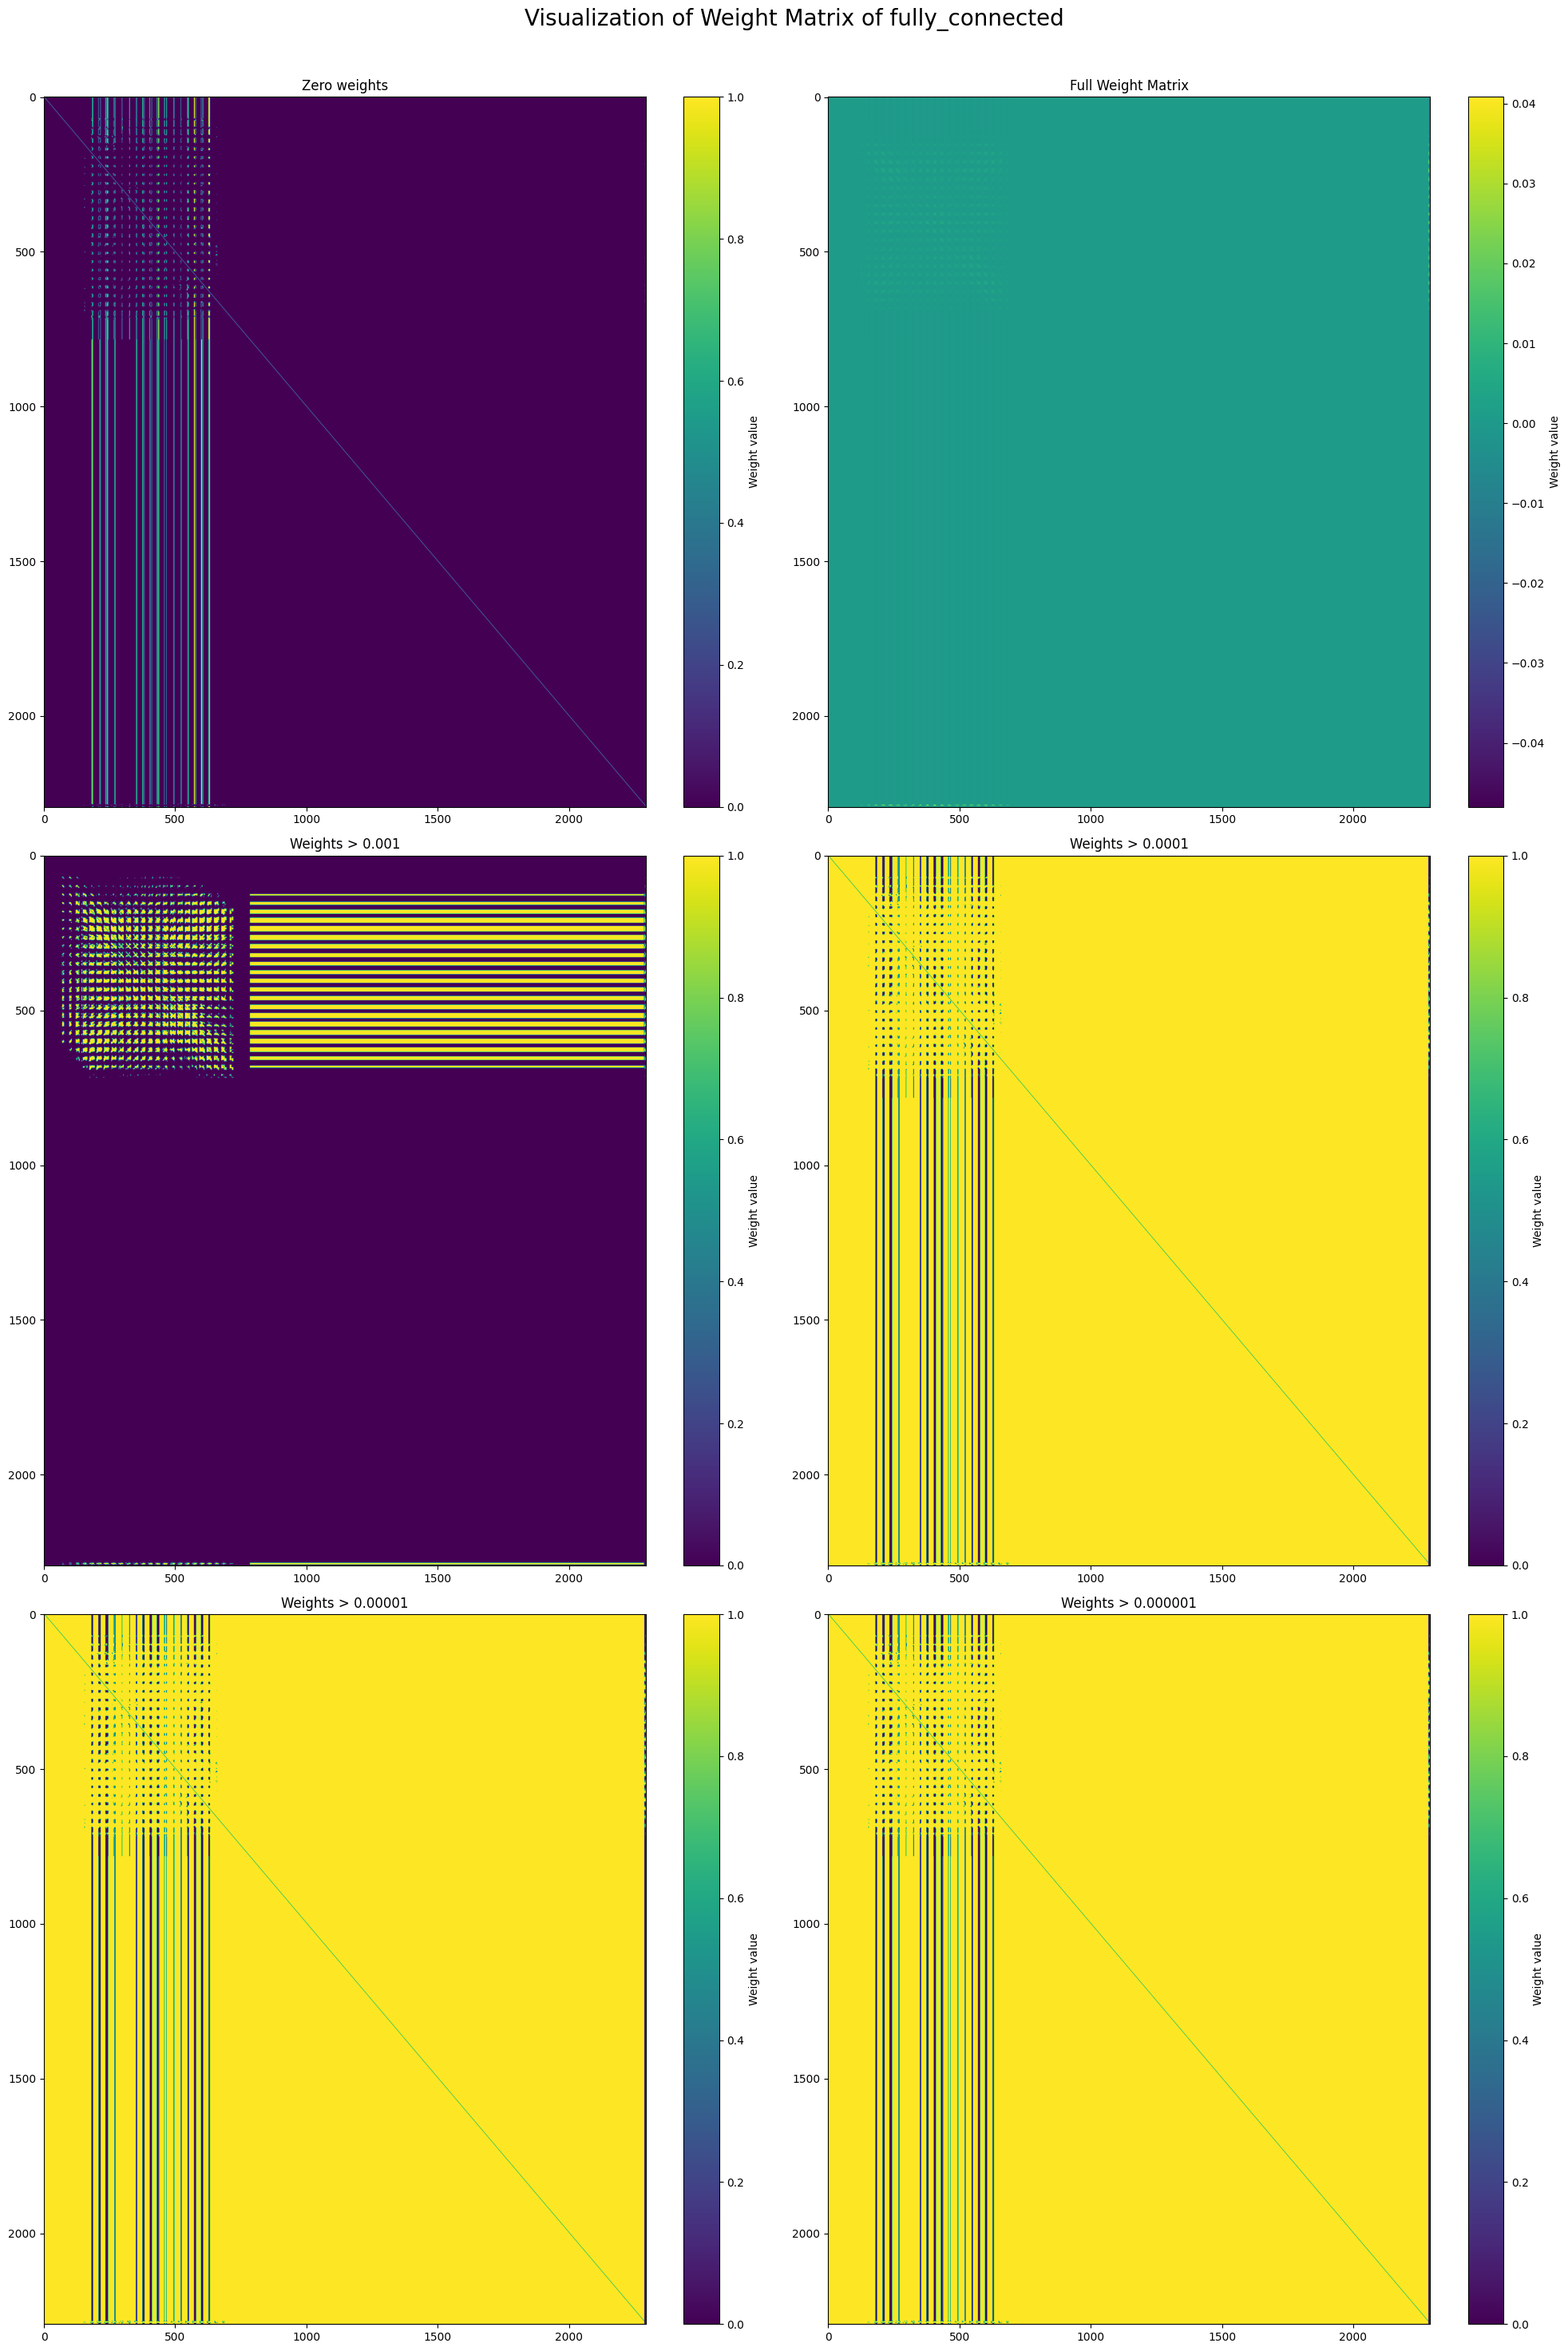

In [57]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

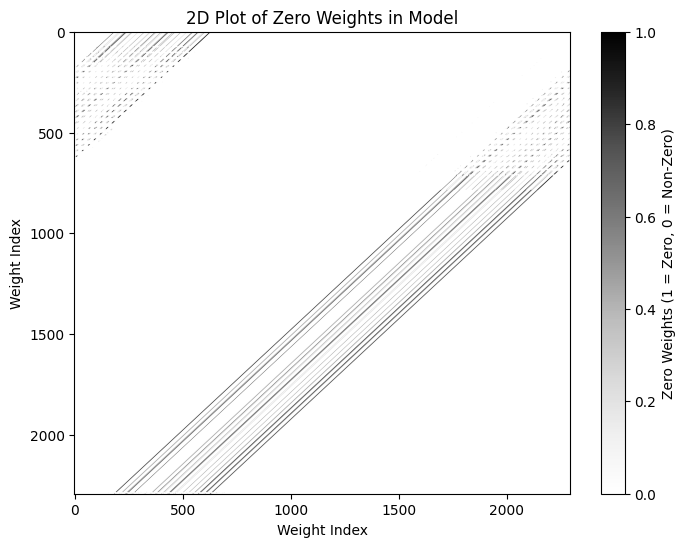

In [58]:
weights = model.pc_conv1.weights.detach().cpu().numpy()

# Identify zero weights and create a mask
zero_weights_mask = (weights == 0).astype(int)  # 1 where weight is zero, 0 elsewhere

# Plot the zero weights as a 2D heatmap
plt.figure(figsize=(8, 6))
plt.imshow(zero_weights_mask.reshape(int(len(weights)**0.5), -1), cmap="Greys", aspect="auto")
plt.colorbar(label="Zero Weights (1 = Zero, 0 = Non-Zero)")
plt.title("2D Plot of Zero Weights in Model")
plt.xlabel("Weight Index")
plt.ylabel("Weight Index")
plt.show()


vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([1794, 1])
AAAAAAAdAAAAA
model.pc_conv1.values.shape torch.Size([1794, 1])
CHECK 1  tensor([[0.1305],
        [0.1607],
        [0.1628],
        [0.1696],
        [0.1821],
        [0.1765],
        [0.1310],
        [0.1634],
        [0.1312],
        [0.1308]], device='cuda:0')
No vmin vmax
Done for idx 5455
tensor([7])
torch.Size([1794, 3, 1])
CHECK 2  tensor([[0.1305],
        [0.1607],
        [0.1628],
        [0.1696],
        [0.1821],
        [0.1765],
        [0.1310],
        [0.1634],
        [0.1312],
        [0.1308]], device='cuda:0')
CHECK 3  tensor([[0.1305],
        [0.1607],
        [0.1628],
        [0.1696],
        [0.1821],
        [0.1765],
        [0.1310],
        [0.1634],
        [0.1312],
        [0.1308]], device='cuda:0')
labels model tensor([[0.],
        

Total energy at time 5 / 90 {'internal_energy': 41.29995346069336, 'supervised_energy': 0.519920289516449, 'sensory_energy': 31.20261573791504, 'energy_total': 72.58798217773438},:   6%|▌         | 5/90 [00:00<00:01, 47.00it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 10 / 90 {'internal_energy': 14.59870719909668, 'supervised_energy': 0.1750188171863556, 'sensory_energy': 31.022863388061523, 'energy_total': 45.70698547363281},:  11%|█         | 10/90 [00:00<00:01, 47.25it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 16 / 90 {'internal_energy': 4.176770210266113, 'supervised_energy': 0.04782959073781967, 'sensory_energy': 30.90910530090332, 'energy_total': 35.171287536621094},:  17%|█▋        | 15/90 [00:00<00:01, 46.88it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 19 / 90 {'internal_energy': 2.230353355407715, 'supervised_energy': 0.025082284584641457, 'sensory_energy': 30.87525749206543, 'energy_total': 33.19102478027344},:  17%|█▋        | 15/90 [00:00<00:01, 46.88it/s]  

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 25 / 90 {'internal_energy': 0.6332328915596008, 'supervised_energy': 0.0069367666728794575, 'sensory_energy': 30.833126068115234, 'energy_total': 31.551769256591797},:  28%|██▊       | 25/90 [00:00<00:01, 45.43it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 29 / 90 {'internal_energy': 0.27254605293273926, 'supervised_energy': 0.002956383628770709, 'sensory_energy': 30.81674575805664, 'energy_total': 31.17470359802246},:  28%|██▊       | 25/90 [00:00<00:01, 45.43it/s]  

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 36 / 90 {'internal_energy': 0.06218087673187256, 'supervised_energy': 0.0006696924101561308, 'sensory_energy': 30.800338745117188, 'energy_total': 30.94792938232422},:  39%|███▉      | 35/90 [00:00<00:01, 45.45it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 39 / 90 {'internal_energy': 0.033240195363759995, 'supervised_energy': 0.00035545474383980036, 'sensory_energy': 30.79621124267578, 'energy_total': 30.91486358642578},:  39%|███▉      | 35/90 [00:00<00:01, 45.45it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 45 / 90 {'internal_energy': 0.010209248401224613, 'supervised_energy': 0.0001006740058073774, 'sensory_energy': 30.79094696044922, 'energy_total': 30.88656997680664},:  50%|█████     | 45/90 [00:00<00:01, 44.66it/s]  

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 49 / 90 {'internal_energy': 0.005344541743397713, 'supervised_energy': 4.358865407994017e-05, 'sensory_energy': 30.788860321044922, 'energy_total': 30.879619598388672},:  50%|█████     | 45/90 [00:01<00:01, 44.66it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 54 / 90 {'internal_energy': 0.0031789415515959263, 'supervised_energy': 1.5375077055068687e-05, 'sensory_energy': 30.78720474243164, 'energy_total': 30.875795364379883},:  56%|█████▌    | 50/90 [00:01<00:00, 44.74it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 59 / 90 {'internal_energy': 0.0025841551832854748, 'supervised_energy': 5.448563115351135e-06, 'sensory_energy': 30.786209106445312, 'energy_total': 30.874204635620117},:  61%|██████    | 55/90 [00:01<00:00, 44.40it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 62 / 90 {'internal_energy': 0.002492033876478672, 'supervised_energy': 2.9301834274519933e-06, 'sensory_energy': 30.78581428527832, 'energy_total': 30.87371826171875},:  67%|██████▋   | 60/90 [00:01<00:00, 42.98it/s]   

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 67 / 90 {'internal_energy': 0.0024834154173731804, 'supervised_energy': 1.045634007823537e-06, 'sensory_energy': 30.78537368774414, 'energy_total': 30.873268127441406},:  72%|███████▏  | 65/90 [00:01<00:00, 42.18it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 71 / 90 {'internal_energy': 0.0025158850476145744, 'supervised_energy': 4.5986297436684254e-07, 'sensory_energy': 30.78514862060547, 'energy_total': 30.873077392578125},:  78%|███████▊  | 70/90 [00:01<00:00, 41.55it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 76 / 90 {'internal_energy': 0.0025586234405636787, 'supervised_energy': 1.652469023838421e-07, 'sensory_energy': 30.78497314453125, 'energy_total': 30.872943878173828},:  83%|████████▎ | 75/90 [00:01<00:00, 41.92it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 80 / 90 {'internal_energy': 0.0025856285355985165, 'supervised_energy': 7.304736016067181e-08, 'sensory_energy': 30.784881591796875, 'energy_total': 30.872880935668945},:  83%|████████▎ | 75/90 [00:01<00:00, 41.92it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 84 / 90 {'internal_energy': 0.0026055166963487864, 'supervised_energy': 3.235714274296697e-08, 'sensory_energy': 30.78482437133789, 'energy_total': 30.872840881347656},:  93%|█████████▎| 84/90 [00:01<00:00, 38.82it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 88 / 90 {'internal_energy': 0.002619539387524128, 'supervised_energy': 1.4356759336919822e-08, 'sensory_energy': 30.7847843170166, 'energy_total': 30.87281608581543},:  98%|█████████▊| 88/90 [00:02<00:00, 38.41it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
Final internal energy (t=T): 0.0026248227804899216
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.6785852 -0.4177807
Denoised val 1.0 0.0
tensor([0.1305, 0.1607, 0.1628, 0.1697, 0.1821, 0.1766, 0.1310, 0.1634, 0.1312,
        0.1309], device='cuda:0')
tensor([0.1305, 0.1607, 0.1628, 0.1697, 0.1821, 0.1766, 0.1310, 0.1634, 0.1312,
        0.1309], device='cuda:0')
tensor([[0.1305],
        [0.1607],
        [0.1628],
        [0.1697],
        [0.1821],
        [0.1766],
        [0.1310],
        [0.1634],
        [0.1312],
        [0.1309]], device='cuda:0')
tensor([0.0977, 0.1007, 0.1009, 0.1016, 0.1028, 0.1023, 0.0977, 0.1009, 0.0977,
        0.0977], device='cuda:0')
tensor(4)


KeyError: 'num_wandb_img_log'

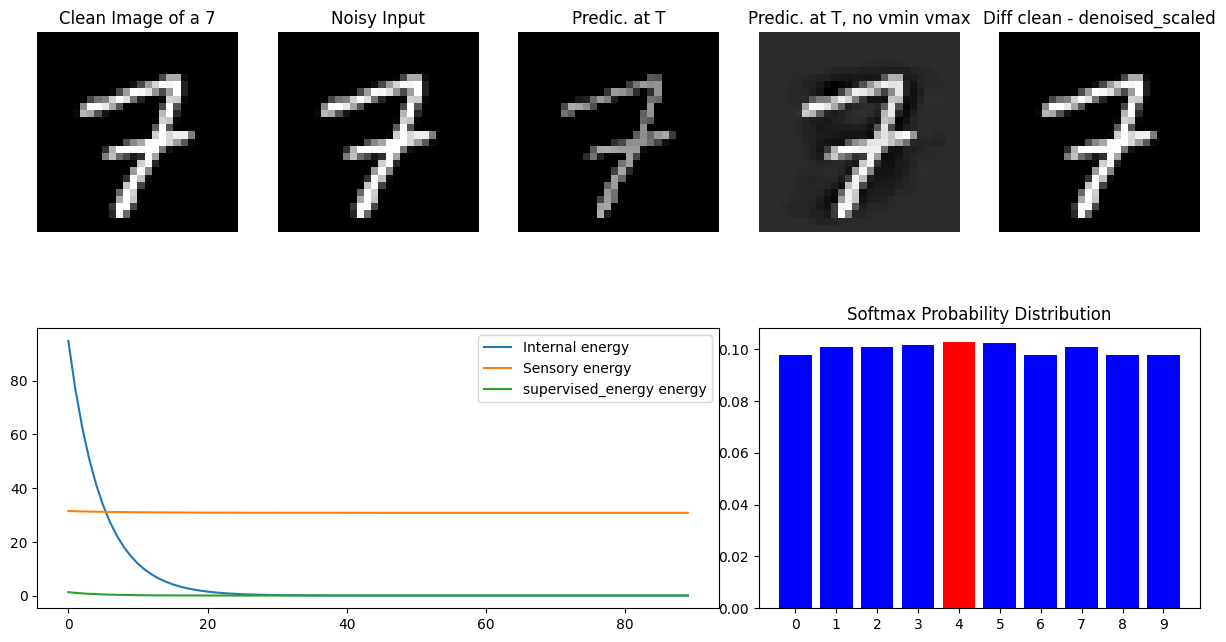

In [37]:

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":90,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

IMPORTANT SEE OLD OCCLUSION func; 
-------------Restarting activity (pred/errors/values)--------------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task generation--------------
Occulusion model.pc_conv1.values.shape torch.Size([1794, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 1065
tensor([4])
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
aaa testing
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')


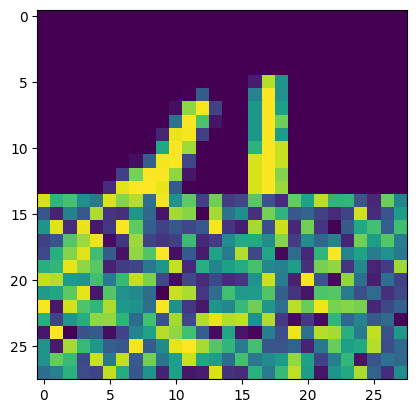

Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
-------------Restarting activity (pred/errors/values)--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 107.11955261230469


Total energy at time 8 / 50 {'internal_energy': 20.443359375, 'supervised_energy': 0.08231235295534134, 'sensory_energy': 32.66456985473633, 'energy_total': 54.12461853027344},:  10%|█         | 5/50 [00:00<00:00, 48.43it/s]       

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 10 / 50 {'internal_energy': 13.501029968261719, 'supervised_energy': 0.054317835718393326, 'sensory_energy': 30.381166458129883, 'energy_total': 44.898887634277344},:  20%|██        | 10/50 [00:00<00:00, 46.63it/s]

torch.Size([1794])


Total energy at time 17 / 50 {'internal_energy': 3.151792526245117, 'supervised_energy': 0.01269468478858471, 'sensory_energy': 26.0538330078125, 'energy_total': 30.222312927246094},:  30%|███       | 15/50 [00:00<00:00, 42.30it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 18 / 50 {'internal_energy': 2.559354305267334, 'supervised_energy': 0.010315850377082825, 'sensory_energy': 25.70354461669922, 'energy_total': 29.279586791992188},:  30%|███       | 15/50 [00:00<00:00, 42.30it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 26 / 50 {'internal_energy': 0.481685996055603, 'supervised_energy': 0.001964718569070101, 'sensory_energy': 23.99186134338379, 'energy_total': 25.490238189697266},:  50%|█████     | 25/50 [00:00<00:00, 42.15it/s]   

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 28 / 50 {'internal_energy': 0.3168703317642212, 'supervised_energy': 0.0012985640205442905, 'sensory_energy': 23.750886917114258, 'energy_total': 25.08444595336914},:  50%|█████     | 25/50 [00:00<00:00, 42.15it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 34 / 50 {'internal_energy': 0.09029009193181992, 'supervised_energy': 0.00037540055927820504, 'sensory_energy': 23.258071899414062, 'energy_total': 24.36505126953125},:  60%|██████    | 30/50 [00:00<00:00, 41.25it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 36 / 50 {'internal_energy': 0.059627704322338104, 'supervised_energy': 0.0002483261050656438, 'sensory_energy': 23.146799087524414, 'energy_total': 24.22311782836914},:  70%|███████   | 35/50 [00:00<00:00, 40.16it/s]

torch.Size([1794])
torch.Size([1794])


Total energy at time 43 / 50 {'internal_energy': 0.015062253922224045, 'supervised_energy': 5.8559828175930306e-05, 'sensory_energy': 22.882083892822266, 'energy_total': 23.913835525512695},:  80%|████████  | 40/50 [00:01<00:00, 40.26it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 44 / 50 {'internal_energy': 0.012638751417398453, 'supervised_energy': 4.7649809857830405e-05, 'sensory_energy': 22.855684280395508, 'energy_total': 23.885011672973633},:  80%|████████  | 40/50 [00:01<00:00, 40.26it/s]

torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
Final internal energy (t=T): 0.005594282411038876
Inference completed.
QUery by condition or query by init
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')
Predic. at T, no vmin vmax 0.7549438 -0.28946728
Denoised val 1.0 0.0
generation_task_4.png
CHECK tensor([[0.9289],
        [0.4333],
        [0.8850],
        [0.0210],
        [0.6515],
        [0.2185],
        [0.6497],
        [0.0495],
        [0.2649],
        [0.5189]], device='cuda:0')


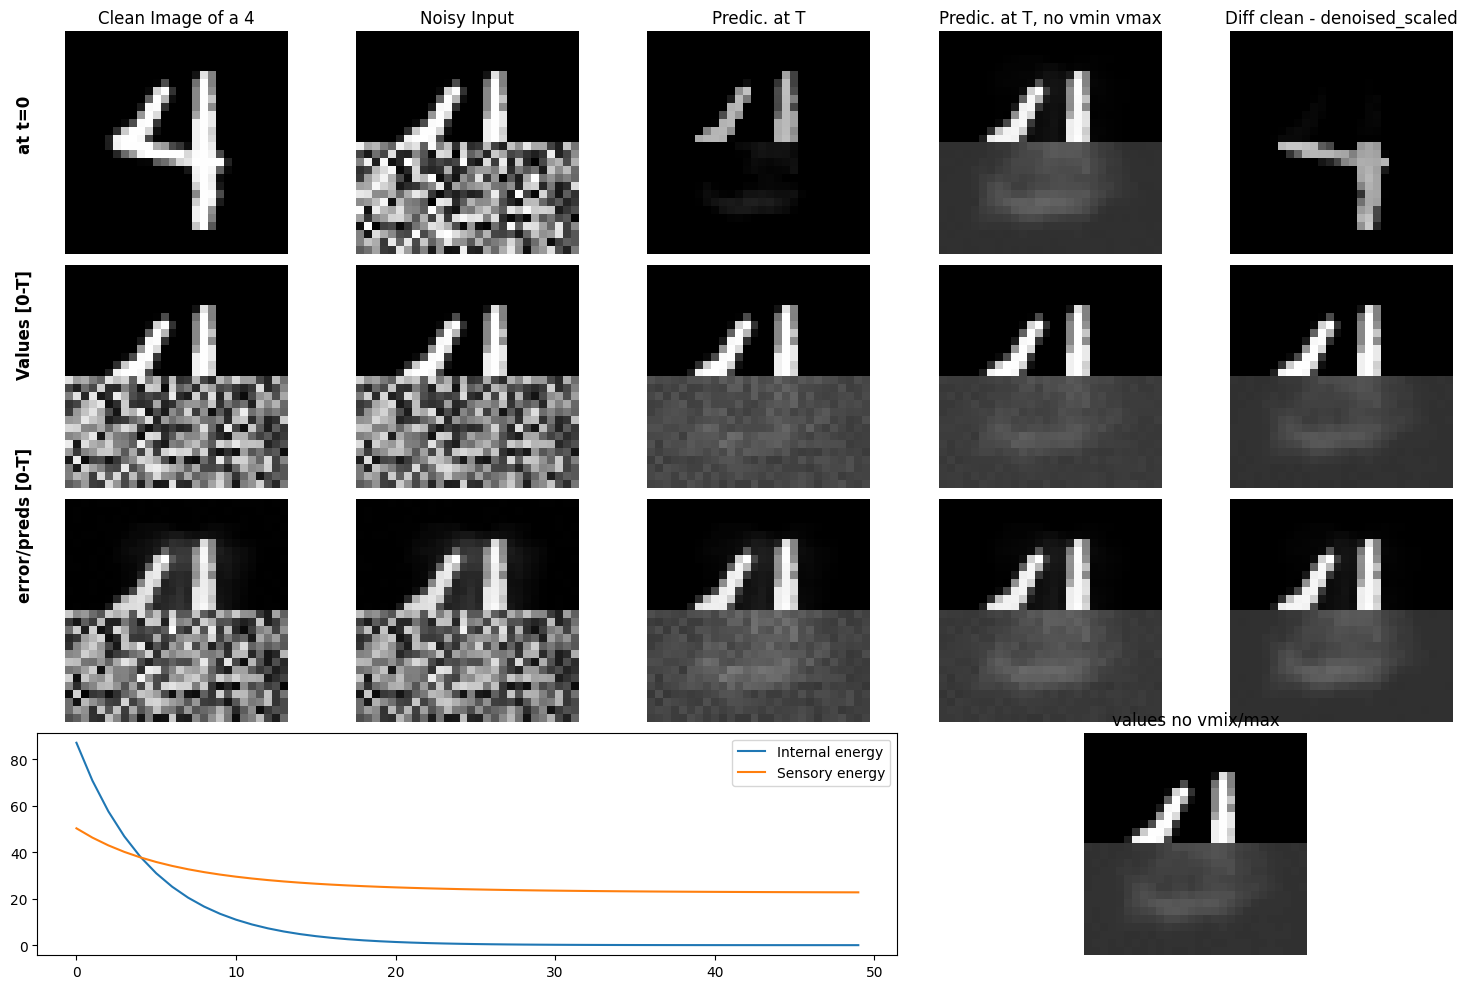

In [32]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": None,
    "T": 50,
    "supervised_learning":False, 
    "num_samples": 1,
    "add_sens_noise": True,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)

In [ ]:
MSE_values_occ

In [ ]:


######################################################################################################### 

######################################################################################################### 

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

In [15]:
# model.Disable_connection(from_indices=sensory_indices, 
#                          to_indices=supervision_indices)

In [ ]:
# model.enable_all_connections()

In [ ]:
plt.imshow(model.pc_conv1.trace['preds'][0][0:784].view(28,28).cpu())
plt.show()

In [ ]:
tr = model.pc_conv1.trace["values"]
len(tr)

In [ ]:
model.pc_conv1.mode

In [28]:
a = model.pc_conv1.weights.cpu().detach()

print(a.min(), a.max(), a.mean())

tensor(-0.0180) tensor(0.0381) tensor(0.0010)


-------------Restarting activity (pred/errors/values)--------------
-------------Restarting activity (pred/errors/values)--------------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode testing--------------
-------------task generation--------------
model.pc_conv1.values.shape torch.Size([1794, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 2015
tensor([4])
torch.Size([1794, 3, 1])
omitting setting sensory nodes
ZZZZZZZZZZZZZZZZZZZZZZZ


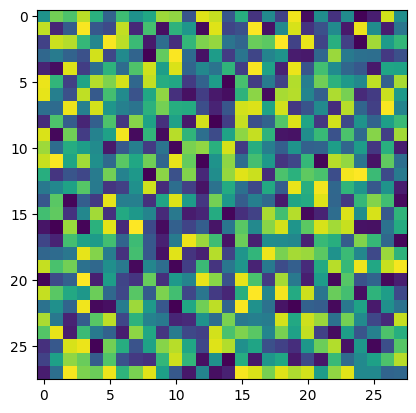

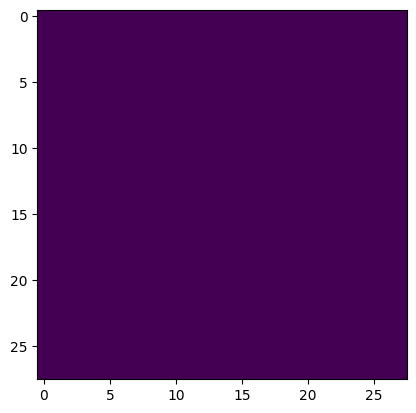

labels before torch.Size([10]) tensor([0.7513, 0.0000, 0.3913, 0.4530, 0.0000, 0.7435, 0.5231, 0.0000, 0.4712,
        0.6614], device='cuda:0')
labels after tensor([0.7513, 0.0000, 0.3913, 0.4530, 0.0000, 0.7435, 0.5231, 0.0000, 0.4712,
        0.6614], device='cuda:0')
tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
labels model tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
aaa testing
CHECK tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


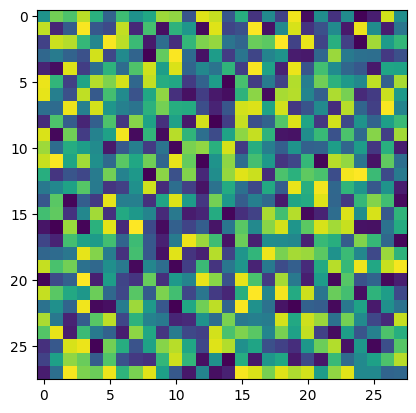

Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
Initial internal energy (t=0): 104.83819580078125


Total energy at time 7 / 100 {'internal_energy': 25.089384078979492, 'supervised_energy': 0.299211323261261, 'sensory_energy': 607.681884765625, 'energy_total': 632.8566284179688},:   4%|▍         | 4/100 [00:00<00:02, 38.59it/s]  

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 8 / 100 {'internal_energy': 20.515729904174805, 'supervised_energy': 0.24089710414409637, 'sensory_energy': 723.3677978515625, 'energy_total': 743.9689331054688},:   4%|▍         | 4/100 [00:00<00:02, 38.59it/s]

torch.Size([1794])


Total energy at time 16 / 100 {'internal_energy': 4.214323043823242, 'supervised_energy': 0.04297245293855667, 'sensory_energy': 2836.31494140625, 'energy_total': 2840.614501953125},:  14%|█▍        | 14/100 [00:00<00:02, 39.11it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 17 / 100 {'internal_energy': 3.4774441719055176, 'supervised_energy': 0.034682124853134155, 'sensory_energy': 3367.135986328125, 'energy_total': 3370.69873046875},:  14%|█▍        | 14/100 [00:00<00:02, 39.11it/s]

torch.Size([1794])


Total energy at time 24 / 100 {'internal_energy': 1.2203177213668823, 'supervised_energy': 0.007783775217831135, 'sensory_energy': 9966.4892578125, 'energy_total': 9967.794921875},:  22%|██▏       | 22/100 [00:00<00:02, 37.67it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 25 / 100 {'internal_energy': 1.1553300619125366, 'supervised_energy': 0.0062929363921284676, 'sensory_energy': 11391.88671875, 'energy_total': 11393.126953125},:  22%|██▏       | 22/100 [00:00<00:02, 37.67it/s]

torch.Size([1794])


Total energy at time 32 / 100 {'internal_energy': 2.097710132598877, 'supervised_energy': 0.0014287015656009316, 'sensory_energy': 26928.068359375, 'energy_total': 26930.25},:  30%|███       | 30/100 [00:00<00:01, 37.65it/s]        

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 33 / 100 {'internal_energy': 2.4948604106903076, 'supervised_energy': 0.001156906597316265, 'sensory_energy': 30265.1015625, 'energy_total': 30267.68359375},:  30%|███       | 30/100 [00:00<00:01, 37.65it/s]

torch.Size([1794])


Total energy at time 39 / 100 {'internal_energy': 7.772651672363281, 'supervised_energy': 0.0003274985938332975, 'sensory_energy': 60205.796875, 'energy_total': 60213.65625},:  38%|███▊      | 38/100 [00:01<00:01, 36.11it/s]      

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 40 / 100 {'internal_energy': 9.40262222290039, 'supervised_energy': 0.0002655539137776941, 'sensory_energy': 67412.4453125, 'energy_total': 67421.921875},:  38%|███▊      | 38/100 [00:01<00:01, 36.11it/s]

torch.Size([1794])


Total energy at time 46 / 100 {'internal_energy': 27.50627899169922, 'supervised_energy': 7.577052747365087e-05, 'sensory_energy': 131977.59375, 'energy_total': 132005.1875},:  46%|████▌     | 46/100 [00:01<00:01, 35.27it/s]     

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 54 / 100 {'internal_energy': 86.84064483642578, 'supervised_energy': 1.4366247341968119e-05, 'sensory_energy': 318632.0625, 'energy_total': 318718.9375},:  54%|█████▍    | 54/100 [00:01<00:01, 35.22it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 62 / 100 {'internal_energy': 209.0408935546875, 'supervised_energy': 2.7392659376346273e-06, 'sensory_energy': 761523.8125, 'energy_total': 761732.9375},:  62%|██████▏   | 62/100 [00:01<00:01, 34.81it/s]  

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 70 / 100 {'internal_energy': 464.775390625, 'supervised_energy': 5.164613412489416e-07, 'sensory_energy': 1804181.625, 'energy_total': 1804646.5},:  70%|███████   | 70/100 [00:01<00:00, 34.27it/s]       

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 77 / 100 {'internal_energy': 954.279052734375, 'supervised_energy': 1.1499771801481984e-07, 'sensory_energy': 3822101.0, 'energy_total': 3823055.25},:  74%|███████▍  | 74/100 [00:02<00:00, 34.06it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 82 / 100 {'internal_energy': 1616.876953125, 'supervised_energy': 3.817897464841735e-08, 'sensory_energy': 6515271.5, 'energy_total': 6516888.0},:  82%|████████▏ | 82/100 [00:02<00:00, 29.31it/s]    

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 87 / 100 {'internal_energy': 2749.635498046875, 'supervised_energy': 1.5415301035659468e-08, 'sensory_energy': 11052678.0, 'energy_total': 11055428.0},:  86%|████████▌ | 86/100 [00:02<00:00, 25.38it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 92 / 100 {'internal_energy': 4675.05322265625, 'supervised_energy': 1.5309575829292044e-08, 'sensory_energy': 18715032.0, 'energy_total': 18719708.0},:  92%|█████████▏| 92/100 [00:02<00:00, 24.65it/s] 

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


Total energy at time 96 / 100 {'internal_energy': 7141.27880859375, 'supervised_energy': 2.5824604676927265e-08, 'sensory_energy': 28492334.0, 'energy_total': 28499476.0},:  95%|█████████▌| 95/100 [00:03<00:00, 22.43it/s]

torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])


torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
torch.Size([1794])
Final internal energy (t=T): 10897.994140625
Inference completed.
QUery by condition or query by init
CHECK tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


Predic. at T, no vmin vmax 1182.9307 47.394287
Denoised val 556.10046 -2147.3982
generation_task_4.png
CHECK tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
ssim_values [0.13654205433124106]
mse_values [0.07993305]
ssim_values [0.13654205433124106, 0.15419865975328764]
mse_values [0.07993305, 0.06641905]
ssim_values [0.13654205433124106, 0.15419865975328764, 0.22422673443187413]
mse_values [0.07993305, 0.06641905, 0.084879205]
ssim_values [0.13654205433124106, 0.15419865975328764, 0.22422673443187413, 0.2019117507328145]
mse_values [0.07993305, 0.06641905, 0.084879205, 0.046089318]
ssim_values [0.13654205433124106, 0.15419865975328764, 0.22422673443187413, 0.2019117507328145, 0.13019889945076665]
mse_values [0.07993305, 0.06641905, 0.084879205, 0.046089318, 0.05617811]
ssim_values [0.13654205433124106, 0.15419865975328764, 0.22422673443187413, 0.2019117507328145, 0.130198899450

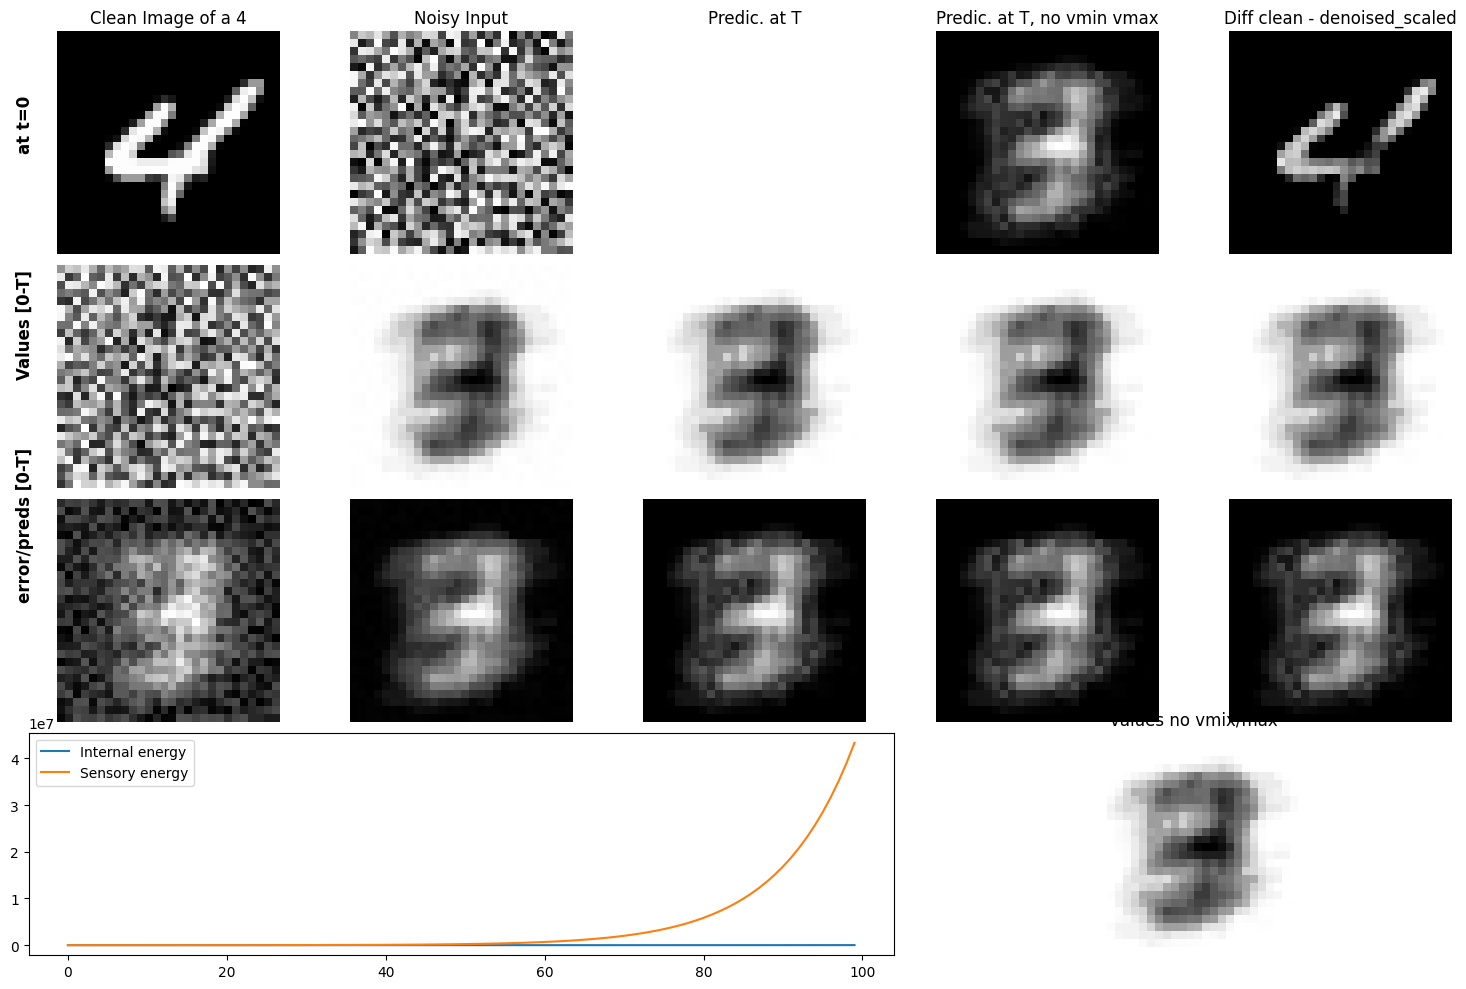

In [50]:
test_params = {
    "model_dir": model_dir,
    "T":100,
    "supervised_learning":True, 
    "num_samples": 1,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
model.pc_conv1.trace_activity_values = True 
model.pc_conv1.trace_activity_preds = True 

model.pc_conv1.restart_activity()

avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max = generation(test_loader, model, test_params, clean_images, verbose=1)
                            

[5,
 5,
 5,
 2,
 4,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 4,
 6,
 6,
 3,
 1,
 2,
 4,
 5,
 2,
 6,
 1,
 6,
 3,
 3]

In [ ]:
len(model.pc_conv1.trace["values"]), len(model.pc_conv1.trace["preds"])

In [ ]:
avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max

In [ ]:
a = model.pc_conv1.trace["values"]

a[0] == a[10]

In [ ]:
tr = model.pc_conv1.trace["values"]
print(len(tr))
# for img in tr:
#     plt.imshow(img[0:784].view(28,28).cpu().detach().numpy())
#     plt.show()

In [ ]:
# len(model.pc_conv1.trace["values"])
plt.imshow(model.pc_conv1.trace["values"][0][0:784].view(28,28).cpu())

In [50]:
import math 
# Define the range for logarithmic initialization
log_min = 1e-4  # Minimum value in the range
log_max = 1e-1  # Maximum value in the range
# num_weights = self.edge_index_single_graph.size(1)  # Number of weights to initialize
num_weights = 100  # Number of weights to initialize

# Initialize weights logarithmically between log_min and log_max
log_weights = torch.logspace(math.log10(log_min), math.log10(log_max), steps=num_weights)

# # Simulate a lognormal distribution for synaptic weights based on the description
# mu, sigma = 0, 1  # Mean and standard deviation for lognormal distribution
# weights = np.random.lognormal(mu, sigma, 1000)

# Using batch size, we want the same edge weights at each subgraph of the batch
# weights = torch.nn.Parameter(log_weights)
weights = log_weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram of the weights
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=50, density=True, alpha=0.75, color='b')
plt.title('Lognormal Distribution of Synaptic Weights')
plt.xlabel('Weight')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()